In [1]:
import pandas as pd
import numpy as np
import cassiopeia as cas
import seaborn as sns
from os.path import join, exists
from os import makedirs, getcwd
from pandarallel import pandarallel
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

pandarallel.initialize(nb_workers=32)

import pickle

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
af_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.tsv"
dp_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.DP.tsv"
ad_f = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/af_by_cell.AD.tsv"
donors = "/data2/mito_lineage/data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex/cells_meta.tsv"
prefix= "TcellDupi_may17_2021/MTblacklist"
name = "post_cass_test"
outdir = "./output/data/"
af_thresh = 0.01
dp_thresh = 2

In [3]:
outdir = join(outdir, prefix)
if not exists(outdir):
    print(f"Making outdir {outdir} in folder {getcwd()}")
    makedirs(outdir)

In [4]:
af = pd.read_csv(af_f, index_col=0, sep='\t')
dp = pd.read_csv(dp_f, index_col=0, sep='\t').astype(int)
ad = pd.read_csv(ad_f, index_col=0, sep='\t').astype(int)


## Create character matrix - binarize af by af_thresh, and set any element under dp_thresh to -1

In [5]:
#Binarize
af = af.applymap(lambda x: 0 if x<af_thresh else 1)
af
#af[af>=af_thresh] = 1
#af = af.loc[dp<dp_thresh] = -1

,1040C,10634C,10646T,1082G,10912A,1095C,11123A,11137C,11175C,11204A,...,9531G,954G,9590T,9640T,9658G,971C,9750A,9823A,983T,9861G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACAGGA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGATTGACA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGCGTTGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAAGGTACTCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
AAACGAAAGGTTAACA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCGGAAAG-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCCTGACCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCGGATGTT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def dp_where(x, dp, dp_thresh):
#    print('name', x.name)
    curr = dp.loc[x.name]<dp_thresh
#     print('curr')
#     print(curr)
    x.loc[curr] = -1 #"-"
    return x

#af = af.parallel_apply(dp_where, axis=1, args=(dp,))
# tmp0 = af.head(10).apply(dp_where, axis=1, args=(dp,0))

# tmp10 = af.head(10).apply(dp_where, axis=1, args=(dp,10))
# (tmp0==-1).sum(axis=1)

In [7]:
character_matrix = af.copy()
#character_matrix = af.parallel_apply(dp_where, axis=1, args=(dp,dp_thresh))
character_matrix

,1040C,10634C,10646T,1082G,10912A,1095C,11123A,11137C,11175C,11204A,...,9531G,954G,9590T,9640T,9658G,971C,9750A,9823A,983T,9861G
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACAGGA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGATTGACA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGCGTTGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAAGGTACTCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
AAACGAAAGGTTAACA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCCGGAAAG-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCCTGACCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
TTTGTGTTCGGATGTT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
var_map = {val:f"r{i}" for i, val in enumerate(character_matrix.columns) }
character_matrix = character_matrix.rename(var_map, axis=1)

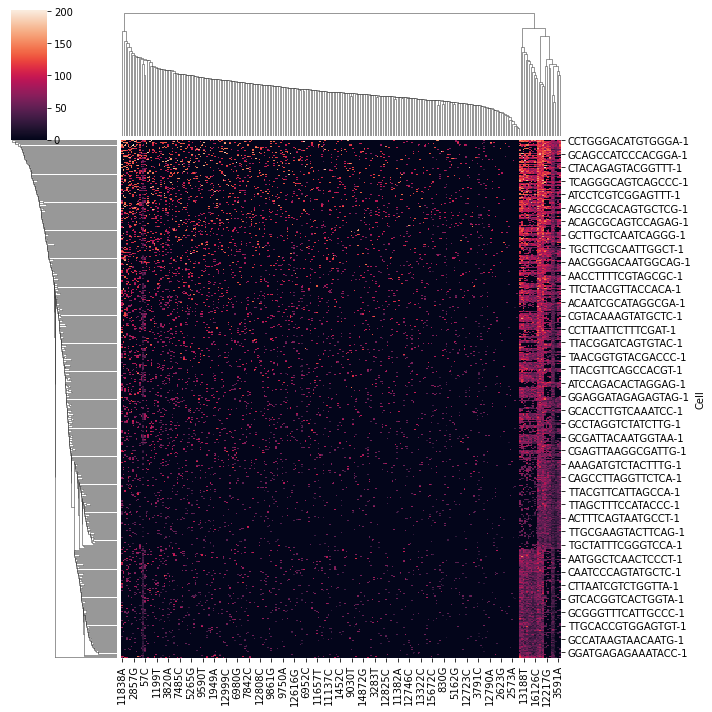

In [9]:
sns.clustermap(dp.sample(n=500))

In [10]:
character_matrix.to_csv(join(outdir, name+".csv"))

## Reconstructing Trees

In [11]:
priors=None
if priors is not None:
    cas_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)
else:
    cas_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix)
cas_tree.character_matrix.head(5)


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r258,r259,r260,r261,r262,r263,r264,r265,r266,r267
Cell,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACAGGA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGATTGACA-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
AAACGAAAGCGTTGCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACGAAAGGTACTCT-1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
AAACGAAAGGTTAACA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
cas_tree.n_cell, cas_tree.n_character,


(10051, 268)

In [13]:
# cell_meta = clone_allele_table.groupby('cellBC').agg({"intBC": 'nunique', 'UMI': 'sum', 'sampleID': 'unique'})
# cell_meta['sampleID'] = [x[0] for x in cell_meta['sampleID']]

# missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
# uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
# n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

# character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T

# cas_tree.cell_meta = cell_meta
# cas_tree.character_meta = character_meta

## HybridSolver 
1. Top-down greedy solver followed by
2. Bottom-solve of any tipe. 

In [14]:
# REINSTANTIATE the bottom and top solvers
vanilla_greedy = cas.solver.VanillaGreedySolver()
if priors is not None:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=True, seed=1234)
else:
    ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=False, seed=1234)


In [15]:
hybrid_solver = cas.solver.HybridSolver(top_solver=vanilla_greedy, bottom_solver=ilp_solver, cell_cutoff=40, threads=10)
hybrid_solver.solve(cas_tree, logfile='example_hybrid.log')


example_hybrid.log
None
subtree 0


[2021-08-06 23:29:52,596]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,600]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,603]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,605]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:52,608]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,610]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:52,643]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,646]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,648]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,651]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:52,653]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,656]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:52,706]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,710]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,712]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,715]    INFO [ILPSolver] Max potential graph layer size: 500

[2021-08-06 23:29:52,717]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,720]    INFO [ILPSolver] MIP gap: 0.01

subtree 0


[2021-08-06 23:29:52,769]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,772]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,774]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,777]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:52,779]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,781]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:52,837]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,840]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,843]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,845]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:52,847]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,849]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:52,902]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:52,905]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:52,907]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:52,909]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:52,911]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:52,914]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:53,570]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:53,573]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:53,575]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:53,578]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:53,580]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:53,582]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:53,837]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:53,839]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:53,841]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:53,843]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:53,845]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:53,847]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:29:53,949]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:53,952]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:53,954]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:53,956]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:53,959]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:53,961]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:54,970]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:29:55,022]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 41.
[2021-08-06 23:29:55,078]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) Estimating a potential graph with a maximum layer size of 500 and a ma

subtree 0


[2021-08-06 23:29:55,589]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 0 completed with a neighborhood size of 19.
[2021-08-06 23:29:55,591]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:55,593]    INFO [ILPSolver] (Process: 9430df78149cab578895a18d1c1636d2) LCA distance 19 completed with a neighborhood size of 6.[2021-08-06 23:29:55,594]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:29:55,596]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:55,598]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:55,600]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:55,602]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:55,620]    INFO [ILPSolver] (Process: 9430df78149cab578895a18d1c1636d2) LCA distance 20 completed with a neighborhood size of 6.
[2021-08-06 23:29:55,622]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) L

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:29:55,778]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 8 completed with a neighborhood size of 11.
[2021-08-06 23:29:55,779]    INFO [ILPSolver] (Process 9430df78149cab578895a18d1c1636d2) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:29:55,826]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:55,828]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:55,830]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:55,832]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:55,834]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:55,836]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:55,873]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 9 completed with a neighborhood size of 11.
[2021-08-06 23:29:55,894]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.[2021-08-06 23:29:55,896]    INFO [ILPSolver] (Process: 36fcba6ce1a7a53b697133f353af4868) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.

[2021-08-06 2

subtree 0


[2021-08-06 23:29:56,485]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:56,487]    INFO [ILPSolver] (Process: da6d965012c5277e4db64ce012d3dd85) LCA distance 4 completed with a neighborhood size of 5.[2021-08-06 23:29:56,487]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:29:56,490]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:56,492]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:56,494]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:56,497]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:56,515]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 2 completed with a neighborhood size of 21.
[2021-08-06 23:29:56,522]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 17 completed with a neighborhood size of 11.
[2021-08-06 23:29:56,525]    INFO [ILPSolver] (Process: da6d965012c5277e4db64ce012d3dd85) L

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:29:57,501]    INFO [ILPSolver] (Process da6d965012c5277e4db64ce012d3dd85) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:29:57,504]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 4 completed with a neighborhood size of 21.
[2021-08-06 23:29:57,525]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 5 completed with a neighborhood size of 19.


subtree 0


[2021-08-06 23:29:57,540]    INFO [ILPSolver] Solving tree with the following parameters.[2021-08-06 23:29:57,540]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 25 completed with a neighborhood size of 22.

[2021-08-06 23:29:57,542]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:57,544]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:57,546]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:57,549]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:57,551]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:57,611]    INFO [ILPSolver] (Process: 2eb088606a7d17d62d37611245d276dc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 19.
[2021-08-06 23:29:57,640]    INFO [ILPSolver] (Process: 2eb088606a7d17d62d37611245d276dc) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:29:57,668]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:29:58,274]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:58,277]    INFO [ILPSolver] Convergence time limit: 500[2021-08-06 23:29:58,276]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 28 completed with a neighborhood size of 26.

[2021-08-06 23:29:58,279]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:58,281]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:58,284]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:58,286]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:58,310]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:29:58,314]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 7 completed with a neighborhood size of 19.
[2021-08-06 23:29:58,344]    INFO [ILPSolver] (Process: 343617df4e87ce2e98f380ead7b86898) E

[2021-08-06 23:29:59,511]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 6 completed with a neighborhood size of 8.[2021-08-06 23:29:59,512]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 8 completed with a neighborhood size of 21.[2021-08-06 23:29:59,512]    INFO [ILPSolver] (Process: 343617df4e87ce2e98f380ead7b86898) LCA distance 21 completed with a neighborhood size of 15.


[2021-08-06 23:29:59,622]    INFO [ILPSolver] (Process: 343617df4e87ce2e98f380ead7b86898) LCA distance 22 completed with a neighborhood size of 16.
[2021-08-06 23:29:59,687]    INFO [ILPSolver] (Process: 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) LCA distance 33 completed with a neighborhood size of 27.
[2021-08-06 23:29:59,695]    INFO [ILPSolver] (Process: c4080bc2fcadf812634115a79d55c133) LCA distance 8 completed with a neighborhood size of 23.
[2021-08-06 23:29:59,733]    INFO [ILPSolver] (Process: 343617df4e87ce2e98f380ead7b86898) LCA distance 23 completed 

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:29:59,811]    INFO [ILPSolver] (Process 1b2fa4cda2ca1de4c569cdcc3ef3c7c5) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:29:59,815]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) LCA distance 9 completed with a neighborhood size of 20.
[2021-08-06 23:29:59,830]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 9 completed with a neighborhood size of 23.
[2021-08-06 23:29:59,837]    INFO [ILPSolver] (Process: e33a5aa955a53918941d8d7a7eb65679) LCA distance 8 completed with a neighborhood size of 15.
[2021-08-06 23:29:59,844]    INFO [ILPSolver] (Process: 343617df4e87ce2e98f380ead7b86898) LCA distance 24 completed with a neighborhood size of 16.


subtree 0


[2021-08-06 23:29:59,851]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:59,853]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:59,855]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:59,858]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:59,860]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:59,862]    INFO [ILPSolver] MIP gap: 0.01[2021-08-06 23:29:59,863]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 11 completed with a neighborhood size of 19.

[2021-08-06 23:29:59,901]    INFO [ILPSolver] (Process 343617df4e87ce2e98f380ead7b86898) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:29:59,929]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.


subtree 0


[2021-08-06 23:29:59,938]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:29:59,940]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:29:59,942]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:29:59,944]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:29:59,946]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:29:59,948]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:29:59,969]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:29:59,972]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 8 completed with a neighborhood size of 8.
[2021-08-06 23:29:59,998]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:30:00,005]    INFO [ILPSolver] (Process: 3db72177a75f766a7304024be8571f9b) Esti

subtree 

[2021-08-06 23:30:00,305]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 12 completed with a neighborhood size of 20.

0

[2021-08-06 23:30:00,310]    INFO [ILPSolver] Solving tree with the following parameters.[2021-08-06 23:30:00,310]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 10 completed with a neighborhood size of 23.

[2021-08-06 23:30:00,312]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:00,315]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:00,317]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:00,319]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:00,322]    INFO [ILPSolver] MIP gap: 0.01[2021-08-06 23:30:00,322]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) LCA distance 15 completed with a neighborhood size of 4.

[2021-08-06 23:30:00,347]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) LCA distance 16 completed with a neighborhood size of 4.
[2021-08-06 23:30:00,375]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) 

subtree 0


[2021-08-06 23:30:00,636]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:00,638]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:00,640]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:00,642]    INFO [ILPSolver] Max potential graph layer size: 500[2021-08-06 23:30:00,643]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) LCA distance 11 completed with a neighborhood size of 20.

[2021-08-06 23:30:00,645]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:00,647]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:00,662]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 11 completed with a neighborhood size of 8.[2021-08-06 23:30:00,663]    INFO [ILPSolver] (Process: 5a4ba72c31b51dff6a87890421838387) LCA distance 24 completed with a neighborhood size of 10.

[2021-08-06 23:30:00,672]    INFO [ILPSolver] (Process: c4080bc2fcadf812634115a79d55c133)

subtree 0


[2021-08-06 23:30:00,891]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 12 completed with a neighborhood size of 8.[2021-08-06 23:30:00,892]    INFO [ILPSolver] Solving tree with the following parameters.

[2021-08-06 23:30:00,895]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:00,897]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:00,900]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:00,902]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:00,904]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:00,983]    INFO [ILPSolver] (Process: a8989de5cf06e9ed2952f27707b79b7f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 41.
[2021-08-06 23:30:01,022]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 11 completed with a neighborhood size of 22.
[2021-08-06 23:30:01,033]    INFO [ILPSolver] (Proc

[2021-08-06 23:30:03,816]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 19 completed with a neighborhood size of 45.
[2021-08-06 23:30:03,877]    INFO [ILPSolver] (Process: d3f3474be5829fb6d620e109d4ac6e42) LCA distance 5 completed with a neighborhood size of 13.
[2021-08-06 23:30:03,888]    INFO [ILPSolver] (Process: c4080bc2fcadf812634115a79d55c133) LCA distance 16 completed with a neighborhood size of 33.
[2021-08-06 23:30:03,927]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 18 completed with a neighborhood size of 37.
[2021-08-06 23:30:03,984]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 17 completed with a neighborhood size of 31.
[2021-08-06 23:30:04,273]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 10 completed with a neighborhood size of 27.
[2021-08-06 23:30:04,281]    INFO [ILPSolver] (Process: a8989de5cf06e9ed2952f27707b79b7f) LCA distance 5 complete

[2021-08-06 23:30:10,075]    INFO [ILPSolver] (Process: d3f3474be5829fb6d620e109d4ac6e42) LCA distance 13 completed with a neighborhood size of 47.
[2021-08-06 23:30:10,127]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 15 completed with a neighborhood size of 63.
[2021-08-06 23:30:10,227]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 23 completed with a neighborhood size of 73.
[2021-08-06 23:30:10,490]    INFO [ILPSolver] (Process: a8989de5cf06e9ed2952f27707b79b7f) LCA distance 15 completed with a neighborhood size of 35.
[2021-08-06 23:30:11,252]    INFO [ILPSolver] (Process: e33a5aa955a53918941d8d7a7eb65679) LCA distance 21 completed with a neighborhood size of 64.
[2021-08-06 23:30:11,257]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) LCA distance 22 completed with a neighborhood size of 75.
[2021-08-06 23:30:11,306]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 22 comple

[2021-08-06 23:30:24,016]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 23 completed with a neighborhood size of 104.
[2021-08-06 23:30:24,545]    INFO [ILPSolver] (Process: d3f3474be5829fb6d620e109d4ac6e42) LCA distance 23 completed with a neighborhood size of 58.
[2021-08-06 23:30:24,994]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 20 completed with a neighborhood size of 100.
[2021-08-06 23:30:25,295]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) LCA distance 27 completed with a neighborhood size of 94.
[2021-08-06 23:30:25,379]    INFO [ILPSolver] (Process: e33a5aa955a53918941d8d7a7eb65679) LCA distance 27 completed with a neighborhood size of 87.
[2021-08-06 23:30:25,505]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 26 completed with a neighborhood size of 105.
[2021-08-06 23:30:26,094]    INFO [ILPSolver] (Process: d3f3474be5829fb6d620e109d4ac6e42) LCA distance 24 com

subtree 0


[2021-08-06 23:30:27,935]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:27,937]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:27,939]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:27,941]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:27,943]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:27,945]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:28,011]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:30:28,116]    INFO [ILPSolver] (Process: a8989de5cf06e9ed2952f27707b79b7f) LCA distance 22 completed with a neighborhood size of 104.
[2021-08-06 23:30:28,413]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) LCA distance 0 completed with a neighborhood size of 21.
[2021-08-06 23:30:28,522]    INFO [ILPSolver] (Pro

[2021-08-06 23:30:41,091]    INFO [ILPSolver] (Process: c4080bc2fcadf812634115a79d55c133) LCA distance 28 completed with a neighborhood size of 113.
[2021-08-06 23:30:41,773]    INFO [ILPSolver] (Process: 32c259aad5c77806ad1f64edade7c951) LCA distance 26 completed with a neighborhood size of 128.
[2021-08-06 23:30:41,912]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 24 completed with a neighborhood size of 107.
[2021-08-06 23:30:42,079]    INFO [ILPSolver] (Process: 4e671b276e9d1eefe342ffedd25613c7) LCA distance 32 completed with a neighborhood size of 96.
[2021-08-06 23:30:42,227]    INFO [ILPSolver] (Process: a40aea3e47889690ff718df02ac68c6c) LCA distance 34 completed with a neighborhood size of 94.
[2021-08-06 23:30:42,288]    INFO [ILPSolver] (Process: e33a5aa955a53918941d8d7a7eb65679) LCA distance 32 completed with a neighborhood size of 97.
[2021-08-06 23:30:42,536]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 32 com

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:30:49,244]    INFO [ILPSolver] (Process 4e671b276e9d1eefe342ffedd25613c7) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:30:49,283]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 30 completed with a neighborhood size of 133.


subtree 0


[2021-08-06 23:30:49,323]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:49,326]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:49,328]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:49,330]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:49,333]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:49,335]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:49,399]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:30:49,520]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:30:49,639]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) LCA distance 1 completed with a neighborhood size of 7.
[2021-08-06 23:30:49,756]    INFO [ILPSolver] (Process

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:30:52,157]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) LCA distance 26 completed with a neighborhood size of 96.
[2021-08-06 23:30:52,161]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) LCA distance 19 completed with a neighborhood size of 21.
[2021-08-06 23:30:52,185]    INFO [ILPSolver] (Process a40aea3e47889690ff718df02ac68c6c) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:30:52,260]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:52,262]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:52,264]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:52,266]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:52,268]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:52,270]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:52,327]    INFO [ILPSolver] (Process: 3bf953345f02337279039b6032f333b3) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 28.
[2021-08-06 23:30:52,405]    INFO [ILPSolver] (Process: 3bf953345f02337279039b6032f333b3) LCA distance 0 completed with a neighborhood size of 9.
[2021-08-06 23:30:52,465]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) LCA distance 20 completed with a neighborhood size of 25.
[2021-08-06 23:30:52,484]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:30:55,973]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:55,975]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:55,977]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:55,980]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:55,982]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:55,984]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:56,041]    INFO [ILPSolver] (Process: 0acbacc4bbd8b4fa2a72bf82d777401a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:30:56,073]    INFO [ILPSolver] (Process: 0acbacc4bbd8b4fa2a72bf82d777401a) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:30:56,103]    INFO [ILPSolver] (Process: 0acbacc4bbd8b4fa2a72bf82d777401a) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:30:56,134]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:30:57,669]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:57,672]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:57,674]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:57,676]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:57,679]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:57,681]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:57,762]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:30:57,801]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 35 completed with a neighborhood size of 120.
[2021-08-06 23:30:57,959]    INFO [ILPSolver] (Process: 4c8065175ac9512f0c5d629b642ef8af) LCA distance 31 completed with a neighborhood size of 39.
[2021-08-06 23:30:58,024]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:30:58,714]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:30:58,716]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:30:58,718]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:30:58,720]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:30:58,723]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:30:58,725]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:30:58,786]    INFO [ILPSolver] (Process: 626d9372b8492546d6b8aca92db571fb) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:30:58,877]    INFO [ILPSolver] (Process: 626d9372b8492546d6b8aca92db571fb) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:30:58,915]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 1 completed with a neighborhood size of 20.
[2021-08-06 23:30:58,966]    INFO [ILPSolver] (Proces

[2021-08-06 23:31:04,706]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 11 completed with a neighborhood size of 20.
[2021-08-06 23:31:04,782]    INFO [ILPSolver] (Process: 626d9372b8492546d6b8aca92db571fb) LCA distance 33 completed with a neighborhood size of 30.
[2021-08-06 23:31:05,154]    INFO [ILPSolver] (Process: 626d9372b8492546d6b8aca92db571fb) LCA distance 34 completed with a neighborhood size of 30.
[2021-08-06 23:31:05,171]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) LCA distance 29 completed with a neighborhood size of 112.
[2021-08-06 23:31:05,325]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 12 completed with a neighborhood size of 23.
[2021-08-06 23:31:05,537]    INFO [ILPSolver] (Process: 626d9372b8492546d6b8aca92db571fb) LCA distance 35 completed with a neighborhood size of 30.
[2021-08-06 23:31:05,553]    INFO [ILPSolver] (Process: c4080bc2fcadf812634115a79d55c133) LCA distance 33 compl

subtree 0


[2021-08-06 23:31:05,682]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:05,685]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:05,687]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:05,689]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:05,691]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:05,693]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:05,734]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 29 completed with a neighborhood size of 114.
[2021-08-06 23:31:05,751]    INFO [ILPSolver] (Process: 214f8f1f9371e4b09015e953497c7b48) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:31:05,796]    INFO [ILPSolver] (Process: 214f8f1f9371e4b09015e953497c7b48) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:31:05,839]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:31:07,159]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:07,161]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:07,163]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:07,165]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:07,167]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:07,170]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:07,227]    INFO [ILPSolver] (Process: 4aadfff6402ab8777b84be2aafb5e4f4) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:31:07,253]    INFO [ILPSolver] (Process: 4aadfff6402ab8777b84be2aafb5e4f4) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:31:07,279]    INFO [ILPSolver] (Process: 4aadfff6402ab8777b84be2aafb5e4f4) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:31:07,304]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:31:08,538]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:08,541]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:08,543]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:08,545]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:08,548]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:08,550]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:08,608]    INFO [ILPSolver] (Process: 0af5e29528b4530afe9b1b8bd1dd9245) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:31:08,627]    INFO [ILPSolver] (Process: 0af5e29528b4530afe9b1b8bd1dd9245) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:31:08,644]    INFO [ILPSolver] (Process: 0af5e29528b4530afe9b1b8bd1dd9245) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:31:08,662]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:31:09,641]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:09,643]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:09,646]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:09,648]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:09,649]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 16 completed with a neighborhood size of 52.[2021-08-06 23:31:09,650]    INFO [ILPSolver] Max potential graph lca distance: None

[2021-08-06 23:31:09,652]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:09,722]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:31:10,127]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) LCA distance 0 completed with a neighborhood size of 10.
[2021-08-06 23:31:10,267]    INFO [ILPSolver] (Proc

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:31:21,149]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) LCA distance 18 completed with a neighborhood size of 48.
[2021-08-06 23:31:21,189]    INFO [ILPSolver] (Process c4080bc2fcadf812634115a79d55c133) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:31:21,211]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 32 completed with a neighborhood size of 117.


subtree 0


[2021-08-06 23:31:21,277]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:21,279]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:21,282]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:21,284]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:21,286]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:21,289]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:21,356]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:31:21,703]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 0 completed with a neighborhood size of 15.
[2021-08-06 23:31:21,918]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) LCA distance 32 completed with a neighborhood size of 127.
[2021-08-06 23:31:22,050]    INFO [ILPSolver] (Pro

[2021-08-06 23:31:36,975]    INFO [ILPSolver] (Process: a57817124bb03ed09c69456c77847de9) LCA distance 35 completed with a neighborhood size of 117.
[2021-08-06 23:31:37,242]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 36 completed with a neighborhood size of 151.
[2021-08-06 23:31:37,263]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 42 completed with a neighborhood size of 127.
[2021-08-06 23:31:37,307]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 24 completed with a neighborhood size of 69.
[2021-08-06 23:31:37,474]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) LCA distance 27 completed with a neighborhood size of 74.
[2021-08-06 23:31:37,544]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 24 completed with a neighborhood size of 118.
[2021-08-06 23:31:39,676]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 25 co

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:31:50,053]    INFO [ILPSolver] (Process e33a5aa955a53918941d8d7a7eb65679) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:31:50,132]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) LCA distance 32 completed with a neighborhood size of 80.


subtree 0


[2021-08-06 23:31:50,153]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:50,156]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:50,158]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:50,160]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:50,163]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:50,165]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:50,235]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 47.
[2021-08-06 23:31:50,258]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 26 completed with a neighborhood size of 132.
[2021-08-06 23:31:50,382]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 29 completed with a neighborhood size of 85.
[2021-08-06 23:31:50,603]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:31:53,329]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:31:53,331]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:31:53,333]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:31:53,336]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:31:53,338]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:31:53,340]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:31:53,359]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 30 completed with a neighborhood size of 86.
[2021-08-06 23:31:53,408]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 51.
[2021-08-06 23:31:53,575]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 8 completed with a neighborhood size of 13.
[2021-08-06 23:31:53,729]    INFO [ILPSolver] (Proc

[2021-08-06 23:32:03,985]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 28 completed with a neighborhood size of 134.
[2021-08-06 23:32:04,688]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) LCA distance 19 completed with a neighborhood size of 50.
[2021-08-06 23:32:05,172]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 22 completed with a neighborhood size of 66.
[2021-08-06 23:32:06,059]    INFO [ILPSolver] (Process: 1eca88170cc6a34a3fa1201b5901c633) LCA distance 34 completed with a neighborhood size of 90.
[2021-08-06 23:32:06,460]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) LCA distance 20 completed with a neighborhood size of 62.
[2021-08-06 23:32:06,517]    INFO [ILPSolver] (Process: 392eaf817f4da58805c93b2b0a83330a) LCA distance 38 completed with a neighborhood size of 81.
[2021-08-06 23:32:06,527]    INFO [ILPSolver] (Process: cce9d2b7980a9ff4d9831f9d4815880b) LCA distance 47 compl

subtree 0


[2021-08-06 23:32:06,909]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:06,911]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:06,914]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:06,916]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:06,918]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:06,921]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:06,983]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:32:07,073]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 0 completed with a neighborhood size of 9.


Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:32:07,162]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 1 completed with a neighborhood size of 9.
[2021-08-06 23:32:07,253]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 2 completed with a neighborhood size of 9.
[2021-08-06 23:32:07,310]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 23 completed with a neighborhood size of 71.
[2021-08-06 23:32:07,343]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 3 completed with a neighborhood size of 9.
[2021-08-06 23:32:07,433]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 4 completed with a neighborhood size of 9.
[2021-08-06 23:32:07,523]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 5 completed with a neighborhood size of 9.
[2021-08-06 23:32:07,613]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 6 completed with a 

subtree 0


[2021-08-06 23:32:10,192]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:10,194]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:10,197]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:10,199]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:10,201]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:10,203]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:10,266]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:32:10,367]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 0 completed with a neighborhood size of 11.
[2021-08-06 23:32:10,379]    INFO [ILPSolver] (Process: 5577a13f8001bbeb388fc553325397ca) LCA distance 40 completed with a neighborhood size of 151.
[2021-08-06 23:32:10,390]    INFO [ILPSolver] (Pro

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:32:12,774]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 25 completed with a neighborhood size of 84.
[2021-08-06 23:32:12,970]    INFO [ILPSolver] (Process: 47eb5b13a53c879675b0e8d29236f28c) LCA distance 33 completed with a neighborhood size of 29.
[2021-08-06 23:32:13,027]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 21 completed with a neighborhood size of 24.
[2021-08-06 23:32:13,062]    INFO [ILPSolver] (Process 47eb5b13a53c879675b0e8d29236f28c) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:32:13,110]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:13,113]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:13,115]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:13,117]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:13,120]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:13,122]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:13,192]    INFO [ILPSolver] (Process: a6d4c357c01cd3c4ecb2f71d0ed92397) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 44.
[2021-08-06 23:32:13,351]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 22 completed with a neighborhood size of 27.
[2021-08-06 23:32:13,357]    INFO [ILPSolver] (Process: 455a6b13facbaea6572a9cbee7f977a0) LCA distance 40 completed with a neighborhood size of 133.
[2021-08-06 23:32:13,709]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:32:13,805]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:13,807]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:13,809]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:13,811]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:13,814]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:13,816]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:13,875]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:32:13,977]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) LCA distance 0 completed with a neighborhood size of 11.
[2021-08-06 23:32:14,008]    INFO [ILPSolver] (Process 455a6b13facbaea6572a9cbee7f977a0) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:32:14,078]    INFO [ILPSol

subtree 0


[2021-08-06 23:32:14,090]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:14,092]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:14,094]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:14,097]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:14,099]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:14,101]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:14,162]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 41.
[2021-08-06 23:32:14,180]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) LCA distance 2 completed with a neighborhood size of 11.
[2021-08-06 23:32:14,189]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 24 completed with a neighborhood size of 33.
[2021-08-06 23:32:14,251]    INFO [ILPSolver] (Proc

[2021-08-06 23:32:16,204]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) LCA distance 21 completed with a neighborhood size of 14.
[2021-08-06 23:32:16,248]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) LCA distance 20 completed with a neighborhood size of 17.
[2021-08-06 23:32:16,354]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) LCA distance 22 completed with a neighborhood size of 15.
[2021-08-06 23:32:16,419]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) LCA distance 21 completed with a neighborhood size of 18.
[2021-08-06 23:32:16,436]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 28 completed with a neighborhood size of 40.
[2021-08-06 23:32:16,511]    INFO [ILPSolver] (Process: a6d4c357c01cd3c4ecb2f71d0ed92397) LCA distance 5 completed with a neighborhood size of 19.
[2021-08-06 23:32:16,524]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) LCA distance 23 complet

Academic license - for non-commercial use only - expires 2022-07-17
Using license file /home/isshamie/gurobi.lic


[2021-08-06 23:32:19,129]    INFO [ILPSolver] (Process: 127d9be91e9ff476b4ab84f6c3673c5b) LCA distance 32 completed with a neighborhood size of 42.
[2021-08-06 23:32:19,139]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) LCA distance 31 completed with a neighborhood size of 35.
[2021-08-06 23:32:19,176]    INFO [ILPSolver] (Process 1eca88170cc6a34a3fa1201b5901c633) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:32:19,260]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:19,262]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:19,264]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:19,267]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:19,269]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:19,271]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:19,276]    INFO [ILPSolver] (Process: 738746376f45b8fe7726af4db87ecce0) LCA distance 33 completed with a neighborhood size of 24.
[2021-08-06 23:32:19,302]    INFO [ILPSolver] (Process: a6d4c357c01cd3c4ecb2f71d0ed92397) LCA distance 10 completed with a neighborhood size of 21.
[2021-08-06 23:32:19,335]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:32:19,351]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:32:19,395]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:19,397]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:19,399]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:19,401]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:19,403]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:19,406]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:19,423]    INFO [ILPSolver] (Process 5577a13f8001bbeb388fc553325397ca) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:32:19,444]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 27 completed with a neighborhood size of 93.
[2021-08-06 23:32:19,465]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:32:19,509]    INFO [ILPSo

subtree 0


[2021-08-06 23:32:19,529]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:19,531]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:19,534]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:19,536]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:19,538]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:19,541]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:19,553]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 1 completed with a neighborhood size of 6.
[2021-08-06 23:32:19,596]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 2 completed with a neighborhood size of 6.
[2021-08-06 23:32:19,607]    INFO [ILPSolver] (Process: 421f40f0a6744ab7f9e599a4583bc6bc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:32:19,640]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:32:20,014]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:20,017]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:20,019]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:20,021]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:20,024]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:20,026]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:20,032]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 3 completed with a neighborhood size of 12.
[2021-08-06 23:32:20,041]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 12 completed with a neighborhood size of 7.
[2021-08-06 23:32:20,082]    INFO [ILPSolver] (Process: 8ef40e2b8569ba8075d1aba71b87221c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:32:20,088]    INFO [ILPSolver] (Proce

[2021-08-06 23:32:20,663]    INFO [ILPSolver] (Process: 8ef40e2b8569ba8075d1aba71b87221c) LCA distance 33 completed with a neighborhood size of 6.
[2021-08-06 23:32:20,676]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 22 completed with a neighborhood size of 12.
[2021-08-06 23:32:20,690]    INFO [ILPSolver] (Process: 8ef40e2b8569ba8075d1aba71b87221c) LCA distance 34 completed with a neighborhood size of 6.
[2021-08-06 23:32:20,716]    INFO [ILPSolver] (Process 8ef40e2b8569ba8075d1aba71b87221c) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:32:20,728]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 7 completed with a neighborhood size of 12.


subtree 0


[2021-08-06 23:32:20,751]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:20,753]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:20,756]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:20,759]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:20,761]    INFO [ILPSolver] Max potential graph lca distance: None[2021-08-06 23:32:20,762]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 23 completed with a neighborhood size of 13.

[2021-08-06 23:32:20,764]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:20,821]    INFO [ILPSolver] (Process: 38e278eec2b84f26b2db4c38dffe9c85) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:32:20,831]    INFO [ILPSolver] (Process: 38e278eec2b84f26b2db4c38dffe9c85) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:32:20,841]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:32:21,088]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:21,090]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:21,092]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:21,094]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:21,097]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:21,099]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:21,130]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 27 completed with a neighborhood size of 14.
[2021-08-06 23:32:21,155]    INFO [ILPSolver] (Process: 34a55150a256e2415b7cb55d8f998770) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 20.
[2021-08-06 23:32:21,161]    INFO [ILPSolver] (Process: 34a55150a256e2415b7cb55d8f998770) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:32:21,166]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:32:21,300]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:21,302]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:21,304]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:21,306]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:21,309]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:21,311]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:21,336]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 29 completed with a neighborhood size of 15.
[2021-08-06 23:32:21,344]    INFO [ILPSolver] (Process: 421f40f0a6744ab7f9e599a4583bc6bc) LCA distance 4 completed with a neighborhood size of 23.
[2021-08-06 23:32:21,365]    INFO [ILPSolver] (Process: 97cb288e308df9ac41efcf47cb0b90d1) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:32:21,370]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:32:21,525]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:21,527]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:21,529]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:21,532]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:21,534]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:21,536]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:21,542]    INFO [ILPSolver] (Process: b3ee6ceb3a3ebe51570107a204dda5ea) LCA distance 31 completed with a neighborhood size of 15.
[2021-08-06 23:32:21,594]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 44.
[2021-08-06 23:32:21,604]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:32:21,614]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:32:21,929]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:21,931]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:21,933]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) LCA distance 30 completed with a neighborhood size of 5.[2021-08-06 23:32:21,934]    INFO [ILPSolver] Convergence iteration limit: 0

[2021-08-06 23:32:21,936]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:21,938]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:21,940]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:21,949]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) LCA distance 31 completed with a neighborhood size of 5.
[2021-08-06 23:32:21,965]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) LCA distance 32 completed with a neighborhood size of 5.
[2021-08-06 23:32:21,985]    INFO [ILPSolver] (Process: c9309717a2f7cdcf9d23f71ed1dcf5b5) L

subtree 0


[2021-08-06 23:32:22,253]    INFO [ILPSolver] (Process: e101e11764eac339ea672b4001e09ab9) LCA distance 11 completed with a neighborhood size of 5.[2021-08-06 23:32:22,254]    INFO [ILPSolver] Solving tree with the following parameters.

[2021-08-06 23:32:22,256]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:22,258]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:22,260]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:22,262]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:22,265]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:22,275]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 15 completed with a neighborhood size of 15.
[2021-08-06 23:32:22,281]    INFO [ILPSolver] (Process: e101e11764eac339ea672b4001e09ab9) LCA distance 12 completed with a neighborhood size of 6.
[2021-08-06 23:32:22,308]    INFO [ILPSolver] (Process: e101e11764eac339ea672b4001e09ab9) 

subtree 0


[2021-08-06 23:32:22,444]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:22,446]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:22,447]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 3 completed with a neighborhood size of 6.[2021-08-06 23:32:22,449]    INFO [ILPSolver] Convergence iteration limit: 0

[2021-08-06 23:32:22,451]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:22,453]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:22,455]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:22,482]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 4 completed with a neighborhood size of 6.
[2021-08-06 23:32:22,517]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 5 completed with a neighborhood size of 6.
[2021-08-06 23:32:22,519]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA 

[2021-08-06 23:32:24,167]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 36 completed with a neighborhood size of 11.
[2021-08-06 23:32:24,235]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 37 completed with a neighborhood size of 11.
[2021-08-06 23:32:24,259]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 21 completed with a neighborhood size of 32.
[2021-08-06 23:32:24,304]    INFO [ILPSolver] (Process: 5cb2549b811232c4bb3d60060d2eb179) LCA distance 38 completed with a neighborhood size of 11.
[2021-08-06 23:32:24,362]    INFO [ILPSolver] (Process 5cb2549b811232c4bb3d60060d2eb179) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:32:24,392]    INFO [ILPSolver] (Process: a0d79b6abad108cc4ee2722bd1aba309) LCA distance 38 completed with a neighborhood size of 45.


subtree 0


[2021-08-06 23:32:24,400]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:24,402]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:24,404]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:24,406]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:24,411]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:24,413]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:24,478]    INFO [ILPSolver] (Process: debc845b0a1722779d1ee90ffed3b15c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:32:24,500]    INFO [ILPSolver] (Process: 421f40f0a6744ab7f9e599a4583bc6bc) LCA distance 13 completed with a neighborhood size of 23.
[2021-08-06 23:32:24,528]    INFO [ILPSolver] (Process: e405a33a1c23be58b57bdaf389b622da) LCA distance 3 completed with a neighborhood size of 12.
[2021-08-06 23:32:24,796]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:32:26,989]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:26,991]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:26,993]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:26,995]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:26,997]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:26,999]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:27,054]    INFO [ILPSolver] (Process: c3b724dc6188c8ba7e3e619a50c27f13) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:32:27,109]    INFO [ILPSolver] (Process: c3b724dc6188c8ba7e3e619a50c27f13) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:32:27,165]    INFO [ILPSolver] (Process: c3b724dc6188c8ba7e3e619a50c27f13) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:32:27,221]    INFO [ILPSolver] (Process

[2021-08-06 23:32:29,589]    INFO [ILPSolver] (Process: a6d4c357c01cd3c4ecb2f71d0ed92397) LCA distance 18 completed with a neighborhood size of 74.
[2021-08-06 23:32:29,744]    INFO [ILPSolver] (Process: debc845b0a1722779d1ee90ffed3b15c) LCA distance 15 completed with a neighborhood size of 20.
[2021-08-06 23:32:29,869]    INFO [ILPSolver] (Process: c3b724dc6188c8ba7e3e619a50c27f13) LCA distance 31 completed with a neighborhood size of 27.
[2021-08-06 23:32:30,202]    INFO [ILPSolver] (Process: c3b724dc6188c8ba7e3e619a50c27f13) LCA distance 32 completed with a neighborhood size of 29.
[2021-08-06 23:32:30,219]    INFO [ILPSolver] (Process: e405a33a1c23be58b57bdaf389b622da) LCA distance 13 completed with a neighborhood size of 35.
[2021-08-06 23:32:30,308]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 29 completed with a neighborhood size of 49.
[2021-08-06 23:32:30,332]    INFO [ILPSolver] (Process: debc845b0a1722779d1ee90ffed3b15c) LCA distance 16 comple

subtree 0


[2021-08-06 23:32:32,536]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:32,539]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:32,541]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:32,543]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:32,546]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:32,548]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:32,616]    INFO [ILPSolver] (Process: fa6cf70e82a2e31047f686c527c71838) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:32:33,287]    INFO [ILPSolver] (Process: fa6cf70e82a2e31047f686c527c71838) LCA distance 0 completed with a neighborhood size of 26.
[2021-08-06 23:32:33,366]    INFO [ILPSolver] (Process: 7cb6e7c36380cb50d09518260f094854) LCA distance 32 completed with a neighborhood size of 52.
[2021-08-06 23:32:33,429]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:32:35,684]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:35,686]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:35,688]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:35,690]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:35,692]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:35,695]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:35,756]    INFO [ILPSolver] (Process: 694cfba76d2c9a1150ecdcfb5311d6e4) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:32:35,908]    INFO [ILPSolver] (Process: 694cfba76d2c9a1150ecdcfb5311d6e4) LCA distance 0 completed with a neighborhood size of 12.
[2021-08-06 23:32:35,976]    INFO [ILPSolver] (Process: fa6cf70e82a2e31047f686c527c71838) LCA distance 4 completed with a neighborhood size of 26.
[2021-08-06 23:32:35,980]    INFO [ILPSolver] (Proce

[2021-08-06 23:32:43,282]    INFO [ILPSolver] (Process: 694cfba76d2c9a1150ecdcfb5311d6e4) LCA distance 25 completed with a neighborhood size of 47.
[2021-08-06 23:32:43,337]    INFO [ILPSolver] (Process: debc845b0a1722779d1ee90ffed3b15c) LCA distance 23 completed with a neighborhood size of 89.
[2021-08-06 23:32:43,886]    INFO [ILPSolver] (Process: a6d4c357c01cd3c4ecb2f71d0ed92397) LCA distance 23 completed with a neighborhood size of 93.
[2021-08-06 23:32:44,194]    INFO [ILPSolver] (Process: 694cfba76d2c9a1150ecdcfb5311d6e4) LCA distance 26 completed with a neighborhood size of 47.
[2021-08-06 23:32:44,227]    INFO [ILPSolver] (Process: fa6cf70e82a2e31047f686c527c71838) LCA distance 15 completed with a neighborhood size of 40.
[2021-08-06 23:32:44,737]    INFO [ILPSolver] (Process: e405a33a1c23be58b57bdaf389b622da) LCA distance 20 completed with a neighborhood size of 89.
[2021-08-06 23:32:45,105]    INFO [ILPSolver] (Process: 694cfba76d2c9a1150ecdcfb5311d6e4) LCA distance 27 comple

subtree 0


[2021-08-06 23:32:53,116]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:53,119]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:53,121]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:53,123]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:53,125]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:53,128]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:53,186]    INFO [ILPSolver] (Process: 41922bf2da12f399dc616f1c372b8506) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:32:53,243]    INFO [ILPSolver] (Process: 41922bf2da12f399dc616f1c372b8506) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:32:53,299]    INFO [ILPSolver] (Process: 41922bf2da12f399dc616f1c372b8506) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:32:53,355]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:32:55,656]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:55,658]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:55,661]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:55,663]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:55,665]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:55,667]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:55,727]    INFO [ILPSolver] (Process: b560b92419ae675ab42601eeb87523a2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:32:55,771]    INFO [ILPSolver] (Process: b560b92419ae675ab42601eeb87523a2) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:32:55,815]    INFO [ILPSolver] (Process: b560b92419ae675ab42601eeb87523a2) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:32:55,859]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:32:57,987]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:57,990]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:57,992]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:57,994]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:57,997]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:57,999]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:58,057]    INFO [ILPSolver] (Process: 192cb2fd0d391baa230b5c05d4f5fa8e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:32:58,092]    INFO [ILPSolver] (Process: 192cb2fd0d391baa230b5c05d4f5fa8e) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:32:58,127]    INFO [ILPSolver] (Process: 192cb2fd0d391baa230b5c05d4f5fa8e) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:32:58,161]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:32:59,136]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:32:59,139]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:32:59,141]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:32:59,144]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:32:59,146]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:32:59,148]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:32:59,207]    INFO [ILPSolver] (Process: ab80279f3f7d10d9b70364fc0703e820) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:32:59,229]    INFO [ILPSolver] (Process: ab80279f3f7d10d9b70364fc0703e820) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:32:59,250]    INFO [ILPSolver] (Process: ab80279f3f7d10d9b70364fc0703e820) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:32:59,271]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:33:00,100]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:33:00,102]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:33:00,104]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:33:00,106]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:33:00,109]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:33:00,111]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:33:00,112]    INFO [ILPSolver] (Process: ad6e8f28588466e63b881032840ae2c1) LCA distance 36 completed with a neighborhood size of 115.
[2021-08-06 23:33:00,181]    INFO [ILPSolver] (Process: d4f25a2f366bbf79a9ee25d1bdc0f285) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:33:00,299]    INFO [ILPSolver] (Process: eef8378b342aa2d0802dbe2c90b23c56) LCA distance 36 completed with a neighborhood size of 136.
[2021-08-06 23:33:00,427]    INFO [ILPSolver] (P

subtree 0


[2021-08-06 23:33:00,930]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:33:00,932]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:33:00,935]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:33:00,937]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:33:00,940]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:33:00,942]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:33:01,002]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:33:01,083]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:33:01,094]    INFO [ILPSolver] (Process: d4f25a2f366bbf79a9ee25d1bdc0f285) LCA distance 1 completed with a neighborhood size of 12.
[2021-08-06 23:33:01,163]    INFO [ILPSolver] (Proces

[2021-08-06 23:33:07,169]    INFO [ILPSolver] (Process: e405a33a1c23be58b57bdaf389b622da) LCA distance 26 completed with a neighborhood size of 97.
[2021-08-06 23:33:07,407]    INFO [ILPSolver] (Process: d4f25a2f366bbf79a9ee25d1bdc0f285) LCA distance 13 completed with a neighborhood size of 37.
[2021-08-06 23:33:07,454]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) LCA distance 30 completed with a neighborhood size of 35.
[2021-08-06 23:33:07,939]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) LCA distance 31 completed with a neighborhood size of 35.
[2021-08-06 23:33:08,424]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) LCA distance 32 completed with a neighborhood size of 35.
[2021-08-06 23:33:08,446]    INFO [ILPSolver] (Process: d4f25a2f366bbf79a9ee25d1bdc0f285) LCA distance 14 completed with a neighborhood size of 43.
[2021-08-06 23:33:08,910]    INFO [ILPSolver] (Process: 4c835854c7ef71282ca8bc889f28d62b) LCA distance 33 comple

subtree 0


[2021-08-06 23:33:09,607]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:33:09,609]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:33:09,612]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:33:09,614]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:33:09,616]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:33:09,618]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:33:09,670]    INFO [ILPSolver] (Process: debc845b0a1722779d1ee90ffed3b15c) LCA distance 29 completed with a neighborhood size of 115.
[2021-08-06 23:33:09,691]    INFO [ILPSolver] (Process: 02e2fee72af5e66b0b58a17bcff62883) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:33:09,848]    INFO [ILPSolver] (Process: d4f25a2f366bbf79a9ee25d1bdc0f285) LCA distance 15 completed with a neighborhood size of 54.
[2021-08-06 23:33:10,036]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:35:21,888]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:35:21,891]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:35:21,893]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:35:21,895]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:35:21,897]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:35:21,899]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:35:21,928]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) LCA distance 44 completed with a neighborhood size of 175.
[2021-08-06 23:35:21,936]    INFO [ILPSolver] (Process: c538baec02e8afcf8cd363698c1ba06a) LCA distance 9 completed with a neighborhood size of 17.
[2021-08-06 23:35:21,963]    INFO [ILPSolver] (Process: b08af0f8f4d14be10221ab89da9bab0a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:35:22,120]    INFO [ILPSolver] (Pro

[2021-08-06 23:35:29,816]    INFO [ILPSolver] (Process: c1a4c3dbe7dfbedd75242b1ab66062cb) LCA distance 21 completed with a neighborhood size of 99.
[2021-08-06 23:35:29,896]    INFO [ILPSolver] (Process: b08af0f8f4d14be10221ab89da9bab0a) LCA distance 30 completed with a neighborhood size of 41.
[2021-08-06 23:35:30,514]    INFO [ILPSolver] (Process: c538baec02e8afcf8cd363698c1ba06a) LCA distance 18 completed with a neighborhood size of 67.
[2021-08-06 23:35:30,525]    INFO [ILPSolver] (Process: b08af0f8f4d14be10221ab89da9bab0a) LCA distance 31 completed with a neighborhood size of 41.
[2021-08-06 23:35:31,216]    INFO [ILPSolver] (Process: b08af0f8f4d14be10221ab89da9bab0a) LCA distance 32 completed with a neighborhood size of 43.
[2021-08-06 23:35:31,479]    INFO [ILPSolver] (Process: 1268e1c0013cb209589c70675ccb9ad9) LCA distance 31 completed with a neighborhood size of 128.
[2021-08-06 23:35:31,914]    INFO [ILPSolver] (Process: b08af0f8f4d14be10221ab89da9bab0a) LCA distance 33 compl

subtree 0


[2021-08-06 23:35:35,725]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:35:35,727]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:35:35,729]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:35:35,732]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:35:35,734]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:35:35,736]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:35:35,791]    INFO [ILPSolver] (Process: 4e1a0b2061bf142c21d55ca488ed5a69) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:35:35,860]    INFO [ILPSolver] (Process: 4e1a0b2061bf142c21d55ca488ed5a69) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:35:35,923]    INFO [ILPSolver] (Process: 4e1a0b2061bf142c21d55ca488ed5a69) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:35:35,985]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:35:39,796]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:35:39,798]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:35:39,800]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:35:39,802]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:35:39,805]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:35:39,807]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:35:39,870]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:35:40,281]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) LCA distance 0 completed with a neighborhood size of 18.
[2021-08-06 23:35:40,700]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) LCA distance 1 completed with a neighborhood size of 18.
[2021-08-06 23:35:41,068]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:35:50,175]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:35:50,178]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:35:50,180]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:35:50,182]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:35:50,184]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:35:50,187]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:35:50,250]    INFO [ILPSolver] (Process: 9907c69c328464d52b6dbc4417bcc4bc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:35:50,316]    INFO [ILPSolver] (Process: bb87d25178e12d8dd85a85cf1daefed4) LCA distance 37 completed with a neighborhood size of 171.
[2021-08-06 23:35:50,347]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) LCA distance 18 completed with a neighborhood size of 53.
[2021-08-06 23:35:50,525]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:35:58,053]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:35:58,055]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:35:58,057]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:35:58,060]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:35:58,062]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:35:58,064]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:35:58,127]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:35:58,264]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) LCA distance 0 completed with a neighborhood size of 13.
[2021-08-06 23:35:58,394]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) LCA distance 1 completed with a neighborhood size of 13.
[2021-08-06 23:35:58,522]    INFO [ILPSolver] (Proce

[2021-08-06 23:36:08,497]    INFO [ILPSolver] (Process: 9907c69c328464d52b6dbc4417bcc4bc) LCA distance 25 completed with a neighborhood size of 70.
[2021-08-06 23:36:08,516]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) LCA distance 33 completed with a neighborhood size of 45.
[2021-08-06 23:36:08,582]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) LCA distance 25 completed with a neighborhood size of 100.
[2021-08-06 23:36:09,158]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) LCA distance 48 completed with a neighborhood size of 175.
[2021-08-06 23:36:09,301]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) LCA distance 34 completed with a neighborhood size of 46.
[2021-08-06 23:36:10,084]    INFO [ILPSolver] (Process: b84bb7d922b98e5dc0bfab5a7d7c7797) LCA distance 35 completed with a neighborhood size of 46.
[2021-08-06 23:36:10,602]    INFO [ILPSolver] (Process: 9907c69c328464d52b6dbc4417bcc4bc) LCA distance 26 comp

subtree 0


[2021-08-06 23:36:11,075]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:11,077]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:11,079]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:11,082]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:11,084]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:11,086]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:11,154]    INFO [ILPSolver] (Process: b8e2016c75232887cc85b4f74e49873d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 49.
[2021-08-06 23:36:11,163]    INFO [ILPSolver] (Process: c538baec02e8afcf8cd363698c1ba06a) LCA distance 29 completed with a neighborhood size of 110.
[2021-08-06 23:36:11,539]    INFO [ILPSolver] (Process: b8e2016c75232887cc85b4f74e49873d) LCA distance 0 completed with a neighborhood size of 17.
[2021-08-06 23:36:11,921]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:36:18,366]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:18,368]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:18,371]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:18,373]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:18,375]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:18,377]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:18,447]    INFO [ILPSolver] (Process: 0316b012432679c4a2b7725c5490a2f2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:36:18,768]    INFO [ILPSolver] (Process: 0316b012432679c4a2b7725c5490a2f2) LCA distance 0 completed with a neighborhood size of 13.
[2021-08-06 23:36:18,813]    INFO [ILPSolver] (Process: 7a2ef3057c098c0026ecad277583b616) LCA distance 36 completed with a neighborhood size of 130.
[2021-08-06 23:36:19,088]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:36:31,819]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:31,822]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:31,824]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:31,826]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:31,829]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:31,831]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:31,853]    INFO [ILPSolver] (Process: 0316b012432679c4a2b7725c5490a2f2) LCA distance 22 completed with a neighborhood size of 73.
[2021-08-06 23:36:31,902]    INFO [ILPSolver] (Process: 7d5f258aeb09cb9b6933880b3b86f098) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:36:31,927]    INFO [ILPSolver] (Process: 7a2ef3057c098c0026ecad277583b616) LCA distance 38 completed with a neighborhood size of 131.
[2021-08-06 23:36:32,351]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:36:32,938]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:32,940]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:32,942]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:32,944]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:32,947]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:32,949]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:33,012]    INFO [ILPSolver] (Process: 8b4f14c9dd94b356a86aec66974ab272) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:36:33,185]    INFO [ILPSolver] (Process: 8b4f14c9dd94b356a86aec66974ab272) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:36:33,356]    INFO [ILPSolver] (Process: 8b4f14c9dd94b356a86aec66974ab272) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:36:33,385]    INFO [ILPSolver] (Process

[2021-08-06 23:36:42,954]    INFO [ILPSolver] (Process: 8b4f14c9dd94b356a86aec66974ab272) LCA distance 25 completed with a neighborhood size of 50.
[2021-08-06 23:36:42,967]    INFO [ILPSolver] (Process: 5524d61df4c9b941c9788c007fe5d22b) LCA distance 32 completed with a neighborhood size of 120.
[2021-08-06 23:36:43,049]    INFO [ILPSolver] (Process: b8e2016c75232887cc85b4f74e49873d) LCA distance 27 completed with a neighborhood size of 99.
[2021-08-06 23:36:43,569]    INFO [ILPSolver] (Process: 7d5f258aeb09cb9b6933880b3b86f098) LCA distance 18 completed with a neighborhood size of 51.
[2021-08-06 23:36:43,750]    INFO [ILPSolver] (Process: 0316b012432679c4a2b7725c5490a2f2) LCA distance 26 completed with a neighborhood size of 94.
[2021-08-06 23:36:43,986]    INFO [ILPSolver] (Process: 8b4f14c9dd94b356a86aec66974ab272) LCA distance 26 completed with a neighborhood size of 51.
[2021-08-06 23:36:44,517]    INFO [ILPSolver] (Process: 121b936660cd23a525d3df57a3ba0b71) LCA distance 51 compl

subtree 0


[2021-08-06 23:36:45,606]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:45,608]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:45,610]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:45,613]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:45,615]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:45,617]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:45,680]    INFO [ILPSolver] (Process: e2176767a9d92a0116edad637a63e9fc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:36:45,789]    INFO [ILPSolver] (Process: e2176767a9d92a0116edad637a63e9fc) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:36:45,896]    INFO [ILPSolver] (Process: e2176767a9d92a0116edad637a63e9fc) LCA distance 1 completed with a neighborhood size of 7.
[2021-08-06 23:36:46,003]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:36:48,415]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:48,417]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:48,419]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:48,422]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:48,424]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:48,426]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:48,487]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:36:48,659]    INFO [ILPSolver] (Process: e2176767a9d92a0116edad637a63e9fc) LCA distance 20 completed with a neighborhood size of 27.[2021-08-06 23:36:48,659]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) LCA distance 0 completed with a neighborhood size of 11.

[2021-08-06 23:36:48,838]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:36:50,304]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:50,307]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:50,309]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:50,311]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:50,314]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:50,316]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:50,378]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 45.
[2021-08-06 23:36:50,436]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) LCA distance 10 completed with a neighborhood size of 12.
[2021-08-06 23:36:50,456]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:36:50,528]    INFO [ILPSolver] (Proce

[2021-08-06 23:36:53,915]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) LCA distance 20 completed with a neighborhood size of 37.
[2021-08-06 23:36:54,121]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 30 completed with a neighborhood size of 25.
[2021-08-06 23:36:54,375]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 31 completed with a neighborhood size of 25.
[2021-08-06 23:36:54,432]    INFO [ILPSolver] (Process: e2176767a9d92a0116edad637a63e9fc) LCA distance 30 completed with a neighborhood size of 40.
[2021-08-06 23:36:54,508]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) LCA distance 21 completed with a neighborhood size of 38.
[2021-08-06 23:36:54,643]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 32 completed with a neighborhood size of 25.
[2021-08-06 23:36:54,905]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 33 comple

subtree 0


[2021-08-06 23:36:56,592]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:56,595]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:56,597]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:56,599]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:56,601]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:56,604]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:56,676]    INFO [ILPSolver] (Process: f670c0f850fb5e3d7f9dfc21b2ee37c2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:36:56,784]    INFO [ILPSolver] (Process: ae5c744330f4a5b881cd9e1071416900) LCA distance 39 completed with a neighborhood size of 29.
[2021-08-06 23:36:57,091]    INFO [ILPSolver] (Process: ffb5abaaf609469a3f0ea91882c02d54) LCA distance 25 completed with a neighborhood size of 40.
[2021-08-06 23:36:57,108]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:36:57,926]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:57,928]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:57,930]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:57,932]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:57,935]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:57,937]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:57,967]    INFO [ILPSolver] (Process: bb87d25178e12d8dd85a85cf1daefed4) LCA distance 43 completed with a neighborhood size of 172.
[2021-08-06 23:36:57,982]    INFO [ILPSolver] (Process: f670c0f850fb5e3d7f9dfc21b2ee37c2) LCA distance 1 completed with a neighborhood size of 19.
[2021-08-06 23:36:57,998]    INFO [ILPSolver] (Process: 2e4f6e8ab36d1d15fcc7c3d44e51d2b7) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:36:58,097]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:36:58,984]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:36:58,986]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:36:58,988]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:36:58,990]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:36:58,993]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:36:58,995]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:36:59,055]    INFO [ILPSolver] (Process: 6352d2d109f51c7fd65a2314718a2928) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:36:59,076]    INFO [ILPSolver] (Process: 2e4f6e8ab36d1d15fcc7c3d44e51d2b7) LCA distance 10 completed with a neighborhood size of 9.
[2021-08-06 23:36:59,116]    INFO [ILPSolver] (Process: 6352d2d109f51c7fd65a2314718a2928) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:36:59,176]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:37:01,160]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:01,162]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:01,164]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:01,166]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:01,168]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:01,171]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:01,186]    INFO [ILPSolver] (Process: f670c0f850fb5e3d7f9dfc21b2ee37c2) LCA distance 6 completed with a neighborhood size of 19.
[2021-08-06 23:37:01,196]    INFO [ILPSolver] (Process: 2e4f6e8ab36d1d15fcc7c3d44e51d2b7) LCA distance 21 completed with a neighborhood size of 25.
[2021-08-06 23:37:01,228]    INFO [ILPSolver] (Process: 8176bef82a52e06aad5854cbf43fd326) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:37:01,264]    INFO [ILPSolver] (Proc

subtree 0

[2021-08-06 23:37:03,140]    INFO [ILPSolver] (Process: 8176bef82a52e06aad5854cbf43fd326) LCA distance 31 completed with a neighborhood size of 17.


[2021-08-06 23:37:03,144]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:03,146]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:03,148]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:03,150]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:03,152]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:03,154]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:03,212]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 31.
[2021-08-06 23:37:03,261]    INFO [ILPSolver] (Process: 8176bef82a52e06aad5854cbf43fd326) LCA distance 32 completed with a neighborhood size of 17.
[2021-08-06 23:37:03,268]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:37:03,322]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:37:03,469]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:03,472]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:03,474]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:03,476]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:03,478]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:03,480]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:03,485]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 4 completed with a neighborhood size of 3.
[2021-08-06 23:37:03,537]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 5 completed with a neighborhood size of 3.
[2021-08-06 23:37:03,538]    INFO [ILPSolver] (Process: c30cf8c9bcba789c8c52fcb70e8d6ecd) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:37:03,564]    INFO [ILPSolver] (Process

[2021-08-06 23:37:04,508]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 20 completed with a neighborhood size of 12.
[2021-08-06 23:37:04,532]    INFO [ILPSolver] (Process: f670c0f850fb5e3d7f9dfc21b2ee37c2) LCA distance 11 completed with a neighborhood size of 25.
[2021-08-06 23:37:04,551]    INFO [ILPSolver] (Process: c30cf8c9bcba789c8c52fcb70e8d6ecd) LCA distance 32 completed with a neighborhood size of 9.
[2021-08-06 23:37:04,580]    INFO [ILPSolver] (Process: b8e2016c75232887cc85b4f74e49873d) LCA distance 32 completed with a neighborhood size of 110.
[2021-08-06 23:37:04,604]    INFO [ILPSolver] (Process: c30cf8c9bcba789c8c52fcb70e8d6ecd) LCA distance 33 completed with a neighborhood size of 10.
[2021-08-06 23:37:04,614]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 21 completed with a neighborhood size of 13.
[2021-08-06 23:37:04,657]    INFO [ILPSolver] (Process: c30cf8c9bcba789c8c52fcb70e8d6ecd) LCA distance 34 comple

subtree 0


[2021-08-06 23:37:04,773]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:04,776]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:04,778]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:04,780]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:04,783]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:04,785]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:04,843]    INFO [ILPSolver] (Process: 39032dce6b4d3831766444fa3bfbb8f2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 28.
[2021-08-06 23:37:04,846]    INFO [ILPSolver] (Process: 58f18b51762a1060ceaded346b1b6726) LCA distance 23 completed with a neighborhood size of 15.
[2021-08-06 23:37:04,862]    INFO [ILPSolver] (Process: 39032dce6b4d3831766444fa3bfbb8f2) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:37:04,881]    INFO [ILPSolver] (Proce

subtree 0subtree
 0

[2021-08-06 23:37:05,428]    INFO [ILPSolver] Solving tree with the following parameters.


[2021-08-06 23:37:05,430]    INFO [ILPSolver] Convergence time limit: 500[2021-08-06 23:37:05,431]    INFO [ILPSolver] Solving tree with the following parameters.

[2021-08-06 23:37:05,432]    INFO [ILPSolver] Convergence iteration limit: 0[2021-08-06 23:37:05,433]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:37:05,434]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:05,436]    INFO [ILPSolver] Convergence iteration limit: 0[2021-08-06 23:37:05,437]    INFO [ILPSolver] Max potential graph lca distance: None

[2021-08-06 23:37:05,438]    INFO [ILPSolver] Max potential graph layer size: 500[2021-08-06 23:37:05,439]    INFO [ILPSolver] MIP gap: 0.01

[2021-08-06 23:37:05,440]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:05,443]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:05,502]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) Estimating a potential graph with a maximum layer size of 500 a

subtree 0


[2021-08-06 23:37:06,051]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:06,053]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:06,055]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:06,057]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:06,059]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:06,062]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:06,089]    INFO [ILPSolver] (Process: 0316b012432679c4a2b7725c5490a2f2) LCA distance 31 completed with a neighborhood size of 115.
[2021-08-06 23:37:06,118]    INFO [ILPSolver] (Process: 8a1eac1067805b85d87594b7e91f979f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:37:06,120]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) LCA distance 5 completed with a neighborhood size of 6.
[2021-08-06 23:37:06,159]    INFO [ILPSolver] (Proc

[2021-08-06 23:37:08,094]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) LCA distance 21 completed with a neighborhood size of 18.
[2021-08-06 23:37:08,142]    INFO [ILPSolver] (Process: 0dd25ca761f2df31612da1dae94897b5) LCA distance 4 completed with a neighborhood size of 12.
[2021-08-06 23:37:08,157]    INFO [ILPSolver] (Process: 8a1eac1067805b85d87594b7e91f979f) LCA distance 29 completed with a neighborhood size of 16.
[2021-08-06 23:37:08,214]    INFO [ILPSolver] (Process 8a1eac1067805b85d87594b7e91f979f) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:37:08,252]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:08,254]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:08,256]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:08,259]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:08,261]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:08,263]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:08,318]    INFO [ILPSolver] (Process: 242b66f7d7d7770d1417142be363db6f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:37:08,328]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) LCA distance 22 completed with a neighborhood size of 21.
[2021-08-06 23:37:08,359]    INFO [ILPSolver] (Process: 242b66f7d7d7770d1417142be363db6f) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:37:08,399]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:37:09,751]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:09,753]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:09,755]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:09,757]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:09,760]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:09,762]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:09,825]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:37:09,901]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:37:09,976]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:37:10,049]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:37:10,137]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:10,140]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:10,142]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:10,144]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:10,146]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:10,149]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:10,163]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) LCA distance 26 completed with a neighborhood size of 35.
[2021-08-06 23:37:10,199]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 4 completed with a neighborhood size of 8.
[2021-08-06 23:37:10,210]    INFO [ILPSolver] (Process: 37036178159660d3ec832cc62b36267c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:37:10,254]    INFO [ILPSolver] (Proce

[2021-08-06 23:37:11,869]    INFO [ILPSolver] (Process: 37036178159660d3ec832cc62b36267c) LCA distance 25 completed with a neighborhood size of 18.
[2021-08-06 23:37:11,888]    INFO [ILPSolver] (Process: d77e40f6cffa92f50c59463d29cade6a) LCA distance 29 completed with a neighborhood size of 37.
[2021-08-06 23:37:11,921]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 22 completed with a neighborhood size of 18.
[2021-08-06 23:37:11,957]    INFO [ILPSolver] (Process: 0dd25ca761f2df31612da1dae94897b5) LCA distance 11 completed with a neighborhood size of 18.
[2021-08-06 23:37:12,024]    INFO [ILPSolver] (Process: 37036178159660d3ec832cc62b36267c) LCA distance 26 completed with a neighborhood size of 19.
[2021-08-06 23:37:12,102]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 23 completed with a neighborhood size of 20.
[2021-08-06 23:37:12,179]    INFO [ILPSolver] (Process: 37036178159660d3ec832cc62b36267c) LCA distance 27 comple

subtree 0


[2021-08-06 23:37:12,832]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:12,834]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:12,836]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:12,838]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:12,840]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:12,843]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:12,907]    INFO [ILPSolver] (Process: 8bea768d0db7b9cb209a811a807480a4) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:37:13,002]    INFO [ILPSolver] (Process: 3b974ac164b5198155270ee41f6a31f5) LCA distance 28 completed with a neighborhood size of 21.
[2021-08-06 23:37:13,029]    INFO [ILPSolver] (Process: 8bea768d0db7b9cb209a811a807480a4) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:37:13,150]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:37:13,862]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:13,865]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:13,867]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:13,869]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:13,871]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:13,874]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:13,920]    INFO [ILPSolver] (Process: 8bea768d0db7b9cb209a811a807480a4) LCA distance 7 completed with a neighborhood size of 2.
[2021-08-06 23:37:13,929]    INFO [ILPSolver] (Process: 77e47dcfaa84defc6ae86deeee6c11fd) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:37:13,992]    INFO [ILPSolver] (Process: 77e47dcfaa84defc6ae86deeee6c11fd) LCA distance 0 completed with a neighborhood size of 9.
[2021-08-06 23:37:14,046]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:37:16,093]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:16,095]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:16,097]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:16,099]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:16,102]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:16,104]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:16,158]    INFO [ILPSolver] (Process: 0e1090c5fe87036f20d28b10b3b325d8) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 41.
[2021-08-06 23:37:16,188]    INFO [ILPSolver] (Process: 0e1090c5fe87036f20d28b10b3b325d8) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:37:16,217]    INFO [ILPSolver] (Process: 0e1090c5fe87036f20d28b10b3b325d8) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:37:16,246]    INFO [ILPSolver] (Process

subtree 

[2021-08-06 23:37:18,104]    INFO [ILPSolver] (Process: 0e1090c5fe87036f20d28b10b3b325d8) LCA distance 40 completed with a neighborhood size of 15.

0

[2021-08-06 23:37:18,111]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:18,113]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:18,115]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:18,118]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:18,120]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:18,122]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:18,136]    INFO [ILPSolver] (Process: 8bea768d0db7b9cb209a811a807480a4) LCA distance 22 completed with a neighborhood size of 42.
[2021-08-06 23:37:18,192]    INFO [ILPSolver] (Process: d534dd766489e2d420ec872863e02564) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:37:18,206]    INFO [ILPSolver] (Process: 0e1090c5fe87036f20d28b10b3b325d8) LCA distance 41 completed with a neighborhood size of 15.
[2021-08-06 23:37:18,260]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:37:18,296]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:18,298]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:18,300]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:18,302]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:18,305]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:18,307]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:18,363]    INFO [ILPSolver] (Process: fb0ef10fa64de3484fac13838e5b3cad) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 31.
[2021-08-06 23:37:18,381]    INFO [ILPSolver] (Process: fb0ef10fa64de3484fac13838e5b3cad) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:37:18,398]    INFO [ILPSolver] (Process: fb0ef10fa64de3484fac13838e5b3cad) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:37:18,415]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:37:19,048]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:19,050]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:19,052]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:19,054]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:19,056]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:19,058]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:19,092]    INFO [ILPSolver] (Process: 8bea768d0db7b9cb209a811a807480a4) LCA distance 23 completed with a neighborhood size of 49.
[2021-08-06 23:37:19,125]    INFO [ILPSolver] (Process: e03f93dd6797e2f756d50208949f35b1) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:37:19,166]    INFO [ILPSolver] (Process: d534dd766489e2d420ec872863e02564) LCA distance 1 completed with a neighborhood size of 22.
[2021-08-06 23:37:19,285]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:37:22,005]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:22,008]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:22,010]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:22,012]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:22,015]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:22,017]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:22,083]    INFO [ILPSolver] (Process: 49a593151f73f3bd8ed664465d7ccb6c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 45.
[2021-08-06 23:37:22,093]    INFO [ILPSolver] (Process: d534dd766489e2d420ec872863e02564) LCA distance 7 completed with a neighborhood size of 22.
[2021-08-06 23:37:22,124]    INFO [ILPSolver] (Process: e03f93dd6797e2f756d50208949f35b1) LCA distance 4 completed with a neighborhood size of 22.
[2021-08-06 23:37:22,210]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:37:25,787]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:37:25,789]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:37:25,791]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:37:25,794]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:37:25,796]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:37:25,798]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:37:25,862]    INFO [ILPSolver] (Process: 6a7665f50f7500b7fac2fc12b78dc671) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:37:25,916]    INFO [ILPSolver] (Process: e03f93dd6797e2f756d50208949f35b1) LCA distance 10 completed with a neighborhood size of 27.
[2021-08-06 23:37:25,956]    INFO [ILPSolver] (Process: 49a593151f73f3bd8ed664465d7ccb6c) LCA distance 14 completed with a neighborhood size of 18.
[2021-08-06 23:37:25,994]    INFO [ILPSolver] (Pro

[2021-08-06 23:37:31,293]    INFO [ILPSolver] (Process: d534dd766489e2d420ec872863e02564) LCA distance 20 completed with a neighborhood size of 60.
[2021-08-06 23:37:31,492]    INFO [ILPSolver] (Process: 0dd25ca761f2df31612da1dae94897b5) LCA distance 21 completed with a neighborhood size of 96.
[2021-08-06 23:37:31,798]    INFO [ILPSolver] (Process: 6a7665f50f7500b7fac2fc12b78dc671) LCA distance 26 completed with a neighborhood size of 37.
[2021-08-06 23:37:32,052]    INFO [ILPSolver] (Process: e03f93dd6797e2f756d50208949f35b1) LCA distance 16 completed with a neighborhood size of 56.
[2021-08-06 23:37:32,396]    INFO [ILPSolver] (Process: 49a593151f73f3bd8ed664465d7ccb6c) LCA distance 22 completed with a neighborhood size of 56.
[2021-08-06 23:37:32,462]    INFO [ILPSolver] (Process: 6a7665f50f7500b7fac2fc12b78dc671) LCA distance 27 completed with a neighborhood size of 40.
[2021-08-06 23:37:33,119]    INFO [ILPSolver] (Process: 6a7665f50f7500b7fac2fc12b78dc671) LCA distance 28 comple

subtree 0


[2021-08-06 23:37:36,613]    INFO [ILPSolver] Solving tree with the following parameters.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[2021-08-06 23:40:39,785]    INFO [ILPSolver] (Process: 6c0e9ee8a251c264b4383debe2f131cf) LCA distance 7 completed with a neighborhood size of 4.
[2021-08-06 23:40:39,817]    INFO [ILPSolver] (Process: 6c0e9ee8a251c264b4383debe2f131cf) LCA distance 8 completed with a neighborhood size of 4.
[2021-08-06 23:40:39,847]    INFO [ILPSolver] (Process: 6c0e9ee8a251c264b4383debe2f131cf) LCA distance 9 completed with a neighborhood size of 4.
[2021-08-06 23:40:39,878]    INFO [ILPSolver] (Process: 6c0e9ee8a251c264b4383debe2f131cf) LCA distance 10 completed with a neighborhood size of 4.


subtree 0


[2021-08-06 23:40:41,437]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:40:41,440]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:40:41,442]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:40:41,444]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:40:41,447]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:40:41,449]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:40:41,518]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:40:41,547]    INFO [ILPSolver] (Process: f439c294a77ff6e9e17b5d9b775c1bcd) LCA distance 35 completed with a neighborhood size of 147.
[2021-08-06 23:40:41,988]    INFO [ILPSolver] (Process: d7963c254198be7cd8a31f27506498ff) LCA distance 6 completed with a neighborhood size of 23.
[2021-08-06 23:40:42,036]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:40:42,479]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:40:42,481]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:40:42,484]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:40:42,486]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:40:42,488]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:40:42,490]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:40:42,553]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) LCA distance 1 completed with a neighborhood size of 19.
[2021-08-06 23:40:42,577]    INFO [ILPSolver] (Process: 08d1f41bbf12e866391bc72e0759cccc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:40:42,603]    INFO [ILPSolver] (Process: ce5c348d64da1d97984660916ca2e9e0) LCA distance 23 completed with a neighborhood size of 79.
[2021-08-06 23:40:42,661]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:40:48,504]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:40:48,507]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:40:48,509]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:40:48,511]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:40:48,514]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:40:48,516]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:40:48,577]    INFO [ILPSolver] (Process: 08d1f41bbf12e866391bc72e0759cccc) LCA distance 11 completed with a neighborhood size of 21.[2021-08-06 23:40:48,577]    INFO [ILPSolver] (Process: ce5c348d64da1d97984660916ca2e9e0) LCA distance 25 completed with a neighborhood size of 89.

[2021-08-06 23:40:48,580]    INFO [ILPSolver] (Process: 19b11ef2972d396c2d66f4f654057455) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:40:48,856]    INFO [ILPSolver] (Pro

[2021-08-06 23:40:56,297]    INFO [ILPSolver] (Process: 19b11ef2972d396c2d66f4f654057455) LCA distance 19 completed with a neighborhood size of 47.
[2021-08-06 23:40:56,846]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) LCA distance 19 completed with a neighborhood size of 65.
[2021-08-06 23:40:56,921]    INFO [ILPSolver] (Process: 08d1f41bbf12e866391bc72e0759cccc) LCA distance 19 completed with a neighborhood size of 67.
[2021-08-06 23:40:57,311]    INFO [ILPSolver] (Process: 19b11ef2972d396c2d66f4f654057455) LCA distance 20 completed with a neighborhood size of 49.
[2021-08-06 23:40:57,967]    INFO [ILPSolver] (Process: f439c294a77ff6e9e17b5d9b775c1bcd) LCA distance 37 completed with a neighborhood size of 147.
[2021-08-06 23:40:58,011]    INFO [ILPSolver] (Process: 3946b247b12568cb5085544cec1036ab) LCA distance 24 completed with a neighborhood size of 64.
[2021-08-06 23:40:58,359]    INFO [ILPSolver] (Process: d7963c254198be7cd8a31f27506498ff) LCA distance 20 compl

subtree 0


[2021-08-06 23:41:01,919]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:01,921]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:01,923]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:01,926]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:01,928]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:01,931]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:01,998]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:41:02,250]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 0 completed with a neighborhood size of 13.
[2021-08-06 23:41:02,502]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 1 completed with a neighborhood size of 13.
[2021-08-06 23:41:02,535]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:06,698]    INFO [ILPSolver] (Process ad6a121762a187e19c98a8d877f2b149) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 4 seconds.
[2021-08-06 23:41:06,700]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:06,702]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:06,705]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:06,707]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:06,709]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:06,712]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:06,773]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:41:06,788]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 17 completed with a neighborhood size of 25.


subtree 0


[2021-08-06 23:41:06,847]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:06,849]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:06,852]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:06,854]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:06,856]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:06,859]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:06,869]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) LCA distance 0 completed with a neighborhood size of 10.
[2021-08-06 23:41:06,889]    INFO [ILPSolver] (Process 19b11ef2972d396c2d66f4f654057455) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:41:06,905]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) LCA distance 23 completed with a neighborhood size of 82.
[2021-08-06 23:41:06,928]    INFO [ILPSolver] (Process: 2479c86e3e2f365a3565183

subtree 0


[2021-08-06 23:41:06,960]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:06,963]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:06,965]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:06,967]    INFO [ILPSolver] (Process: 2479c86e3e2f365a35651835c5258649) LCA distance 1 completed with a neighborhood size of 3.[2021-08-06 23:41:06,967]    INFO [ILPSolver] Max potential graph layer size: 500

[2021-08-06 23:41:06,970]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:06,972]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:06,973]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) LCA distance 1 completed with a neighborhood size of 10.
[2021-08-06 23:41:06,986]    INFO [ILPSolver] (Process: 2479c86e3e2f365a35651835c5258649) LCA distance 2 completed with a neighborhood size of 3.
[2021-08-06 23:41:07,005]    INFO [ILPSolver] (Process: 2479c86e3e2f365a35651835c5258649) LCA

subtree 0


[2021-08-06 23:41:07,483]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:07,485]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:07,487]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:07,489]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:07,491]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:07,493]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:07,557]    INFO [ILPSolver] (Process: 4f346228c85103cd47103a7a7099fd7b) LCA distance 2 completed with a neighborhood size of 10.
[2021-08-06 23:41:07,559]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) LCA distance 7 completed with a neighborhood size of 10.
[2021-08-06 23:41:07,564]    INFO [ILPSolver] (Process: e9b2e008069647fc032acfc9a9f7d984) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:41:07,656]    INFO [ILPSolver] (Proce

[2021-08-06 23:41:11,236]    INFO [ILPSolver] (Process: 4f346228c85103cd47103a7a7099fd7b) LCA distance 19 completed with a neighborhood size of 31.
[2021-08-06 23:41:11,632]    INFO [ILPSolver] (Process: e9b2e008069647fc032acfc9a9f7d984) LCA distance 5 completed with a neighborhood size of 24.
[2021-08-06 23:41:11,656]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) LCA distance 28 completed with a neighborhood size of 33.
[2021-08-06 23:41:11,725]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 23 completed with a neighborhood size of 56.
[2021-08-06 23:41:11,956]    INFO [ILPSolver] (Process: 4f346228c85103cd47103a7a7099fd7b) LCA distance 20 completed with a neighborhood size of 41.
[2021-08-06 23:41:12,146]    INFO [ILPSolver] (Process: 5d200fc7727b71650527af508cab70cd) LCA distance 29 completed with a neighborhood size of 36.
[2021-08-06 23:41:12,307]    INFO [ILPSolver] (Process: e9b2e008069647fc032acfc9a9f7d984) LCA distance 6 complete

subtree 0


[2021-08-06 23:41:15,977]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:15,980]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:15,982]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:15,984]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:15,987]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:15,989]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:16,048]    INFO [ILPSolver] (Process: f7268ab17c43e4c88382fdddd1ac6cda) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:41:16,105]    INFO [ILPSolver] (Process: f7268ab17c43e4c88382fdddd1ac6cda) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:41:16,114]    INFO [ILPSolver] (Process: ec2619b646d373d93d437f2c91174501) LCA distance 40 completed with a neighborhood size of 160.
[2021-08-06 23:41:16,162]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:41:18,162]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:18,164]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:18,167]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:18,169]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:18,171]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:18,173]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:18,243]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 52.
[2021-08-06 23:41:18,416]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) LCA distance 27 completed with a neighborhood size of 86.
[2021-08-06 23:41:18,487]    INFO [ILPSolver] (Process: e9b2e008069647fc032acfc9a9f7d984) LCA distance 14 completed with a neighborhood size of 41.
[2021-08-06 23:41:18,915]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:41:24,069]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:24,071]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:24,074]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:24,076]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:24,079]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:24,081]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:24,142]    INFO [ILPSolver] (Process: 92da4f82c1e58573065f805e3c52d862) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:41:24,265]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 8 completed with a neighborhood size of 26.
[2021-08-06 23:41:24,322]    INFO [ILPSolver] (Process: 92da4f82c1e58573065f805e3c52d862) LCA distance 0 completed with a neighborhood size of 15.
[2021-08-06 23:41:24,466]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:24,937]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:24,939]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:24,942]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:24,944]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:24,946]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:24,948]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:24,958]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 9 completed with a neighborhood size of 26.
[2021-08-06 23:41:25,012]    INFO [ILPSolver] (Process: 90150aff042876993b99d902a59b6d45) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:41:25,040]    INFO [ILPSolver] (Process: 92da4f82c1e58573065f805e3c52d862) LCA distance 4 completed with a neighborhood size of 15.
[2021-08-06 23:41:25,166]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:27,280]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:27,282]    INFO [ILPSolver] Convergence time limit: 500[2021-08-06 23:41:27,283]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 12 completed with a neighborhood size of 34.

[2021-08-06 23:41:27,284]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:27,287]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:27,289]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:27,291]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:27,349]    INFO [ILPSolver] (Process: 90150aff042876993b99d902a59b6d45) LCA distance 14 completed with a neighborhood size of 13.
[2021-08-06 23:41:27,358]    INFO [ILPSolver] (Process: 92da4f82c1e58573065f805e3c52d862) LCA distance 16 completed with a neighborhood size of 19.
[2021-08-06 23:41:27,361]    INFO [ILPSolver] (Process: f4b9ce8ba08d4bf05e86f10636c0ba48

[2021-08-06 23:41:32,856]    INFO [ILPSolver] (Process: 90150aff042876993b99d902a59b6d45) LCA distance 28 completed with a neighborhood size of 45.
[2021-08-06 23:41:33,055]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 17 completed with a neighborhood size of 55.
[2021-08-06 23:41:33,121]    INFO [ILPSolver] (Process: 92da4f82c1e58573065f805e3c52d862) LCA distance 28 completed with a neighborhood size of 42.
[2021-08-06 23:41:33,303]    INFO [ILPSolver] (Process: f4b9ce8ba08d4bf05e86f10636c0ba48) LCA distance 9 completed with a neighborhood size of 25.
[2021-08-06 23:41:33,536]    INFO [ILPSolver] (Process: a1feaa240b48832bccb8b15fd0d83b84) LCA distance 32 completed with a neighborhood size of 87.
[2021-08-06 23:41:33,681]    INFO [ILPSolver] (Process: 90150aff042876993b99d902a59b6d45) LCA distance 29 completed with a neighborhood size of 45.
[2021-08-06 23:41:33,823]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 32 complet

subtree 0


[2021-08-06 23:41:33,946]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:33,948]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:33,950]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:33,953]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:33,955]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:33,958]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:34,021]    INFO [ILPSolver] (Process: 2e5f5ddb756e002f0b22902d0a6df5b3) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 50.
[2021-08-06 23:41:34,190]    INFO [ILPSolver] (Process: 08d1f41bbf12e866391bc72e0759cccc) LCA distance 31 completed with a neighborhood size of 98.
[2021-08-06 23:41:34,434]    INFO [ILPSolver] (Process: 2e5f5ddb756e002f0b22902d0a6df5b3) LCA distance 0 completed with a neighborhood size of 24.
[2021-08-06 23:41:34,458]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:41:36,285]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:36,288]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:36,290]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:36,292]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:36,294]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:36,297]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:36,357]    INFO [ILPSolver] (Process: f7a4b7a08e96b077a97b2ca7c2dd04f6) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:41:36,401]    INFO [ILPSolver] (Process: f7a4b7a08e96b077a97b2ca7c2dd04f6) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:41:36,435]    INFO [ILPSolver] (Process: 90150aff042876993b99d902a59b6d45) LCA distance 32 completed with a neighborhood size of 49.
[2021-08-06 23:41:36,445]    INFO [ILPSolver] (Proce

[2021-08-06 23:41:38,885]    INFO [ILPSolver] (Process f7a4b7a08e96b077a97b2ca7c2dd04f6) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:41:38,922]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:38,925]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:38,927]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:38,930]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:38,932]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:38,934]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:39,003]    INFO [ILPSolver] (Process: d64f41a0b15fcfaeef608a381c7a5a43) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 43.
[2021-08-06 23:41:39,143]    INFO [ILPSolver] (Process: 2e5f5ddb756e002f0b22902d0a6df5b3) LCA distance 11 completed with a neighborhood size of 24.
[2021-08-06 23:41:39,373]    INFO [ILPSolver] (Process: f4b9ce8ba08d4bf05e86f10636c0ba48) LCA distance 17 completed with a neighborhood size of 48.
[2021-08-06 23:41:39,464]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:41:43,113]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:43,115]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:43,118]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:43,120]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:43,122]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:43,124]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:43,161]    INFO [ILPSolver] (Process: f4b9ce8ba08d4bf05e86f10636c0ba48) LCA distance 19 completed with a neighborhood size of 70.
[2021-08-06 23:41:43,187]    INFO [ILPSolver] (Process: 45f0ba9f5dd4a24cddc4cdb36e3aa220) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 28.
[2021-08-06 23:41:43,212]    INFO [ILPSolver] (Process: aac4286a646ac187004ceb5792700891) LCA distance 35 completed with a neighborhood size of 92.
[2021-08-06 23:41:43,256]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:41:46,426]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:46,429]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:46,431]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:46,433]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:46,435]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:46,438]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:46,497]    INFO [ILPSolver] (Process: 910d16b29601f51b5ab6489650c0fe83) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:41:46,569]    INFO [ILPSolver] (Process: 910d16b29601f51b5ab6489650c0fe83) LCA distance 0 completed with a neighborhood size of 9.
[2021-08-06 23:41:46,641]    INFO [ILPSolver] (Process: 910d16b29601f51b5ab6489650c0fe83) LCA distance 1 completed with a neighborhood size of 9.
[2021-08-06 23:41:46,707]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:46,781]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:46,784]    INFO [ILPSolver] Convergence time limit: 500[2021-08-06 23:41:46,784]    INFO [ILPSolver] (Process: 910d16b29601f51b5ab6489650c0fe83) LCA distance 3 completed with a neighborhood size of 9.

[2021-08-06 23:41:46,786]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:46,788]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:46,791]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:46,793]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:46,813]    INFO [ILPSolver] (Process: 2e5f5ddb756e002f0b22902d0a6df5b3) LCA distance 21 completed with a neighborhood size of 53.
[2021-08-06 23:41:46,855]    INFO [ILPSolver] (Process: 910d16b29601f51b5ab6489650c0fe83) LCA distance 4 completed with a neighborhood size of 9.[2021-08-06 23:41:46,857]    INFO [ILPSolver] (Process: 026b10d91f1076ea918758c9ee3d38a6) Est

subtree 0


[2021-08-06 23:41:48,385]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:48,388]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:48,390]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:48,392]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:48,395]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:48,397]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:48,444]    INFO [ILPSolver] (Process: 026b10d91f1076ea918758c9ee3d38a6) LCA distance 11 completed with a neighborhood size of 9.
[2021-08-06 23:41:48,457]    INFO [ILPSolver] (Process: 57a7b36e695d23b4921a2ad88ced1b9b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:41:48,522]    INFO [ILPSolver] (Process: 57a7b36e695d23b4921a2ad88ced1b9b) LCA distance 0 completed with a neighborhood size of 9.
[2021-08-06 23:41:48,573]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:41:50,184]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:50,186]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:50,189]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:50,191]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:50,193]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:50,196]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:50,254]    INFO [ILPSolver] (Process: 3a6d54595411cad02935e34c897f0030) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:41:50,291]    INFO [ILPSolver] (Process: 3a6d54595411cad02935e34c897f0030) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:41:50,304]    INFO [ILPSolver] (Process: 026b10d91f1076ea918758c9ee3d38a6) LCA distance 20 completed with a neighborhood size of 29.
[2021-08-06 23:41:50,326]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:51,794]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:51,796]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:51,798]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:51,801]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:51,803]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:51,805]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:51,808]    INFO [ILPSolver] (Process: 026b10d91f1076ea918758c9ee3d38a6) LCA distance 23 completed with a neighborhood size of 37.
[2021-08-06 23:41:51,862]    INFO [ILPSolver] (Process: 00adad0038e6df90264b6ab263e694ad) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 23.
[2021-08-06 23:41:51,891]    INFO [ILPSolver] (Process: 00adad0038e6df90264b6ab263e694ad) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:41:51,919]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:52,678]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:52,680]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:52,682]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:52,684]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:52,687]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:52,689]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:52,748]    INFO [ILPSolver] (Process: 7992e797e64eb5b0c45e911284e04e18) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:41:52,772]    INFO [ILPSolver] (Process: 7992e797e64eb5b0c45e911284e04e18) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:41:52,796]    INFO [ILPSolver] (Process: 7992e797e64eb5b0c45e911284e04e18) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:41:52,819]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:53,499]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:53,502]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:53,504]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:53,506]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:53,508]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:53,510]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:53,566]    INFO [ILPSolver] (Process: c7dd2b3ada3dce0f2cf29682c61ae7d6) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:41:53,586]    INFO [ILPSolver] (Process: c7dd2b3ada3dce0f2cf29682c61ae7d6) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:41:53,604]    INFO [ILPSolver] (Process: c7dd2b3ada3dce0f2cf29682c61ae7d6) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:41:53,623]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:54,249]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:54,251]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:54,254]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:54,256]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:54,258]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:54,261]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:54,316]    INFO [ILPSolver] (Process: 88f89e8478bc4692b52d491829ee4b02) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 16.
[2021-08-06 23:41:54,324]    INFO [ILPSolver] (Process: d64f41a0b15fcfaeef608a381c7a5a43) LCA distance 17 completed with a neighborhood size of 63.
[2021-08-06 23:41:54,330]    INFO [ILPSolver] (Process: 88f89e8478bc4692b52d491829ee4b02) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:41:54,343]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:41:54,593]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:54,595]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:54,597]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:54,599]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:54,601]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:54,603]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:54,658]    INFO [ILPSolver] (Process: 7710345d7af401f65d7b04580cebd2ed) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 20.
[2021-08-06 23:41:54,667]    INFO [ILPSolver] (Process: 7710345d7af401f65d7b04580cebd2ed) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:41:54,677]    INFO [ILPSolver] (Process: 7710345d7af401f65d7b04580cebd2ed) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:41:54,686]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:54,893]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:54,895]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:54,897]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:54,900]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:54,902]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:54,905]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:54,962]    INFO [ILPSolver] (Process: f8a5e00eddd04a4a8cb889eb7ab119fb) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:41:54,972]    INFO [ILPSolver] (Process: f8a5e00eddd04a4a8cb889eb7ab119fb) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:41:54,981]    INFO [ILPSolver] (Process: f8a5e00eddd04a4a8cb889eb7ab119fb) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:41:54,990]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:55,321]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:55,323]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:55,325]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:55,327]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:55,330]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:55,332]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:55,388]    INFO [ILPSolver] (Process: da825f8f9ecd60e4a46f8d1d95b5c7bf) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 18.
[2021-08-06 23:41:55,398]    INFO [ILPSolver] (Process: da825f8f9ecd60e4a46f8d1d95b5c7bf) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:41:55,407]    INFO [ILPSolver] (Process: da825f8f9ecd60e4a46f8d1d95b5c7bf) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:41:55,416]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:41:55,617]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:41:55,620]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:41:55,622]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:41:55,624]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:41:55,626]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:41:55,629]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:41:55,698]    INFO [ILPSolver] (Process: 4cd0b07783e737519f68fc2e7d29405b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:41:56,304]    INFO [ILPSolver] (Process: 4cd0b07783e737519f68fc2e7d29405b) LCA distance 0 completed with a neighborhood size of 20.
[2021-08-06 23:41:56,404]    INFO [ILPSolver] (Process: 026b10d91f1076ea918758c9ee3d38a6) LCA distance 29 completed with a neighborhood size of 47.
[2021-08-06 23:41:56,500]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:42:01,856]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:01,858]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:01,861]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:01,863]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:01,866]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:01,868]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:01,949]    INFO [ILPSolver] (Process: 4cd0b07783e737519f68fc2e7d29405b) LCA distance 9 completed with a neighborhood size of 26.
[2021-08-06 23:42:02,143]    INFO [ILPSolver] (Process: 6cd553675cb9f4dde30fa370caf14e67) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:42:02,207]    INFO [ILPSolver] (Process: 6cd553675cb9f4dde30fa370caf14e67) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:42:02,268]    INFO [ILPSolver] (Proces

[2021-08-06 23:42:06,712]    INFO [ILPSolver] (Process: 6cd553675cb9f4dde30fa370caf14e67) LCA distance 36 completed with a neighborhood size of 24.
[2021-08-06 23:42:06,947]    INFO [ILPSolver] (Process: 6cd553675cb9f4dde30fa370caf14e67) LCA distance 37 completed with a neighborhood size of 24.
[2021-08-06 23:42:07,020]    INFO [ILPSolver] (Process: f4b9ce8ba08d4bf05e86f10636c0ba48) LCA distance 25 completed with a neighborhood size of 118.
[2021-08-06 23:42:07,026]    INFO [ILPSolver] (Process 6cd553675cb9f4dde30fa370caf14e67) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:42:07,071]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:07,073]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:07,075]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:07,077]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:07,080]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:07,082]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:07,141]    INFO [ILPSolver] (Process: 50d8319eabc72b49b3903f9717a5f6f9) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:42:07,185]    INFO [ILPSolver] (Process: 50d8319eabc72b49b3903f9717a5f6f9) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:42:07,226]    INFO [ILPSolver] (Process: 50d8319eabc72b49b3903f9717a5f6f9) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:42:07,277]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:42:08,902]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:08,903]    INFO [ILPSolver] (Process: 50d8319eabc72b49b3903f9717a5f6f9) LCA distance 27 completed with a neighborhood size of 13.[2021-08-06 23:42:08,904]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:42:08,906]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:08,909]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:08,911]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:08,913]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:08,977]    INFO [ILPSolver] (Process: 98770062b27f2eb7447aff039d790750) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:42:09,014]    INFO [ILPSolver] (Process: 50d8319eabc72b49b3903f9717a5f6f9) LCA distance 28 completed with a neighborhood size of 13.
[2021-08-06 23:42:09,111]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:42:09,198]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:09,200]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:09,202]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:09,204]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:09,206]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:09,209]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:09,274]    INFO [ILPSolver] (Process: b9db3b685f17a13159921df97b7cf151) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:42:09,332]    INFO [ILPSolver] (Process: 98770062b27f2eb7447aff039d790750) LCA distance 1 completed with a neighborhood size of 10.
[2021-08-06 23:42:09,382]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 28 completed with a neighborhood size of 114.
[2021-08-06 23:42:09,451]    INFO [ILPSolver] (Pro

[2021-08-06 23:42:15,348]    INFO [ILPSolver] (Process: b9db3b685f17a13159921df97b7cf151) LCA distance 14 completed with a neighborhood size of 27.
[2021-08-06 23:42:15,487]    INFO [ILPSolver] (Process: 98770062b27f2eb7447aff039d790750) LCA distance 24 completed with a neighborhood size of 35.
[2021-08-06 23:42:15,732]    INFO [ILPSolver] (Process: 2e5f5ddb756e002f0b22902d0a6df5b3) LCA distance 36 completed with a neighborhood size of 86.
[2021-08-06 23:42:16,095]    INFO [ILPSolver] (Process: b9db3b685f17a13159921df97b7cf151) LCA distance 15 completed with a neighborhood size of 35.
[2021-08-06 23:42:16,217]    INFO [ILPSolver] (Process: 98770062b27f2eb7447aff039d790750) LCA distance 25 completed with a neighborhood size of 41.
[2021-08-06 23:42:16,728]    INFO [ILPSolver] (Process: 4cd0b07783e737519f68fc2e7d29405b) LCA distance 21 completed with a neighborhood size of 63.
[2021-08-06 23:42:16,928]    INFO [ILPSolver] (Process: b9db3b685f17a13159921df97b7cf151) LCA distance 16 comple

subtree 0


[2021-08-06 23:42:25,154]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:25,156]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:25,159]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:25,161]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:25,164]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:25,166]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:25,233]    INFO [ILPSolver] (Process: 6539bac7d78ecdd9438e9b1578b9d7c2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:42:25,267]    INFO [ILPSolver] (Process: d7963c254198be7cd8a31f27506498ff) LCA distance 36 completed with a neighborhood size of 137.
[2021-08-06 23:42:25,701]    INFO [ILPSolver] (Process: a9d7e6d674b6b8b5cbb66653a58c846e) LCA distance 31 completed with a neighborhood size of 121.
[2021-08-06 23:42:25,723]    INFO [ILPSolver] (P

subtree 0


[2021-08-06 23:42:29,044]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:29,046]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:29,049]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:29,052]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:29,054]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:42:29,056]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:29,120]    INFO [ILPSolver] (Process: 33c35e6ab75240a9dafbbfebb63fc9b7) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:42:29,124]    INFO [ILPSolver] (Process: 6539bac7d78ecdd9438e9b1578b9d7c2) LCA distance 7 completed with a neighborhood size of 22.
[2021-08-06 23:42:29,136]    INFO [ILPSolver] (Process e9b2e008069647fc032acfc9a9f7d984) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:42:29,234]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:42:29,237]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:42:29,240]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:42:29,242]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:42:29,244]    INFO [ILPSolver] Max potential graph lca distance: None[2021-08-06 23:42:29,244]    INFO [ILPSolver] (Process: 33c35e6ab75240a9dafbbfebb63fc9b7) LCA distance 0 completed with a neighborhood size of 5.

[2021-08-06 23:42:29,247]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:42:29,319]    INFO [ILPSolver] (Process: d31b0fb951bf04181853eb65174e6e43) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:42:29,366]    INFO [ILPSolver] (Process: 33c35e6ab75240a9dafbbfebb63fc9b7) LCA distance 1 completed with a neighborhood size of 5.
[2021-08-06 23:42:29,488]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:44:56,727]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:44:56,730]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:44:56,733]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:44:56,735]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:44:56,737]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:44:56,739]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:44:56,797]    INFO [ILPSolver] (Process: 83b21a52618e37be596ecbd34fe8bf4d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 31.
[2021-08-06 23:44:56,821]    INFO [ILPSolver] (Process: 83b21a52618e37be596ecbd34fe8bf4d) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:44:56,835]    INFO [ILPSolver] (Process: b5ae53320feced94776bdf7ef8087321) LCA distance 15 completed with a neighborhood size of 47.
[2021-08-06 23:44:56,845]    INFO [ILPSolver] (Proce

subtree

 0


[2021-08-06 23:44:57,336]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:44:57,338]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:44:57,340]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:44:57,342]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:44:57,343]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 8 completed with a neighborhood size of 10.[2021-08-06 23:44:57,344]    INFO [ILPSolver] Max potential graph lca distance: None

[2021-08-06 23:44:57,347]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:44:57,357]    INFO [ILPSolver] (Process: 83b21a52618e37be596ecbd34fe8bf4d) LCA distance 22 completed with a neighborhood size of 6.
[2021-08-06 23:44:57,394]    INFO [ILPSolver] (Process: 83b21a52618e37be596ecbd34fe8bf4d) LCA distance 23 completed with a neighborhood size of 8.
[2021-08-06 23:44:57,420]    INFO [ILPSolver] (Process: fb0b9db28ad712355441f7da7f6093a9) E

subtree 0


[2021-08-06 23:44:57,770]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:44:57,773]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:44:57,776]    INFO [ILPSolver] Convergence iteration limit: 0[2021-08-06 23:44:57,777]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 9 completed with a neighborhood size of 12.

[2021-08-06 23:44:57,779]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:44:57,781]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:44:57,783]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:44:57,839]    INFO [ILPSolver] (Process: af64368ad55567ad46ba2882de8f3388) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:44:57,849]    INFO [ILPSolver] (Process: af64368ad55567ad46ba2882de8f3388) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:44:57,859]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:44:58,169]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:44:58,171]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:44:58,174]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:44:58,176]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:44:58,178]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:44:58,180]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:44:58,249]    INFO [ILPSolver] (Process: 51c44b5a73b7ef023f3ed89898b8692e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:44:58,260]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 10 completed with a neighborhood size of 17.
[2021-08-06 23:44:58,337]    INFO [ILPSolver] (Process: b5ae53320feced94776bdf7ef8087321) LCA distance 16 completed with a neighborhood size of 57.
[2021-08-06 23:44:58,348]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:45:00,389]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:00,391]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:00,394]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:00,396]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:00,398]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:00,400]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:00,440]    INFO [ILPSolver] (Process: 51c44b5a73b7ef023f3ed89898b8692e) LCA distance 3 completed with a neighborhood size of 20.
[2021-08-06 23:45:00,471]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 42.
[2021-08-06 23:45:00,522]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 13 completed with a neighborhood size of 39.
[2021-08-06 23:45:00,858]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:45:03,040]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:03,043]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:03,045]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:03,047]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:03,050]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:03,052]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:03,111]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:45:03,128]    INFO [ILPSolver] (Process: fb0b9db28ad712355441f7da7f6093a9) LCA distance 9 completed with a neighborhood size of 20.
[2021-08-06 23:45:03,169]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:03,187]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:45:03,351]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:03,353]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:03,355]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:03,357]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:03,359]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:03,361]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:03,400]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) LCA distance 4 completed with a neighborhood size of 3.
[2021-08-06 23:45:03,422]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:45:03,430]    INFO [ILPSolver] (Process: 5dc0187276d71a50f1ed3b2a75abe573) LCA distance 18 completed with a neighborhood size of 75.
[2021-08-06 23:45:03,457]    INFO [ILPSolver] (Proce

[2021-08-06 23:45:05,363]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) LCA distance 26 completed with a neighborhood size of 24.
[2021-08-06 23:45:05,435]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) LCA distance 17 completed with a neighborhood size of 12.
[2021-08-06 23:45:05,541]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 17 completed with a neighborhood size of 57.
[2021-08-06 23:45:05,602]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) LCA distance 18 completed with a neighborhood size of 15.
[2021-08-06 23:45:05,634]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) LCA distance 27 completed with a neighborhood size of 25.
[2021-08-06 23:45:05,668]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) LCA distance 8 completed with a neighborhood size of 24.
[2021-08-06 23:45:05,800]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) LCA distance 19 complet

subtree 0


[2021-08-06 23:45:07,963]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:07,965]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:07,968]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:07,970]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:07,972]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:07,974]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:08,020]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) LCA distance 12 completed with a neighborhood size of 24.
[2021-08-06 23:45:08,046]    INFO [ILPSolver] (Process: e73e22892e2357ebaec0fe9b8e92cdec) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:45:08,148]    INFO [ILPSolver] (Process: 7ff25d5dd3984e78515c9bfb4fc143aa) LCA distance 34 completed with a neighborhood size of 31.
[2021-08-06 23:45:08,266]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:45:08,697]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:08,700]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:08,702]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:08,704]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:08,706]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:08,709]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:08,767]    INFO [ILPSolver] (Process: 7f6125117abb3d2b063376b27a747b28) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:45:08,780]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 19 completed with a neighborhood size of 61.
[2021-08-06 23:45:08,817]    INFO [ILPSolver] (Process: 7f6125117abb3d2b063376b27a747b28) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:08,855]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:45:10,811]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:10,813]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:10,815]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:10,817]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:10,819]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:10,821]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:10,879]    INFO [ILPSolver] (Process: 1031597332b85c7a8fe8910dc8bc6638) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:45:10,901]    INFO [ILPSolver] (Process: e73e22892e2357ebaec0fe9b8e92cdec) LCA distance 6 completed with a neighborhood size of 17.
[2021-08-06 23:45:10,927]    INFO [ILPSolver] (Process: 1031597332b85c7a8fe8910dc8bc6638) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:45:10,959]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:45:12,920]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:12,922]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:12,925]    INFO [ILPSolver] Convergence iteration limit: 0[2021-08-06 23:45:12,924]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) LCA distance 17 completed with a neighborhood size of 50.

[2021-08-06 23:45:12,927]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:12,929]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:12,932]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:12,988]    INFO [ILPSolver] (Process: fa59948832c6eaf878e5b4b117e2a781) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:45:13,022]    INFO [ILPSolver] (Process: fa59948832c6eaf878e5b4b117e2a781) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:45:13,045]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:45:14,221]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:14,223]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:14,225]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:14,227]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:14,230]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:14,232]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:14,267]    INFO [ILPSolver] (Process: e73e22892e2357ebaec0fe9b8e92cdec) LCA distance 13 completed with a neighborhood size of 31.
[2021-08-06 23:45:14,290]    INFO [ILPSolver] (Process: a74f4c92b5a191f2b61728940c891997) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:45:14,310]    INFO [ILPSolver] (Process: a74f4c92b5a191f2b61728940c891997) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:14,329]    INFO [ILPSolver] (Proce

subtree 

[2021-08-06 23:45:14,800]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) LCA distance 35 completed with a neighborhood size of 45.

0

[2021-08-06 23:45:14,804]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:14,806]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:14,809]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:14,811]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:14,813]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:14,816]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:14,871]    INFO [ILPSolver] (Process: 3e7670db80fe3ee861649dcde558207e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 16.
[2021-08-06 23:45:14,890]    INFO [ILPSolver] (Process: 3e7670db80fe3ee861649dcde558207e) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:14,909]    INFO [ILPSolver] (Process: 3e7670db80fe3ee861649dcde558207e) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:45:14,927]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:45:15,241]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:15,243]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:15,245]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:15,247]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:15,249]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:15,251]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:15,305]    INFO [ILPSolver] (Process: 1ab23389ede8eabb8a259730b0ac7fc7) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 17.
[2021-08-06 23:45:15,322]    INFO [ILPSolver] (Process: 1ab23389ede8eabb8a259730b0ac7fc7) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:45:15,339]    INFO [ILPSolver] (Process: 1ab23389ede8eabb8a259730b0ac7fc7) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:45:15,355]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:45:15,693]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:15,695]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:15,697]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:15,699]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:15,702]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:15,704]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:15,762]    INFO [ILPSolver] (Process: 4a256846dd2ec9ace9635a15de095289) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 28.
[2021-08-06 23:45:15,773]    INFO [ILPSolver] (Process: 4a256846dd2ec9ace9635a15de095289) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:45:15,782]    INFO [ILPSolver] (Process: 4a256846dd2ec9ace9635a15de095289) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:45:15,793]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:45:16,146]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:16,148]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:16,151]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:16,153]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:16,155]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:16,158]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:16,226]    INFO [ILPSolver] (Process: af2bd6e072fafce4ad06fb7089fdf26e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 23.
[2021-08-06 23:45:16,394]    INFO [ILPSolver] (Process: b3a136bab2022c15a8210b7e4bc5e14c) LCA distance 37 completed with a neighborhood size of 45.
[2021-08-06 23:45:16,680]    INFO [ILPSolver] (Process: 5dc0187276d71a50f1ed3b2a75abe573) LCA distance 22 completed with a neighborhood size of 98.
[2021-08-06 23:45:16,719]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:45:17,432]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:17,434]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:17,436]    INFO [ILPSolver] Convergence iteration limit: 0[2021-08-06 23:45:17,436]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) LCA distance 19 completed with a neighborhood size of 67.

[2021-08-06 23:45:17,439]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:17,441]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:17,444]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:17,502]    INFO [ILPSolver] (Process: f9021117347cdcb00b5958dc32529196) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:45:17,561]    INFO [ILPSolver] (Process: f9021117347cdcb00b5958dc32529196) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:17,617]    INFO [ILPSolver] (Proce

[2021-08-06 23:45:21,488]    INFO [ILPSolver] (Process: fb0b9db28ad712355441f7da7f6093a9) LCA distance 21 completed with a neighborhood size of 85.
[2021-08-06 23:45:21,548]    INFO [ILPSolver] (Process: f9021117347cdcb00b5958dc32529196) LCA distance 31 completed with a neighborhood size of 28.
[2021-08-06 23:45:21,835]    INFO [ILPSolver] (Process: af2bd6e072fafce4ad06fb7089fdf26e) LCA distance 10 completed with a neighborhood size of 22.
[2021-08-06 23:45:21,890]    INFO [ILPSolver] (Process: f9021117347cdcb00b5958dc32529196) LCA distance 32 completed with a neighborhood size of 30.
[2021-08-06 23:45:22,259]    INFO [ILPSolver] (Process: f9021117347cdcb00b5958dc32529196) LCA distance 33 completed with a neighborhood size of 31.
[2021-08-06 23:45:22,379]    INFO [ILPSolver] (Process: 51c44b5a73b7ef023f3ed89898b8692e) LCA distance 22 completed with a neighborhood size of 78.
[2021-08-06 23:45:22,479]    INFO [ILPSolver] (Process: af2bd6e072fafce4ad06fb7089fdf26e) LCA distance 11 comple

subtree 0


[2021-08-06 23:45:23,824]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:23,827]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:23,828]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:23,831]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:23,833]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:23,835]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:23,903]    INFO [ILPSolver] (Process: d0dd97ad3a8364cfa3cf18592043ed49) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:45:24,243]    INFO [ILPSolver] (Process: af2bd6e072fafce4ad06fb7089fdf26e) LCA distance 13 completed with a neighborhood size of 40.
[2021-08-06 23:45:24,392]    INFO [ILPSolver] (Process: e73e22892e2357ebaec0fe9b8e92cdec) LCA distance 21 completed with a neighborhood size of 63.
[2021-08-06 23:45:24,550]    INFO [ILPSolver] (Pro

[2021-08-06 23:45:36,197]    INFO [ILPSolver] (Process: d0dd97ad3a8364cfa3cf18592043ed49) LCA distance 16 completed with a neighborhood size of 49.
[2021-08-06 23:45:36,391]    INFO [ILPSolver] (Process: fb0b9db28ad712355441f7da7f6093a9) LCA distance 25 completed with a neighborhood size of 106.
[2021-08-06 23:45:36,480]    INFO [ILPSolver] (Process: af2bd6e072fafce4ad06fb7089fdf26e) LCA distance 20 completed with a neighborhood size of 73.
[2021-08-06 23:45:36,760]    INFO [ILPSolver] (Process: 85c996482baf1913ebf3a31a8492b7e6) LCA distance 23 completed with a neighborhood size of 114.
[2021-08-06 23:45:37,101]    INFO [ILPSolver] (Process: e1270a3390b25d1f9207d2656c026aeb) LCA distance 30 completed with a neighborhood size of 84.
[2021-08-06 23:45:37,525]    INFO [ILPSolver] (Process: 5dc0187276d71a50f1ed3b2a75abe573) LCA distance 27 completed with a neighborhood size of 105.
[2021-08-06 23:45:37,554]    INFO [ILPSolver] (Process: d0dd97ad3a8364cfa3cf18592043ed49) LCA distance 17 com

subtree 0


[2021-08-06 23:45:41,800]    INFO [ILPSolver] Solving tree with the following parameters.[2021-08-06 23:45:41,800]    INFO [ILPSolver] (Process: 5dc0187276d71a50f1ed3b2a75abe573) LCA distance 28 completed with a neighborhood size of 105.

[2021-08-06 23:45:41,802]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:41,804]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:41,806]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:41,809]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:41,811]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:42,041]    INFO [ILPSolver] (Process: 92cec3dd346d45c021f0a1503acfc1eb) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:45:42,191]    INFO [ILPSolver] (Process: 92cec3dd346d45c021f0a1503acfc1eb) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:45:42,339]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:45:43,107]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:43,110]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:43,112]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:43,114]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:43,117]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:43,119]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:43,176]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:45:43,196]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,215]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,230]    INFO [ILPSolver] (Process

subtree

[2021-08-06 23:45:43,388]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 10 completed with a neighborhood size of 3.

 0

[2021-08-06 23:45:43,393]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:43,395]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:43,398]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:43,400]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:43,402]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:43,404]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:43,411]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 11 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,430]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 12 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,449]    INFO [ILPSolver] (Process: 9ae7c33441e22a6ac4211990a6e5a9e2) LCA distance 13 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,467]    INFO [ILPSolver] (Process: 6b4909762e5c2334cf3ceff4b45d943c) E

subtree 0


[2021-08-06 23:45:43,964]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:43,966]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:43,969]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:43,971]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:43,973]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:43,976]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:43,983]    INFO [ILPSolver] (Process: 6b4909762e5c2334cf3ceff4b45d943c) LCA distance 8 completed with a neighborhood size of 3.
[2021-08-06 23:45:43,990]    INFO [ILPSolver] (Process: 92cec3dd346d45c021f0a1503acfc1eb) LCA distance 12 completed with a neighborhood size of 8.
[2021-08-06 23:45:44,030]    INFO [ILPSolver] (Process: 8ae9b9e341eeecb5eafcaad9b4b1312b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:45:44,040]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:45:44,493]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:44,495]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:44,497]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:44,500]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:44,502]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:44,504]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:44,530]    INFO [ILPSolver] (Process: 6b4909762e5c2334cf3ceff4b45d943c) LCA distance 17 completed with a neighborhood size of 7.
[2021-08-06 23:45:44,576]    INFO [ILPSolver] (Process: 0661102531ab262da47874e9f2da9b55) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:45:44,616]    INFO [ILPSolver] (Process: 6b4909762e5c2334cf3ceff4b45d943c) LCA distance 18 completed with a neighborhood size of 10.
[2021-08-06 23:45:44,618]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:45:46,063]    INFO [ILPSolver] Solving tree with the following parameters.[2021-08-06 23:45:46,064]    INFO [ILPSolver] (Process: 0661102531ab262da47874e9f2da9b55) LCA distance 2 completed with a neighborhood size of 10.

[2021-08-06 23:45:46,065]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:46,067]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:46,070]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:46,072]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:46,074]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:46,105]    INFO [ILPSolver] (Process: 5dc0187276d71a50f1ed3b2a75abe573) LCA distance 29 completed with a neighborhood size of 105.
[2021-08-06 23:45:46,133]    INFO [ILPSolver] (Process: 2fa6c267e1eb28cdb1bd629c5bfac4ab) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:45:46,141]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:45:47,282]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:47,284]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:47,287]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:47,289]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:47,291]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:47,294]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:47,355]    INFO [ILPSolver] (Process: 348a38f036220de22e7e3d8c7d563da4) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:45:47,435]    INFO [ILPSolver] (Process: 348a38f036220de22e7e3d8c7d563da4) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:45:47,512]    INFO [ILPSolver] (Process: 348a38f036220de22e7e3d8c7d563da4) LCA distance 1 completed with a neighborhood size of 5.
[2021-08-06 23:45:47,534]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:45:50,994]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:50,997]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:50,999]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:51,001]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:51,003]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:51,005]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:51,049]    INFO [ILPSolver] (Process: 92cec3dd346d45c021f0a1503acfc1eb) LCA distance 27 completed with a neighborhood size of 40.
[2021-08-06 23:45:51,163]    INFO [ILPSolver] (Process: 348a38f036220de22e7e3d8c7d563da4) LCA distance 23 completed with a neighborhood size of 28.
[2021-08-06 23:45:51,225]    INFO [ILPSolver] (Process: 0414009ab32f217f94e6ebab186f85aa) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:45:51,273]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:45:53,343]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:53,345]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:45:53,347]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:53,350]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:53,352]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:53,354]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:53,416]    INFO [ILPSolver] (Process: 9c16f58b2ae214e2984c83bf61b154ec) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:45:53,525]    INFO [ILPSolver] (Process: 9c16f58b2ae214e2984c83bf61b154ec) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:45:53,605]    INFO [ILPSolver] (Process: 348a38f036220de22e7e3d8c7d563da4) LCA distance 29 completed with a neighborhood size of 28.
[2021-08-06 23:45:53,630]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:45:55,391]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:45:55,392]    INFO [ILPSolver] (Process: 0414009ab32f217f94e6ebab186f85aa) LCA distance 11 completed with a neighborhood size of 14.[2021-08-06 23:45:55,393]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:45:55,396]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:45:55,398]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:45:55,400]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:45:55,402]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:45:55,471]    INFO [ILPSolver] (Process: d1e9e6f781225be6a06c4830534ab66e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 46.
[2021-08-06 23:45:55,505]    INFO [ILPSolver] (Process: 9c16f58b2ae214e2984c83bf61b154ec) LCA distance 17 completed with a neighborhood size of 16.
[2021-08-06 23:45:55,741]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:46:01,115]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:01,118]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:01,120]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:01,122]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:01,124]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:01,127]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:01,187]    INFO [ILPSolver] (Process: a5e046f1aa0d49dfad160315cf36b05f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:46:01,257]    INFO [ILPSolver] (Process: a5e046f1aa0d49dfad160315cf36b05f) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:46:01,327]    INFO [ILPSolver] (Process: a5e046f1aa0d49dfad160315cf36b05f) LCA distance 1 completed with a neighborhood size of 7.
[2021-08-06 23:46:01,396]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:03,573]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:03,575]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:03,577]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:03,580]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:03,582]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:03,584]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:03,644]    INFO [ILPSolver] (Process: 3aac54d4251ce95340579ae9748bce50) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:46:03,703]    INFO [ILPSolver] (Process: 3aac54d4251ce95340579ae9748bce50) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:46:03,760]    INFO [ILPSolver] (Process: 3aac54d4251ce95340579ae9748bce50) LCA distance 1 completed with a neighborhood size of 6.
[2021-08-06 23:46:03,816]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:06,793]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:06,796]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:06,798]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:06,800]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:06,802]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:06,804]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:06,837]    INFO [ILPSolver] (Process: d1e9e6f781225be6a06c4830534ab66e) LCA distance 13 completed with a neighborhood size of 37.
[2021-08-06 23:46:06,860]    INFO [ILPSolver] (Process: befb0b72b979b88b23cc91e72cf5d479) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 25.
[2021-08-06 23:46:06,895]    INFO [ILPSolver] (Process: befb0b72b979b88b23cc91e72cf5d479) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:46:06,929]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:46:08,073]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:08,075]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:08,078]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:08,080]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:08,082]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:08,084]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:08,143]    INFO [ILPSolver] (Process: 77b577be26b69ef8b14703bc2ca07f22) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:46:08,176]    INFO [ILPSolver] (Process: 77b577be26b69ef8b14703bc2ca07f22) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:46:08,209]    INFO [ILPSolver] (Process: 77b577be26b69ef8b14703bc2ca07f22) LCA distance 1 completed with a neighborhood size of 5.
[2021-08-06 23:46:08,242]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:09,404]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:09,406]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:09,408]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:09,411]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:09,413]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:09,415]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:09,473]    INFO [ILPSolver] (Process: 307b59db1d65b0d59455877874b5bd70) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:46:09,499]    INFO [ILPSolver] (Process: 307b59db1d65b0d59455877874b5bd70) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:46:09,523]    INFO [ILPSolver] (Process: 307b59db1d65b0d59455877874b5bd70) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:46:09,547]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:10,732]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:10,735]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:10,737]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:10,740]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:10,742]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:10,744]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:10,802]    INFO [ILPSolver] (Process: e7bb5d2e67cb34ba1f033a691c1ab348) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:46:10,839]    INFO [ILPSolver] (Process: e7bb5d2e67cb34ba1f033a691c1ab348) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:46:10,861]    INFO [ILPSolver] (Process: e7bb5d2e67cb34ba1f033a691c1ab348) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:46:10,882]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:11,670]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:11,673]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:11,675]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:11,678]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:11,680]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:11,682]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:11,738]    INFO [ILPSolver] (Process: b1cf946c0b15163a3aac9ae9347ad7ef) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 18.
[2021-08-06 23:46:11,754]    INFO [ILPSolver] (Process: b1cf946c0b15163a3aac9ae9347ad7ef) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:46:11,770]    INFO [ILPSolver] (Process: b1cf946c0b15163a3aac9ae9347ad7ef) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:46:11,785]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:12,098]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:12,100]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:12,102]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:12,105]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:12,107]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:12,109]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:12,164]    INFO [ILPSolver] (Process: 46daa08ca809efc18459991d4f7899ee) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 14.
[2021-08-06 23:46:12,174]    INFO [ILPSolver] (Process: 46daa08ca809efc18459991d4f7899ee) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:46:12,183]    INFO [ILPSolver] (Process: 46daa08ca809efc18459991d4f7899ee) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:46:12,192]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:46:12,484]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:12,487]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:12,489]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:12,491]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:12,493]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:12,496]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:12,560]    INFO [ILPSolver] (Process: 6924053d925c30d3ce8ae41f19a4aacc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:46:12,810]    INFO [ILPSolver] (Process: 6924053d925c30d3ce8ae41f19a4aacc) LCA distance 0 completed with a neighborhood size of 14.
[2021-08-06 23:46:12,823]    INFO [ILPSolver] (Process: d1e9e6f781225be6a06c4830534ab66e) LCA distance 17 completed with a neighborhood size of 66.
[2021-08-06 23:46:13,029]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:46:16,572]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:46:16,575]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:46:16,577]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:46:16,579]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:46:16,581]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:46:16,584]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:46:16,588]    INFO [ILPSolver] (Process: 6924053d925c30d3ce8ae41f19a4aacc) LCA distance 14 completed with a neighborhood size of 25.IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)


[2021-08-06 23:50:45,416]    INFO [ILPSolver] (Process: ebb

subtree 0


[2021-08-06 23:50:47,057]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:50:47,059]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:50:47,061]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:50:47,064]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:50:47,066]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:50:47,068]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:50:47,127]    INFO [ILPSolver] (Process: 831d08c6b5dd8756f8b13b3027e17881) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:50:47,157]    INFO [ILPSolver] (Process: 831d08c6b5dd8756f8b13b3027e17881) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:50:47,186]    INFO [ILPSolver] (Process: 831d08c6b5dd8756f8b13b3027e17881) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:50:47,193]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:50:48,244]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:50:48,246]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:50:48,248]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:50:48,251]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:50:48,253]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:50:48,255]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:50:48,313]    INFO [ILPSolver] (Process: ce0b3be8a51db9302d650b1639a4a328) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 24.
[2021-08-06 23:50:48,335]    INFO [ILPSolver] (Process: ce0b3be8a51db9302d650b1639a4a328) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:50:48,356]    INFO [ILPSolver] (Process: ce0b3be8a51db9302d650b1639a4a328) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:50:48,377]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:50:48,899]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:50:48,902]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:50:48,904]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:50:48,906]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:50:48,908]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:50:48,911]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:50:49,001]    INFO [ILPSolver] (Process: 42b392a74a81b210465831925d3d95de) LCA distance 38 completed with a neighborhood size of 51.
[2021-08-06 23:50:49,172]    INFO [ILPSolver] (Process: f3f7976c13bf899caab553cce82b6a08) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:50:49,330]    INFO [ILPSolver] (Process: bba4ed93e1f6b1fa5acd0af46c17d7c5) LCA distance 25 completed with a neighborhood size of 100.
[2021-08-06 23:50:49,333]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:50:55,553]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:50:55,556]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:50:55,558]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:50:55,560]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:50:55,563]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:50:55,565]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:50:55,628]    INFO [ILPSolver] (Process: 9b96a798045228180d0bb47287a751c6) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:50:55,688]    INFO [ILPSolver] (Process: 42b392a74a81b210465831925d3d95de) LCA distance 44 completed with a neighborhood size of 52.
[2021-08-06 23:50:55,850]    INFO [ILPSolver] (Process: 9b96a798045228180d0bb47287a751c6) LCA distance 0 completed with a neighborhood size of 13.
[2021-08-06 23:50:56,013]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:50:57,080]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:50:57,082]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:50:57,085]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:50:57,087]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:50:57,089]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:50:57,092]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:50:57,153]    INFO [ILPSolver] (Process: f7b485a6ac0a8544814ca10c872f4258) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.[2021-08-06 23:50:57,152]    INFO [ILPSolver] (Process: 9b96a798045228180d0bb47287a751c6) LCA distance 8 completed with a neighborhood size of 13.

[2021-08-06 23:50:57,234]    INFO [ILPSolver] (Process: f7b485a6ac0a8544814ca10c872f4258) LCA distance 0 completed with a neighborhood size of 9.
[2021-08-06 23:50:57,285]    INFO [ILPSolver] (Proces

[2021-08-06 23:51:00,851]    INFO [ILPSolver] (Process: f7b485a6ac0a8544814ca10c872f4258) LCA distance 27 completed with a neighborhood size of 24.
[2021-08-06 23:51:01,109]    INFO [ILPSolver] (Process: f7b485a6ac0a8544814ca10c872f4258) LCA distance 28 completed with a neighborhood size of 24.
[2021-08-06 23:51:01,251]    INFO [ILPSolver] (Process: bba4ed93e1f6b1fa5acd0af46c17d7c5) LCA distance 28 completed with a neighborhood size of 101.
[2021-08-06 23:51:01,325]    INFO [ILPSolver] (Process: 5f5c478dc70093ed1dd44c957a6e6ab0) LCA distance 34 completed with a neighborhood size of 108.
[2021-08-06 23:51:01,336]    INFO [ILPSolver] (Process: 9b96a798045228180d0bb47287a751c6) LCA distance 23 completed with a neighborhood size of 34.
[2021-08-06 23:51:01,382]    INFO [ILPSolver] (Process: f7b485a6ac0a8544814ca10c872f4258) LCA distance 29 completed with a neighborhood size of 25.
[2021-08-06 23:51:01,454]    INFO [ILPSolver] (Process: bb84c41965a8dae6ad55a540c0e06e48) LCA distance 51 comp

subtree 0


[2021-08-06 23:51:02,612]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:02,614]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:02,617]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:02,619]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:02,621]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:02,623]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:02,693]    INFO [ILPSolver] (Process: c7014f87cb4efb623333f20f911ecf58) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:51:03,198]    INFO [ILPSolver] (Process: 865644912982240b85d572affe9b02cc) LCA distance 22 completed with a neighborhood size of 106.
[2021-08-06 23:51:03,201]    INFO [ILPSolver] (Process: c7014f87cb4efb623333f20f911ecf58) LCA distance 0 completed with a neighborhood size of 16.
[2021-08-06 23:51:03,230]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:51:09,906]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:09,908]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:09,910]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:09,912]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:09,914]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:09,917]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:09,977]    INFO [ILPSolver] (Process: 49c0355585818d99a5c6913a23316e12) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:51:10,118]    INFO [ILPSolver] (Process: 49c0355585818d99a5c6913a23316e12) LCA distance 0 completed with a neighborhood size of 13.
[2021-08-06 23:51:10,255]    INFO [ILPSolver] (Process: 49c0355585818d99a5c6913a23316e12) LCA distance 1 completed with a neighborhood size of 13.
[2021-08-06 23:51:10,360]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:51:12,879]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:12,882]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:12,884]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:12,887]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:12,889]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:12,891]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:12,923]    INFO [ILPSolver] (Process: 49c0355585818d99a5c6913a23316e12) LCA distance 18 completed with a neighborhood size of 22.
[2021-08-06 23:51:12,957]    INFO [ILPSolver] (Process: 766c17c9b77ec67b31a720ca5c4bb151) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:51:12,982]    INFO [ILPSolver] (Process: 9b96a798045228180d0bb47287a751c6) LCA distance 35 completed with a neighborhood size of 56.
[2021-08-06 23:51:13,112]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:51:18,290]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:18,292]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:18,295]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:18,297]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:18,299]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:18,302]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:18,366]    INFO [ILPSolver] (Process: 4c972cffc27d378f588c72906688efe0) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:51:18,591]    INFO [ILPSolver] (Process: 766c17c9b77ec67b31a720ca5c4bb151) LCA distance 23 completed with a neighborhood size of 38.
[2021-08-06 23:51:18,774]    INFO [ILPSolver] (Process: 4c972cffc27d378f588c72906688efe0) LCA distance 0 completed with a neighborhood size of 21.
[2021-08-06 23:51:18,910]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:51:24,629]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:24,632]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:24,634]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:24,636]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:24,638]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:24,641]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:24,705]    INFO [ILPSolver] (Process: 27b3b83f76e2f2459d21f7f933df2e1c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:51:24,763]    INFO [ILPSolver] (Process: 4c972cffc27d378f588c72906688efe0) LCA distance 14 completed with a neighborhood size of 25.
[2021-08-06 23:51:24,812]    INFO [ILPSolver] (Process: 27b3b83f76e2f2459d21f7f933df2e1c) LCA distance 0 completed with a neighborhood size of 2.[2021-08-06 23:51:24,813]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:51:27,700]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:27,702]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:27,704]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:27,706]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:27,708]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:27,710]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:27,779]    INFO [ILPSolver] (Process: a55e25922a1656c90f1dfccae680591d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 44.
[2021-08-06 23:51:27,953]    INFO [ILPSolver] (Process: 766c17c9b77ec67b31a720ca5c4bb151) LCA distance 31 completed with a neighborhood size of 64.
[2021-08-06 23:51:28,030]    INFO [ILPSolver] (Process: 27b3b83f76e2f2459d21f7f933df2e1c) LCA distance 21 completed with a neighborhood size of 28.
[2021-08-06 23:51:28,256]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:51:29,805]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:29,807]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:29,810]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:29,812]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:29,814]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:29,816]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:29,875]    INFO [ILPSolver] (Process: d77c93de8d88e47277b5f91c8dba2b03) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 26.
[2021-08-06 23:51:29,960]    INFO [ILPSolver] (Process: d77c93de8d88e47277b5f91c8dba2b03) LCA distance 0 completed with a neighborhood size of 10.
[2021-08-06 23:51:29,961]    INFO [ILPSolver] (Process: c7014f87cb4efb623333f20f911ecf58) LCA distance 21 completed with a neighborhood size of 93.
[2021-08-06 23:51:30,030]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:51:32,976]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:32,979]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:32,981]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:32,983]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:32,986]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:32,988]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:33,054]    INFO [ILPSolver] (Process: 6aa2e6b95893c1fb7c1f37344f99146b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:51:33,215]    INFO [ILPSolver] (Process: a55e25922a1656c90f1dfccae680591d) LCA distance 10 completed with a neighborhood size of 22.
[2021-08-06 23:51:33,516]    INFO [ILPSolver] (Process: 27b3b83f76e2f2459d21f7f933df2e1c) LCA distance 31 completed with a neighborhood size of 38.
[2021-08-06 23:51:33,522]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:51:34,896]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:34,898]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:34,900]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:34,903]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:34,905]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:34,907]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:34,934]    INFO [ILPSolver] (Process: 6aa2e6b95893c1fb7c1f37344f99146b) LCA distance 3 completed with a neighborhood size of 20.
[2021-08-06 23:51:34,967]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:51:35,020]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:51:35,074]    INFO [ILPSolver] (Proces

[2021-08-06 23:51:38,414]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 32 completed with a neighborhood size of 24.
[2021-08-06 23:51:38,652]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 33 completed with a neighborhood size of 24.
[2021-08-06 23:51:38,860]    INFO [ILPSolver] (Process: 6aa2e6b95893c1fb7c1f37344f99146b) LCA distance 11 completed with a neighborhood size of 25.
[2021-08-06 23:51:38,891]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 34 completed with a neighborhood size of 24.
[2021-08-06 23:51:38,895]    INFO [ILPSolver] (Process: 4c972cffc27d378f588c72906688efe0) LCA distance 24 completed with a neighborhood size of 92.
[2021-08-06 23:51:39,131]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 35 completed with a neighborhood size of 24.
[2021-08-06 23:51:39,370]    INFO [ILPSolver] (Process: c5b38b7e10cf1f681cb7b61b41f4bd92) LCA distance 36 comple

subtree 0


[2021-08-06 23:51:39,494]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:39,496]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:39,498]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:39,501]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:39,503]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:39,505]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:39,563]    INFO [ILPSolver] (Process: 9b00f010797b95595d851b152a55a34f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:51:39,590]    INFO [ILPSolver] (Process: a55e25922a1656c90f1dfccae680591d) LCA distance 18 completed with a neighborhood size of 56.
[2021-08-06 23:51:39,602]    INFO [ILPSolver] (Process: 9b00f010797b95595d851b152a55a34f) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:51:39,610]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:51:41,640]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:41,643]    INFO [ILPSolver] Convergence time limit: 500[2021-08-06 23:51:41,644]    INFO [ILPSolver] (Process: 9b00f010797b95595d851b152a55a34f) LCA distance 31 completed with a neighborhood size of 18.

[2021-08-06 23:51:41,645]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:41,648]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:41,650]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:41,652]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:41,713]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:51:41,820]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 0 completed with a neighborhood size of 7.[2021-08-06 23:51:41,820]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:51:43,200]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:43,203]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:43,205]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:43,207]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:43,209]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:43,211]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:43,225]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 13 completed with a neighborhood size of 10.
[2021-08-06 23:51:43,281]    INFO [ILPSolver] (Process: 8214de47a2c9876620c527a8d11182b9) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:51:43,348]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 14 completed with a neighborhood size of 10.
[2021-08-06 23:51:43,483]    INFO [ILPSolver] (Pro

[2021-08-06 23:51:49,924]    INFO [ILPSolver] (Process: 6aa2e6b95893c1fb7c1f37344f99146b) LCA distance 21 completed with a neighborhood size of 63.
[2021-08-06 23:51:50,335]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 34 completed with a neighborhood size of 35.
[2021-08-06 23:51:50,722]    INFO [ILPSolver] (Process: 8214de47a2c9876620c527a8d11182b9) LCA distance 16 completed with a neighborhood size of 43.
[2021-08-06 23:51:50,760]    INFO [ILPSolver] (Process: a55e25922a1656c90f1dfccae680591d) LCA distance 23 completed with a neighborhood size of 88.
[2021-08-06 23:51:50,856]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 35 completed with a neighborhood size of 36.
[2021-08-06 23:51:51,268]    INFO [ILPSolver] (Process: c7014f87cb4efb623333f20f911ecf58) LCA distance 26 completed with a neighborhood size of 108.
[2021-08-06 23:51:51,382]    INFO [ILPSolver] (Process: 7c6bb7502bd48d8a335b3f0b01952b45) LCA distance 36 compl

subtree 0


[2021-08-06 23:51:53,117]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:53,120]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:53,122]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:53,124]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:53,127]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:53,129]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:53,188]    INFO [ILPSolver] (Process: 1c069be26232be258da9fa2b0b8cb284) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:51:53,259]    INFO [ILPSolver] (Process: 1c069be26232be258da9fa2b0b8cb284) LCA distance 0 completed with a neighborhood size of 8.
[2021-08-06 23:51:53,329]    INFO [ILPSolver] (Process: 1c069be26232be258da9fa2b0b8cb284) LCA distance 1 completed with a neighborhood size of 8.
[2021-08-06 23:51:53,400]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:51:57,400]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:51:57,403]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:51:57,405]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:51:57,407]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:51:57,409]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:51:57,412]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:51:57,472]    INFO [ILPSolver] (Process: 9198aea4a09a4a2a7535ac61d6840e14) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:51:57,559]    INFO [ILPSolver] (Process: 9198aea4a09a4a2a7535ac61d6840e14) LCA distance 0 completed with a neighborhood size of 11.
[2021-08-06 23:51:57,645]    INFO [ILPSolver] (Process: 9198aea4a09a4a2a7535ac61d6840e14) LCA distance 1 completed with a neighborhood size of 11.
[2021-08-06 23:51:57,731]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:52:00,654]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:00,657]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:00,659]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:00,661]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:00,668]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:00,670]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:00,727]    INFO [ILPSolver] (Process: 7beb9bf0f2013f161fa147211e571266) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 20.
[2021-08-06 23:52:00,730]    INFO [ILPSolver] (Process: 7beb9bf0f2013f161fa147211e571266) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:52:00,733]    INFO [ILPSolver] (Process: 7beb9bf0f2013f161fa147211e571266) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:52:00,736]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:00,825]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:00,827]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:00,829]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:00,831]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:00,833]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:00,835]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:00,905]    INFO [ILPSolver] (Process: 3cd26830fb6c78813dd0a9411aad556a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 44.
[2021-08-06 23:52:00,944]    INFO [ILPSolver] (Process: 9198aea4a09a4a2a7535ac61d6840e14) LCA distance 29 completed with a neighborhood size of 20.
[2021-08-06 23:52:01,009]    INFO [ILPSolver] (Process 9198aea4a09a4a2a7535ac61d6840e14) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:52:01,051]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:01,053]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:01,056]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:01,058]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:01,060]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:01,062]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:01,123]    INFO [ILPSolver] (Process: 7728d6ac3e036ee4577ebd62b499048e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 25.
[2021-08-06 23:52:01,156]    INFO [ILPSolver] (Process: 7728d6ac3e036ee4577ebd62b499048e) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:52:01,189]    INFO [ILPSolver] (Process: 7728d6ac3e036ee4577ebd62b499048e) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:52:01,221]    INFO [ILPSolver] (Process

subtree

 0


[2021-08-06 23:52:02,164]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:02,166]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:02,169]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:02,171]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:02,174]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:02,176]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:02,234]    INFO [ILPSolver] (Process: 2638fed801fb9c49fb92fcd653438499) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 25.
[2021-08-06 23:52:02,264]    INFO [ILPSolver] (Process: 2638fed801fb9c49fb92fcd653438499) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:52:02,292]    INFO [ILPSolver] (Process: 2638fed801fb9c49fb92fcd653438499) LCA distance 1 completed with a neighborhood size of 5.
[2021-08-06 23:52:02,320]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:03,056]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:03,059]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:03,062]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:03,064]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:03,066]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:03,068]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:03,126]    INFO [ILPSolver] (Process: 82cf50a59e23bcd870f61349eff34d3c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:52:03,146]    INFO [ILPSolver] (Process: 82cf50a59e23bcd870f61349eff34d3c) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:52:03,165]    INFO [ILPSolver] (Process: 82cf50a59e23bcd870f61349eff34d3c) LCA distance 1 completed with a neighborhood size of 5.
[2021-08-06 23:52:03,185]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:03,797]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:03,800]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:03,802]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:03,805]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:03,807]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:03,809]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:03,865]    INFO [ILPSolver] (Process: a4483d139ecc1d5fa987179702a3da8d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 23.
[2021-08-06 23:52:03,878]    INFO [ILPSolver] (Process: a4483d139ecc1d5fa987179702a3da8d) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:52:03,890]    INFO [ILPSolver] (Process: a4483d139ecc1d5fa987179702a3da8d) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:52:03,902]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:04,230]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:04,233]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:04,235]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:04,238]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:04,240]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:04,242]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:04,300]    INFO [ILPSolver] (Process: 03330b9a0746b08004e79137b61ca7ab) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 21.
[2021-08-06 23:52:04,310]    INFO [ILPSolver] (Process: 03330b9a0746b08004e79137b61ca7ab) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:52:04,319]    INFO [ILPSolver] (Process: 03330b9a0746b08004e79137b61ca7ab) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:52:04,328]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:04,593]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:04,596]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:04,598]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:04,600]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:04,602]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:04,605]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:04,658]    INFO [ILPSolver] (Process: 8bdc73713bb29115ec1eafe8f4f98c9e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 18.
[2021-08-06 23:52:04,665]    INFO [ILPSolver] (Process: 8bdc73713bb29115ec1eafe8f4f98c9e) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:52:04,671]    INFO [ILPSolver] (Process: 8bdc73713bb29115ec1eafe8f4f98c9e) LCA distance 1 completed with a neighborhood size of 1.
[2021-08-06 23:52:04,678]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:52:04,881]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:04,883]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:04,885]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:04,888]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:04,890]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:04,892]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:04,949]    INFO [ILPSolver] (Process: b81d4092e513bcc278b4f79d0653b85a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 23.


subtree 0


[2021-08-06 23:52:04,964]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:04,966]    INFO [ILPSolver] (Process: b81d4092e513bcc278b4f79d0653b85a) LCA distance 0 completed with a neighborhood size of 4.[2021-08-06 23:52:04,967]    INFO [ILPSolver] Convergence time limit: 500

[2021-08-06 23:52:04,969]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:04,971]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:04,973]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:04,975]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:04,983]    INFO [ILPSolver] (Process: b81d4092e513bcc278b4f79d0653b85a) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:52:05,000]    INFO [ILPSolver] (Process: b81d4092e513bcc278b4f79d0653b85a) LCA distance 2 completed with a neighborhood size of 4.
[2021-08-06 23:52:05,018]    INFO [ILPSolver] (Process: b81d4092e513bcc278b4f79d0653b85a) LCA 

subtree 0


[2021-08-06 23:52:05,418]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:05,420]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:05,422]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:05,425]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:05,427]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:05,429]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:05,500]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 31.
[2021-08-06 23:52:05,512]    INFO [ILPSolver] (Process: 47965d663450a85505807934001df3b7) LCA distance 3 completed with a neighborhood size of 3.
[2021-08-06 23:52:05,631]    INFO [ILPSolver] (Process: 47965d663450a85505807934001df3b7) LCA distance 4 completed with a neighborhood size of 3.
[2021-08-06 23:52:05,662]    INFO [ILPSolver] (Process

[2021-08-06 23:52:11,968]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 11 completed with a neighborhood size of 28.
[2021-08-06 23:52:12,008]    INFO [ILPSolver] (Process: 6aa2e6b95893c1fb7c1f37344f99146b) LCA distance 29 completed with a neighborhood size of 93.
[2021-08-06 23:52:12,759]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 12 completed with a neighborhood size of 32.
[2021-08-06 23:52:12,761]    INFO [ILPSolver] (Process: 47965d663450a85505807934001df3b7) LCA distance 25 completed with a neighborhood size of 53.
[2021-08-06 23:52:12,918]    INFO [ILPSolver] (Process: 3cd26830fb6c78813dd0a9411aad556a) LCA distance 15 completed with a neighborhood size of 48.
[2021-08-06 23:52:13,707]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 13 completed with a neighborhood size of 39.
[2021-08-06 23:52:13,999]    INFO [ILPSolver] (Process: 47965d663450a85505807934001df3b7) LCA distance 26 comple

subtree 0


[2021-08-06 23:52:16,222]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:16,225]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:16,227]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:16,229]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:16,231]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:16,234]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:16,259]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 15 completed with a neighborhood size of 53.
[2021-08-06 23:52:16,301]    INFO [ILPSolver] (Process: ba49967d591d2a64738be7c433fff580) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:52:16,390]    INFO [ILPSolver] (Process: ba49967d591d2a64738be7c433fff580) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:52:16,478]    INFO [ILPSolver] (Proce

[2021-08-06 23:52:23,951]    INFO [ILPSolver] (Process: 865644912982240b85d572affe9b02cc) LCA distance 34 completed with a neighborhood size of 145.
[2021-08-06 23:52:24,049]    INFO [ILPSolver] (Process: ba49967d591d2a64738be7c433fff580) LCA distance 32 completed with a neighborhood size of 39.
[2021-08-06 23:52:24,216]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 19 completed with a neighborhood size of 73.
[2021-08-06 23:52:24,678]    INFO [ILPSolver] (Process: ba49967d591d2a64738be7c433fff580) LCA distance 33 completed with a neighborhood size of 39.
[2021-08-06 23:52:24,742]    INFO [ILPSolver] (Process: 3cd26830fb6c78813dd0a9411aad556a) LCA distance 19 completed with a neighborhood size of 94.
[2021-08-06 23:52:24,906]    INFO [ILPSolver] (Process: c7014f87cb4efb623333f20f911ecf58) LCA distance 33 completed with a neighborhood size of 111.
[2021-08-06 23:52:24,934]    INFO [ILPSolver] (Process: 47965d663450a85505807934001df3b7) LCA distance 34 comp

subtree 0


[2021-08-06 23:52:25,240]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:25,242]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:25,245]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:25,247]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:25,249]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:25,251]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:25,311]    INFO [ILPSolver] (Process: bf727bde197e04dbb26140c3efe63413) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 28.
[2021-08-06 23:52:25,367]    INFO [ILPSolver] (Process: bf727bde197e04dbb26140c3efe63413) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:52:25,388]    INFO [ILPSolver] (Process: ba49967d591d2a64738be7c433fff580) LCA distance 34 completed with a neighborhood size of 41.
[2021-08-06 23:52:25,423]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:52:29,206]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:29,208]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:29,211]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:29,213]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:29,215]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:29,217]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:29,251]    INFO [ILPSolver] (Process: 1188fb4030e9347b44e05f2d6e291d05) LCA distance 21 completed with a neighborhood size of 78.
[2021-08-06 23:52:29,287]    INFO [ILPSolver] (Process: b96d4267a8bd2546c2429aa76c84f44e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:52:29,334]    INFO [ILPSolver] (Process: 8214de47a2c9876620c527a8d11182b9) LCA distance 29 completed with a neighborhood size of 96.
[2021-08-06 23:52:29,434]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:52:29,963]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:29,965]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:29,967]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:29,969]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:29,972]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:29,974]    INFO [ILPSolver] MIP gap: 0.01


subtree 0


[2021-08-06 23:52:29,992]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:52:29,994]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:52:29,997]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:52:29,999]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:52:30,001]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:52:30,003]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:52:30,042]    INFO [ILPSolver] (Process: fa66e4552b8fcd62f2db1588c51451cf) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 42.
[2021-08-06 23:52:30,075]    INFO [ILPSolver] (Process: c87f1f21d3ac2cd531ca4049d8bc576b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:52:30,428]    INFO [ILPSolver] (Process: b96d4267a8bd2546c2429aa76c84f44e) LCA distance 1 completed with a neighborhood size of 16.
[2021-08-06 2

[2021-08-06 23:52:37,436]    INFO [ILPSolver] (Process: c87f1f21d3ac2cd531ca4049d8bc576b) LCA distance 12 completed with a neighborhood size of 19.
[2021-08-06 23:52:37,861]    INFO [ILPSolver] (Process: fa66e4552b8fcd62f2db1588c51451cf) LCA distance 13 completed with a neighborhood size of 27.
[2021-08-06 23:52:38,150]    INFO [ILPSolver] (Process: c87f1f21d3ac2cd531ca4049d8bc576b) LCA distance 13 completed with a neighborhood size of 23.
[2021-08-06 23:52:38,223]    INFO [ILPSolver] (Process: b96d4267a8bd2546c2429aa76c84f44e) LCA distance 14 completed with a neighborhood size of 31.
[2021-08-06 23:52:38,590]    INFO [ILPSolver] (Process: fa66e4552b8fcd62f2db1588c51451cf) LCA distance 14 completed with a neighborhood size of 34.
[2021-08-06 23:52:38,919]    INFO [ILPSolver] (Process: 4c972cffc27d378f588c72906688efe0) LCA distance 35 completed with a neighborhood size of 127.
[2021-08-06 23:52:39,091]    INFO [ILPSolver] (Process: c87f1f21d3ac2cd531ca4049d8bc576b) LCA distance 14 compl

subtree 0


[2021-08-06 23:57:46,460]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:46,463]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:46,465]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:46,467]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:46,469]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:46,471]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:46,501]    INFO [ILPSolver] (Process: f00d6582ae17e00b5ba1f0717784a28b) LCA distance 20 completed with a neighborhood size of 10.
[2021-08-06 23:57:46,529]    INFO [ILPSolver] (Process: 96e41e192af446afe13ced4f5a41da8d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:57:46,551]    INFO [ILPSolver] (Process: 96e41e192af446afe13ced4f5a41da8d) LCA distance 0 completed with a neighborhood size of 1.
[2021-08-06 23:57:46,572]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:57:47,326]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:47,329]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:47,331]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:47,333]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:47,336]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:47,338]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:47,364]    INFO [ILPSolver] (Process: f00d6582ae17e00b5ba1f0717784a28b) LCA distance 26 completed with a neighborhood size of 21.
[2021-08-06 23:57:47,396]    INFO [ILPSolver] (Process: 9f3fb06cbbceb577709f1dca082f2225) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:57:47,413]    INFO [ILPSolver] (Process: 9f3fb06cbbceb577709f1dca082f2225) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:57:47,431]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:57:47,996]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:47,998]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:48,000]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:48,003]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:48,005]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:48,007]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:48,063]    INFO [ILPSolver] (Process: bfaec88793d9c335e3cdc920cfacf24d) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:57:48,081]    INFO [ILPSolver] (Process: bfaec88793d9c335e3cdc920cfacf24d) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:57:48,099]    INFO [ILPSolver] (Process: bfaec88793d9c335e3cdc920cfacf24d) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:57:48,117]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:57:48,547]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:48,549]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:48,551]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:48,554]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:48,556]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:48,558]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:48,576]    INFO [ILPSolver] (Process: f00d6582ae17e00b5ba1f0717784a28b) LCA distance 30 completed with a neighborhood size of 29.
[2021-08-06 23:57:48,614]    INFO [ILPSolver] (Process: ca776eadd0f334ecf188929a466fec60) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 21.
[2021-08-06 23:57:48,624]    INFO [ILPSolver] (Process: ca776eadd0f334ecf188929a466fec60) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:57:48,634]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:57:48,909]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:48,911]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:48,914]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:48,916]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:48,918]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:48,920]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:48,923]    INFO [ILPSolver] (Process: f00d6582ae17e00b5ba1f0717784a28b) LCA distance 31 completed with a neighborhood size of 29.
[2021-08-06 23:57:48,954]    INFO [ILPSolver] (Process: 3cd26830fb6c78813dd0a9411aad556a) LCA distance 41 completed with a neighborhood size of 225.
[2021-08-06 23:57:49,273]    INFO [ILPSolver] (Process: f00d6582ae17e00b5ba1f0717784a28b) LCA distance 32 completed with a neighborhood size of 29.
[2021-08-06 23:57:49,321]    INFO [ILPSolver] (Process: 58dff0f2890955a45f4a12db4d16903

subtree 0


[2021-08-06 23:57:50,437]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:50,439]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:50,442]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:50,444]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:50,447]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:50,449]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:50,507]    INFO [ILPSolver] (Process: 4054ebd905e3f24ab59e459841d38221) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:57:50,541]    INFO [ILPSolver] (Process: aa04389c8558601a73d93976598c5a89) LCA distance 17 completed with a neighborhood size of 55.
[2021-08-06 23:57:50,547]    INFO [ILPSolver] (Process: 4054ebd905e3f24ab59e459841d38221) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:57:50,587]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:57:52,758]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:57:52,760]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:57:52,763]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:57:52,765]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:57:52,768]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:57:52,770]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:57:52,787]    INFO [ILPSolver] (Process: dbd4b7d3df4b83234b4487687b6e4274) LCA distance 29 completed with a neighborhood size of 91.
[2021-08-06 23:57:52,839]    INFO [ILPSolver] (Process: 9d3507816a8d9fe452b0915821f86acc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:57:52,877]    INFO [ILPSolver] (Process: 58dff0f2890955a45f4a12db4d169034) LCA distance 7 completed with a neighborhood size of 11.
[2021-08-06 23:57:53,132]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:58:03,332]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:03,335]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:03,338]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:03,340]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:03,342]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:03,344]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:03,415]    INFO [ILPSolver] (Process: bbef6506371e009e32d647cea2b2d209) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:58:03,922]    INFO [ILPSolver] (Process: bbef6506371e009e32d647cea2b2d209) LCA distance 0 completed with a neighborhood size of 18.
[2021-08-06 23:58:04,250]    INFO [ILPSolver] (Process: aa04389c8558601a73d93976598c5a89) LCA distance 21 completed with a neighborhood size of 102.
[2021-08-06 23:58:04,364]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:58:10,171]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:10,174]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:10,176]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:10,178]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:10,181]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:10,183]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:10,248]    INFO [ILPSolver] (Process: ec20f754a5e5961bd2de08e60def2ee2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 40.
[2021-08-06 23:58:10,337]    INFO [ILPSolver] (Process: bbef6506371e009e32d647cea2b2d209) LCA distance 12 completed with a neighborhood size of 28.
[2021-08-06 23:58:10,370]    INFO [ILPSolver] (Process: 4e61ba343d655394b9cd87e6791ab20c) LCA distance 27 completed with a neighborhood size of 100.
[2021-08-06 23:58:10,498]    INFO [ILPSolver] (Pr

[2021-08-06 23:58:22,660]    INFO [ILPSolver] (Process 4e61ba343d655394b9cd87e6791ab20c) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-06 23:58:22,717]    INFO [ILPSolver] (Process: ec20f754a5e5961bd2de08e60def2ee2) LCA distance 23 completed with a neighborhood size of 67.


subtree 0


[2021-08-06 23:58:22,755]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:22,758]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:22,760]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:22,762]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:22,764]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:22,767]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:22,836]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 42.
[2021-08-06 23:58:23,135]    INFO [ILPSolver] (Process: 58dff0f2890955a45f4a12db4d169034) LCA distance 27 completed with a neighborhood size of 71.
[2021-08-06 23:58:23,237]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 0 completed with a neighborhood size of 14.
[2021-08-06 23:58:23,374]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:58:23,460]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:23,462]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:23,465]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:23,467]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:23,469]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:23,471]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:23,486]    INFO [ILPSolver] (Process: 9d3507816a8d9fe452b0915821f86acc) LCA distance 26 completed with a neighborhood size of 94.
[2021-08-06 23:58:23,540]    INFO [ILPSolver] (Process: fb871551f9356b4cd91b227683ee757f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:58:23,634]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 1 completed with a neighborhood size of 14.
[2021-08-06 23:58:23,732]    INFO [ILPSolver] (Proc

[2021-08-06 23:58:31,704]    INFO [ILPSolver] (Process: fb871551f9356b4cd91b227683ee757f) LCA distance 22 completed with a neighborhood size of 49.
[2021-08-06 23:58:32,193]    INFO [ILPSolver] (Process: ec20f754a5e5961bd2de08e60def2ee2) LCA distance 27 completed with a neighborhood size of 81.
[2021-08-06 23:58:32,242]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 17 completed with a neighborhood size of 44.
[2021-08-06 23:58:32,869]    INFO [ILPSolver] (Process: fb871551f9356b4cd91b227683ee757f) LCA distance 23 completed with a neighborhood size of 52.
[2021-08-06 23:58:33,514]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 18 completed with a neighborhood size of 52.
[2021-08-06 23:58:33,761]    INFO [ILPSolver] (Process: 4c20ceb5c4c1802362eff41867184df5) LCA distance 44 completed with a neighborhood size of 189.
[2021-08-06 23:58:34,101]    INFO [ILPSolver] (Process: fb871551f9356b4cd91b227683ee757f) LCA distance 24 compl

subtree 0


[2021-08-06 23:58:46,979]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:46,981]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:46,984]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:46,986]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:46,988]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:46,991]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:47,054]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:58:47,273]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) LCA distance 0 completed with a neighborhood size of 16.
[2021-08-06 23:58:47,349]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 25 completed with a neighborhood size of 81.
[2021-08-06 23:58:47,499]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:58:50,712]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:50,714]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:50,716]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:50,719]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:50,721]    INFO [ILPSolver] Max potential graph lca distance: None[2021-08-06 23:58:50,723]    INFO [ILPSolver] MIP gap: 0.01

[2021-08-06 23:58:50,787]    INFO [ILPSolver] (Process: 80afda9d121d08d00f132aceb7cf9e5e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 36.
[2021-08-06 23:58:50,898]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) LCA distance 16 completed with a neighborhood size of 18.
[2021-08-06 23:58:50,943]    INFO [ILPSolver] (Process: 80afda9d121d08d00f132aceb7cf9e5e) LCA distance 0 completed with a neighborhood size of 12.
[2021-08-06 23:58:51,097]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:58:53,915]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:58:53,918]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:58:53,920]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:58:53,922]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:58:53,925]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:58:53,927]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:58:53,988]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:58:54,104]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:58:54,222]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) LCA distance 1 completed with a neighborhood size of 7.
[2021-08-06 23:58:54,243]    INFO [ILPSolver] (Process

[2021-08-06 23:59:00,895]    INFO [ILPSolver] (Process: 80afda9d121d08d00f132aceb7cf9e5e) LCA distance 28 completed with a neighborhood size of 47.
[2021-08-06 23:59:01,193]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) LCA distance 28 completed with a neighborhood size of 39.
[2021-08-06 23:59:01,804]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) LCA distance 29 completed with a neighborhood size of 39.
[2021-08-06 23:59:01,822]    INFO [ILPSolver] (Process: 2830f31dc95556599deab77cc9213b81) LCA distance 36 completed with a neighborhood size of 162.
[2021-08-06 23:59:01,844]    INFO [ILPSolver] (Process: 80afda9d121d08d00f132aceb7cf9e5e) LCA distance 29 completed with a neighborhood size of 48.
[2021-08-06 23:59:02,400]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) LCA distance 27 completed with a neighborhood size of 66.
[2021-08-06 23:59:02,415]    INFO [ILPSolver] (Process: f80a9ef0c74a878f62b7ea76101c3c56) LCA distance 30 compl

subtree 0


[2021-08-06 23:59:02,587]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:02,590]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:02,592]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:02,594]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:02,596]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:02,599]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:02,658]    INFO [ILPSolver] (Process: 5e9ddd2a431ff7db4ad1c5b7de0d171e) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:59:02,715]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 30 completed with a neighborhood size of 89.
[2021-08-06 23:59:02,717]    INFO [ILPSolver] (Process: 5e9ddd2a431ff7db4ad1c5b7de0d171e) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:59:02,775]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:59:06,465]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:06,467]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:06,470]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:06,472]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:06,474]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:06,476]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:06,534]    INFO [ILPSolver] (Process: 7afa475b7325e6fe93ec41dcd464d8a1) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-06 23:59:06,582]    INFO [ILPSolver] (Process: 7afa475b7325e6fe93ec41dcd464d8a1) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:59:06,629]    INFO [ILPSolver] (Process: 7afa475b7325e6fe93ec41dcd464d8a1) LCA distance 1 completed with a neighborhood size of 7.
[2021-08-06 23:59:06,677]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:59:09,122]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:09,124]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:09,126]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:09,128]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:09,131]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:09,133]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:09,185]    INFO [ILPSolver] (Process: 7afa475b7325e6fe93ec41dcd464d8a1) LCA distance 29 completed with a neighborhood size of 23.
[2021-08-06 23:59:09,202]    INFO [ILPSolver] (Process: 585e2e77b9d4b84a479a07b0eea3dbea) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 41.[2021-08-06 23:59:09,202]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 32 completed with a neighborhood size of 91.

[2021-08-06 23:59:09,283]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:59:10,366]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:10,369]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:10,371]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:10,373]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:10,375]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:10,378]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:10,432]    INFO [ILPSolver] (Process: 29a9680d03a310ab69cc60327ec11119) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-06 23:59:10,450]    INFO [ILPSolver] (Process: 29a9680d03a310ab69cc60327ec11119) LCA distance 0 completed with a neighborhood size of 2.
[2021-08-06 23:59:10,467]    INFO [ILPSolver] (Process: 29a9680d03a310ab69cc60327ec11119) LCA distance 1 completed with a neighborhood size of 2.
[2021-08-06 23:59:10,484]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:59:11,089]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:11,092]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:11,094]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:11,097]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:11,099]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:11,101]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:11,154]    INFO [ILPSolver] (Process: e2b9fea1721365d276852c29b5f19d0f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 22.
[2021-08-06 23:59:11,171]    INFO [ILPSolver] (Process: e2b9fea1721365d276852c29b5f19d0f) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:59:11,187]    INFO [ILPSolver] (Process: e2b9fea1721365d276852c29b5f19d0f) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-06 23:59:11,204]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:59:11,637]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:11,639]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:11,641]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:11,644]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:11,646]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:11,648]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:11,707]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) LCA distance 32 completed with a neighborhood size of 69.
[2021-08-06 23:59:11,719]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 39.
[2021-08-06 23:59:12,055]    INFO [ILPSolver] (Process: 2830f31dc95556599deab77cc9213b81) LCA distance 37 completed with a neighborhood size of 163.
[2021-08-06 23:59:12,398]    INFO [ILPSolver] (Pr

subtree 0


[2021-08-06 23:59:13,005]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:13,007]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:13,010]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:13,012]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:13,014]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:13,017]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:13,084]    INFO [ILPSolver] (Process: 3789b1ab8351402beddb899d2f1b5327) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 33.
[2021-08-06 23:59:13,087]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) LCA distance 1 completed with a neighborhood size of 25.
[2021-08-06 23:59:13,215]    INFO [ILPSolver] (Process: 585e2e77b9d4b84a479a07b0eea3dbea) LCA distance 4 completed with a neighborhood size of 33.
[2021-08-06 23:59:13,263]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:59:13,566]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:13,569]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:13,571]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:13,573]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:13,576]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:13,578]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:13,581]    INFO [ILPSolver] (Process: 28b537d151f4294f6466bb95e50ea328) LCA distance 33 completed with a neighborhood size of 69.
[2021-08-06 23:59:13,609]    INFO [ILPSolver] (Process: 3789b1ab8351402beddb899d2f1b5327) LCA distance 2 completed with a neighborhood size of 12.
[2021-08-06 23:59:13,647]    INFO [ILPSolver] (Process: 37c7cb1f48e608cada795ffb27e6c23f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-06 23:59:13,777]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:59:17,872]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:17,874]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:17,877]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:17,879]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:17,881]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:17,883]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:17,904]    INFO [ILPSolver] (Process: 37c7cb1f48e608cada795ffb27e6c23f) LCA distance 10 completed with a neighborhood size of 16.
[2021-08-06 23:59:17,909]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) LCA distance 8 completed with a neighborhood size of 25.
[2021-08-06 23:59:17,943]    INFO [ILPSolver] (Process: 38deb253549d708c7661a15db16ffe4a) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:59:18,022]    INFO [ILPSolver] (Proc

[2021-08-06 23:59:21,928]    INFO [ILPSolver] (Process: bbef6506371e009e32d647cea2b2d209) LCA distance 32 completed with a neighborhood size of 120.
[2021-08-06 23:59:22,149]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) LCA distance 13 completed with a neighborhood size of 38.
[2021-08-06 23:59:22,204]    INFO [ILPSolver] (Process: 38deb253549d708c7661a15db16ffe4a) LCA distance 26 completed with a neighborhood size of 29.
[2021-08-06 23:59:22,206]    INFO [ILPSolver] (Process: 37c7cb1f48e608cada795ffb27e6c23f) LCA distance 17 completed with a neighborhood size of 42.
[2021-08-06 23:59:22,371]    INFO [ILPSolver] (Process: 2830f31dc95556599deab77cc9213b81) LCA distance 38 completed with a neighborhood size of 163.
[2021-08-06 23:59:22,434]    INFO [ILPSolver] (Process: 3789b1ab8351402beddb899d2f1b5327) LCA distance 27 completed with a neighborhood size of 41.
[2021-08-06 23:59:22,481]    INFO [ILPSolver] (Process: 585e2e77b9d4b84a479a07b0eea3dbea) LCA distance 15 comp

subtree 0


[2021-08-06 23:59:23,862]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:23,864]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:23,866]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:23,868]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:23,869]    INFO [ILPSolver] (Process: 585e2e77b9d4b84a479a07b0eea3dbea) LCA distance 16 completed with a neighborhood size of 53.[2021-08-06 23:59:23,870]    INFO [ILPSolver] Max potential graph lca distance: None

[2021-08-06 23:59:23,873]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:23,931]    INFO [ILPSolver] (Process: d50069faffe55b42205ebd9e011de8d8) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 31.
[2021-08-06 23:59:23,966]    INFO [ILPSolver] (Process: d50069faffe55b42205ebd9e011de8d8) LCA distance 0 completed with a neighborhood size of 5.
[2021-08-06 23:59:24,000]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:59:25,843]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:25,845]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:25,848]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:25,850]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:25,853]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:25,855]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:25,880]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) LCA distance 16 completed with a neighborhood size of 50.
[2021-08-06 23:59:25,925]    INFO [ILPSolver] (Process: 7e478c4db0f0c94cd146d785ef8ad0ac) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 44.
[2021-08-06 23:59:25,958]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 37 completed with a neighborhood size of 93.
[2021-08-06 23:59:26,080]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:59:26,993]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:26,996]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:26,998]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:27,001]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:27,003]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:27,005]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:27,064]    INFO [ILPSolver] (Process: 9e84a8250996ce5d1d6c0c9528221299) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:59:27,076]    INFO [ILPSolver] (Process: aa04389c8558601a73d93976598c5a89) LCA distance 30 completed with a neighborhood size of 178.
[2021-08-06 23:59:27,096]    INFO [ILPSolver] (Process: 7e478c4db0f0c94cd146d785ef8ad0ac) LCA distance 1 completed with a neighborhood size of 16.
[2021-08-06 23:59:27,146]    INFO [ILPSolver] (Pro

[2021-08-06 23:59:31,645]    INFO [ILPSolver] (Process: 9e84a8250996ce5d1d6c0c9528221299) LCA distance 32 completed with a neighborhood size of 23.
[2021-08-06 23:59:31,719]    INFO [ILPSolver] (Process 9e84a8250996ce5d1d6c0c9528221299) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-06 23:59:31,765]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:31,768]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:31,770]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:31,772]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:31,774]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:31,776]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:31,833]    INFO [ILPSolver] (Process: ed7ec1b8bf81198dac34a54f89dd83fc) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 27.
[2021-08-06 23:59:31,884]    INFO [ILPSolver] (Process: ed7ec1b8bf81198dac34a54f89dd83fc) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:59:31,934]    INFO [ILPSolver] (Process: ed7ec1b8bf81198dac34a54f89dd83fc) LCA distance 1 completed with a neighborhood size of 6.
[2021-08-06 23:59:31,983]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:59:33,881]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:33,883]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:33,885]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:33,888]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:33,890]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:33,892]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:33,952]    INFO [ILPSolver] (Process: 45b5b58818a644d778dbcdd9a3cf9791) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-06 23:59:33,989]    INFO [ILPSolver] (Process: 45b5b58818a644d778dbcdd9a3cf9791) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-06 23:59:34,025]    INFO [ILPSolver] (Process: 45b5b58818a644d778dbcdd9a3cf9791) LCA distance 1 completed with a neighborhood size of 6.
[2021-08-06 23:59:34,061]    INFO [ILPSolver] (Process

subtree 0


[2021-08-06 23:59:36,554]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:36,556]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:36,558]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:36,561]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:36,563]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:36,565]    INFO [ILPSolver] (Process: a1ddf7a5816fdb20fa70bf85edcfde15) LCA distance 21 completed with a neighborhood size of 82.[2021-08-06 23:59:36,565]    INFO [ILPSolver] MIP gap: 0.01

[2021-08-06 23:59:36,607]    INFO [ILPSolver] (Process: 2f818bfb346b43b6d84c17d4161021f2) LCA distance 40 completed with a neighborhood size of 95.
[2021-08-06 23:59:36,622]    INFO [ILPSolver] (Process: 26fb99863f8edd92ff9f6d7bf623808c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 18.
[2021-08-06 23:59:36,645]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:59:37,181]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:37,184]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:37,186]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:37,188]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:37,190]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:37,193]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:37,251]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 45.
[2021-08-06 23:59:37,293]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 0 completed with a neighborhood size of 3.
[2021-08-06 23:59:37,334]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 1 completed with a neighborhood size of 3.
[2021-08-06 23:59:37,375]    INFO [ILPSolver] (Process

[2021-08-06 23:59:41,657]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 42 completed with a neighborhood size of 23.
[2021-08-06 23:59:41,877]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 43 completed with a neighborhood size of 23.
[2021-08-06 23:59:41,955]    INFO [ILPSolver] (Process 8581ac813f5f17a536beb80c700e5f10) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 2 seconds.


subtree 0


[2021-08-06 23:59:42,070]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:42,072]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:42,074]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:42,076]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:42,078]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:42,081]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:42,096]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 44 completed with a neighborhood size of 23.
[2021-08-06 23:59:42,149]    INFO [ILPSolver] (Process: e8aab3ac6098b56ad8738db45695d890) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 37.
[2021-08-06 23:59:42,304]    INFO [ILPSolver] (Process: 0c523530cc8efde1c649a8f6e3fef4ef) LCA distance 45 completed with a neighborhood size of 23.
[2021-08-06 23:59:42,378]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-06 23:59:42,417]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:42,420]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:42,422]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:42,424]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:42,426]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:42,428]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:42,455]    INFO [ILPSolver] (Process: 7e478c4db0f0c94cd146d785ef8ad0ac) LCA distance 19 completed with a neighborhood size of 68.
[2021-08-06 23:59:42,485]    INFO [ILPSolver] (Process: 6661f00f0bd16f55e0432e9eb81d94b2) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:59:42,532]    INFO [ILPSolver] (Process: 6661f00f0bd16f55e0432e9eb81d94b2) LCA distance 0 completed with a neighborhood size of 7.
[2021-08-06 23:59:42,565]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-06 23:59:44,138]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:44,140]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:44,142]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:44,146]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:44,147]    INFO [ILPSolver] (Process: 6661f00f0bd16f55e0432e9eb81d94b2) LCA distance 25 completed with a neighborhood size of 16.
[2021-08-06 23:59:44,148]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:44,150]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:44,211]    INFO [ILPSolver] (Process: faf72f165fb0670e9b18e8f51d6869a7) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 35.
[2021-08-06 23:59:44,216]    INFO [ILPSolver] (Process: e8aab3ac6098b56ad8738db45695d890) LCA distance 4 completed with a neighborhood size of 11.
[2021-08-06 23:59:44,265]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-06 23:59:45,864]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:45,867]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:45,869]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:45,871]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:45,874]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:45,876]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:45,901]    INFO [ILPSolver] (Process: e8aab3ac6098b56ad8738db45695d890) LCA distance 8 completed with a neighborhood size of 11.
[2021-08-06 23:59:45,933]    INFO [ILPSolver] (Process: dd0627df7f7ea258638ce6db90ff2d23) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 20.
[2021-08-06 23:59:45,959]    INFO [ILPSolver] (Process: dd0627df7f7ea258638ce6db90ff2d23) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-06 23:59:45,965]    INFO [ILPSolver] (Proces

subtree 0


[2021-08-06 23:59:46,570]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-06 23:59:46,572]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-06 23:59:46,574]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-06 23:59:46,576]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-06 23:59:46,579]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-06 23:59:46,581]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-06 23:59:46,650]    INFO [ILPSolver] (Process: 3d8874ae6aabc05af4c8215f4c0ad049) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-06 23:59:46,672]    INFO [ILPSolver] (Process: faf72f165fb0670e9b18e8f51d6869a7) LCA distance 17 completed with a neighborhood size of 21.
[2021-08-06 23:59:46,770]    INFO [ILPSolver] (Process: e8aab3ac6098b56ad8738db45695d890) LCA distance 10 completed with a neighborhood size of 14.
[2021-08-06 23:59:46,996]    INFO [ILPSolver] (Pro

subtree 0


[2021-08-07 00:04:05,631]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:04:05,633]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:04:05,635]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:04:05,638]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:04:05,640]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:04:05,642]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:04:05,711]    INFO [ILPSolver] (Process: 4f450b091331af3d04554bb8095ad4f6) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 32.
[2021-08-07 00:04:05,939]    INFO [ILPSolver] (Process: 5426e23246700e8aac7f511a558346b3) LCA distance 20 completed with a neighborhood size of 42.
[2021-08-07 00:04:06,204]    INFO [ILPSolver] (Process: 4f450b091331af3d04554bb8095ad4f6) LCA distance 0 completed with a neighborhood size of 23.
[2021-08-07 00:04:06,405]    INFO [ILPSolver] (Proc

subtree 0


[2021-08-07 00:04:09,810]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:04:09,812]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:04:09,814]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:04:09,817]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:04:09,819]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:04:09,821]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:04:09,879]    INFO [ILPSolver] (Process: 26d6df319582771aef0ffa100b31057c) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 29.
[2021-08-07 00:04:09,967]    INFO [ILPSolver] (Process: 5426e23246700e8aac7f511a558346b3) LCA distance 23 completed with a neighborhood size of 63.
[2021-08-07 00:04:10,097]    INFO [ILPSolver] (Process: 26d6df319582771aef0ffa100b31057c) LCA distance 0 completed with a neighborhood size of 15.
[2021-08-07 00:04:10,165]    INFO [ILPSolver] (Proc

[2021-08-07 00:04:24,039]    INFO [ILPSolver] (Process 26d6df319582771aef0ffa100b31057c) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.


subtree 0


[2021-08-07 00:04:24,091]    INFO [ILPSolver] (Process: 4f450b091331af3d04554bb8095ad4f6) LCA distance 20 completed with a neighborhood size of 81.
[2021-08-07 00:04:24,096]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:04:24,098]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:04:24,101]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:04:24,103]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:04:24,105]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:04:24,108]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:04:24,166]    INFO [ILPSolver] (Process: d2d44bca62af9b893ae3a4f3b67b8acb) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 30.
[2021-08-07 00:04:24,289]    INFO [ILPSolver] (Process: d2d44bca62af9b893ae3a4f3b67b8acb) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-07 00:04:24,372]    INFO [ILPSolver] (Proce

subtree 0


[2021-08-07 00:04:35,751]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:04:35,753]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:04:35,755]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:04:35,758]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:04:35,761]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:04:35,763]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:04:35,824]    INFO [ILPSolver] (Process: e77e14b975249f4f6fa29617239941df) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 34.
[2021-08-07 00:04:35,935]    INFO [ILPSolver] (Process: e77e14b975249f4f6fa29617239941df) LCA distance 0 completed with a neighborhood size of 4.
[2021-08-07 00:04:36,043]    INFO [ILPSolver] (Process: e77e14b975249f4f6fa29617239941df) LCA distance 1 completed with a neighborhood size of 4.
[2021-08-07 00:04:36,152]    INFO [ILPSolver] (Process

[2021-08-07 00:04:56,759]    INFO [ILPSolver] (Process: 4f450b091331af3d04554bb8095ad4f6) LCA distance 31 completed with a neighborhood size of 93.
[2021-08-07 00:04:58,378]    INFO [ILPSolver] (Process: 8110c71e525d738011fc0e7c3f794b48) LCA distance 35 completed with a neighborhood size of 124.
[2021-08-07 00:04:59,925]    INFO [ILPSolver] (Process: 4f450b091331af3d04554bb8095ad4f6) LCA distance 32 completed with a neighborhood size of 93.
[2021-08-07 00:05:00,320]    INFO [ILPSolver] (Process 4f450b091331af3d04554bb8095ad4f6) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-08-07 00:05:00,957]    INFO [ILPSolver] (Process: 5426e23246700e8aac7f511a558346b3) LCA distance 35 completed with a neighborhood size of 124.
[2021-08-07 00:05:03,798]    INFO [ILPSolver] (Process: 8110c71e525d738011fc0e7c3f794b48) LCA distance 36 completed with a neighborhood size of 124.
[2021-08-07 00:05:06,801]    INFO [ILPSolver] (Process: 5426e23246700e8aac7f511a558346b3) LCA dista

subtree 0


[2021-08-07 00:05:15,159]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:05:15,162]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:05:15,164]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:05:15,167]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:05:15,169]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:05:15,172]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:05:15,229]    INFO [ILPSolver] (Process: 24fe35b3dfdeb5c9431313e51529780f) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 42.
[2021-08-07 00:05:15,346]    INFO [ILPSolver] (Process: 24fe35b3dfdeb5c9431313e51529780f) LCA distance 0 completed with a neighborhood size of 6.
[2021-08-07 00:05:15,462]    INFO [ILPSolver] (Process: 24fe35b3dfdeb5c9431313e51529780f) LCA distance 1 completed with a neighborhood size of 6.
[2021-08-07 00:05:15,578]    INFO [ILPSolver] (Process

subtree 0


[2021-08-07 00:05:44,985]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-08-07 00:05:44,988]    INFO [ILPSolver] Convergence time limit: 500
[2021-08-07 00:05:44,990]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-08-07 00:05:44,993]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-08-07 00:05:44,996]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-08-07 00:05:44,998]    INFO [ILPSolver] MIP gap: 0.01
[2021-08-07 00:05:45,056]    INFO [ILPSolver] (Process: 7d824357604e6d376464305daa688143) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 38.
[2021-08-07 00:05:45,317]    INFO [ILPSolver] (Process: 7d824357604e6d376464305daa688143) LCA distance 0 completed with a neighborhood size of 20.
[2021-08-07 00:05:45,557]    INFO [ILPSolver] (Process: 7d824357604e6d376464305daa688143) LCA distance 1 completed with a neighborhood size of 20.
[2021-08-07 00:05:45,797]    INFO [ILPSolver] (Proce

  0%|          | 0/552 [00:00<?, ?it/s]

In [16]:
!ls | grep 'example_hybrid'


example_hybrid_0.log


In [17]:
rndict = {}
_iter = 0
for n in cas_tree.nodes:
    if ',' in n:
        rndict[n] = f'node{_iter}'
        _iter += 1

cas_tree.relabel_nodes(rndict)

In [19]:
pickle.dump(cas_tree, open(join(outdir, name+".full.castree.p"), 'wb'))

# Plot tree 

## Plot with networkx


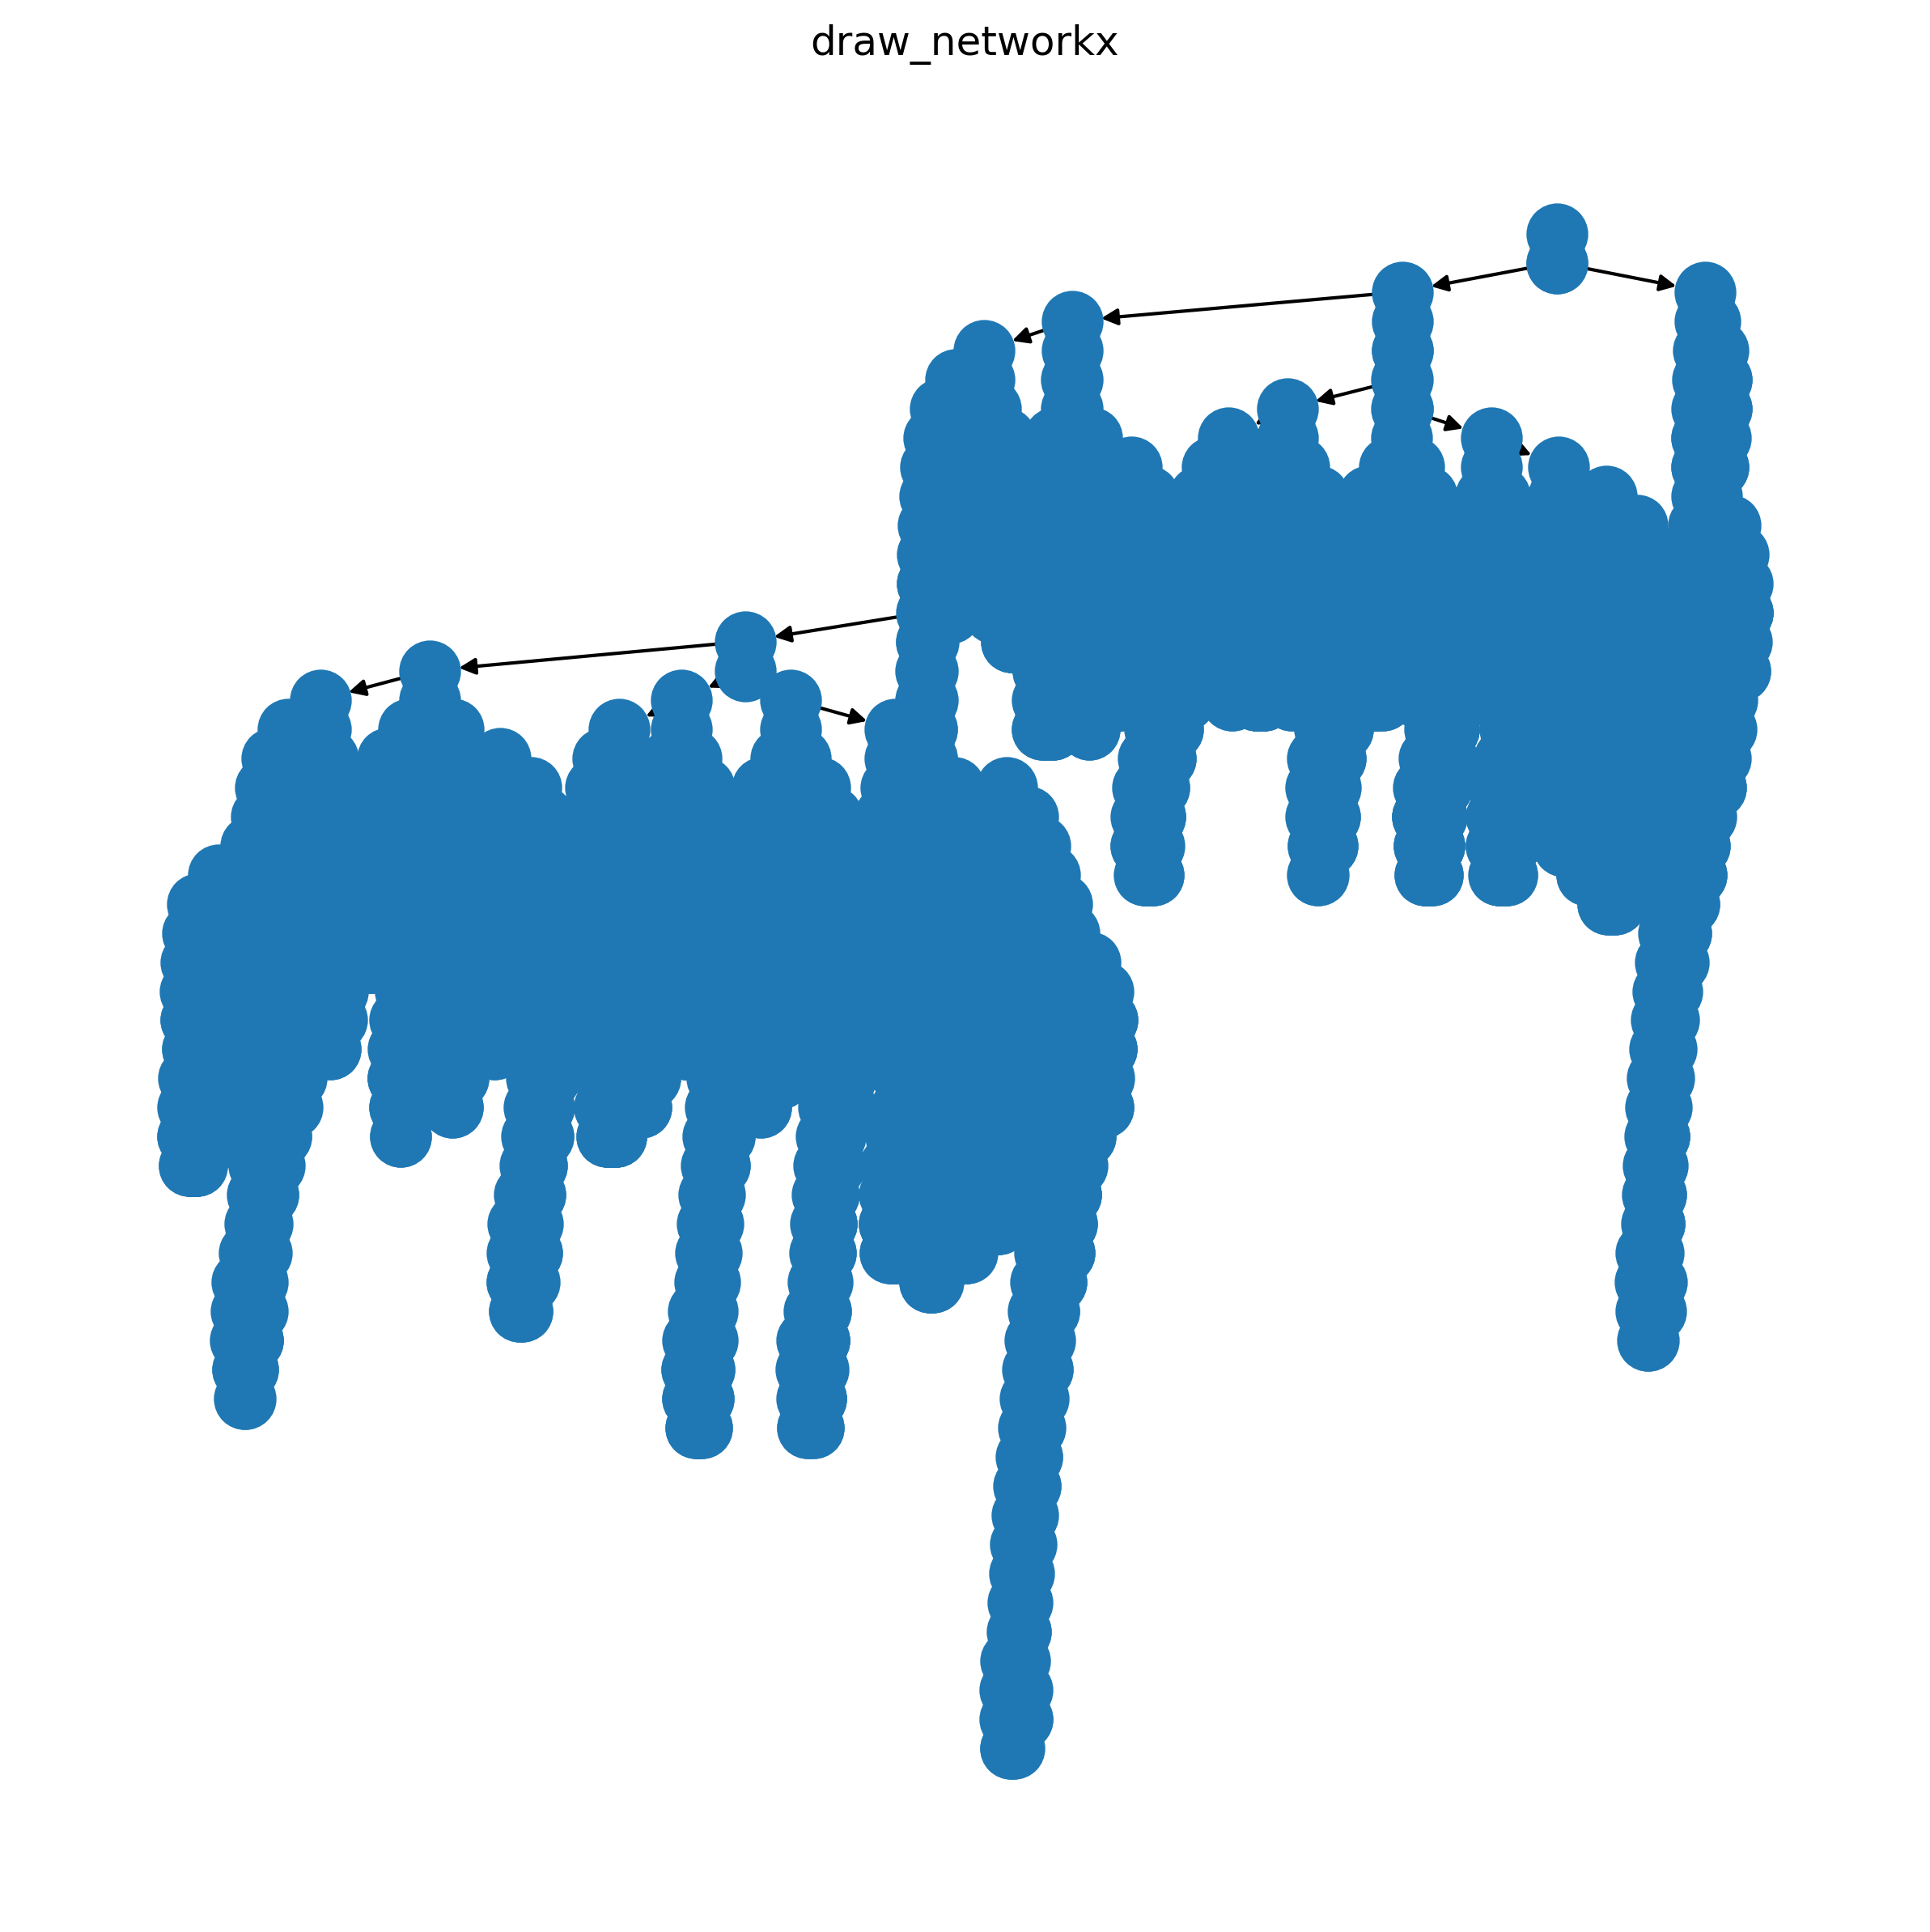

In [20]:
G = nx.DiGraph()
G.add_nodes_from(cas_tree.nodes)
G.add_edges_from(cas_tree.edges)
G

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"

f = plt.figure(figsize=(10,10), dpi=300)
write_dot(G,join(outdir, f'{name}_hybrid.dot'))


# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos = graphviz_layout(G, prog='dot', root=cas_tree.root)
nx.draw(G, pos, with_labels=False, arrows=True)

# color_map = []
# for node in G:
#     if node < 10:
#         color_map.append('blue')
#     else: 
#         color_map.append('green')
# nx.draw(G, pos, node_color=color_map, with_labels=False)


plt.savefig(join(outdir, f'{name}_hybrid.png'))


In [49]:
len(cas_tree.edges)

16273

## Plot with itol (only with valid itol account)

In [ ]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_hybrid_tree", export_filepath="example_hybrid_tree.png")


In [22]:
G.nodes()

NodeView(('cassiopeia_internal_nodea4d3bbe92c10f62c59a3e173', 'cassiopeia_internal_nodef6e8b301687592d883abe7e7', 'cassiopeia_internal_node17a163be24da8d4ac41be23b', 'cassiopeia_internal_node11d735a469b4a72eaec31e1e', 'cassiopeia_internal_noded00ca7dd044b9499d88f772d', 'cassiopeia_internal_node64d779a03982fe96e9081d21', 'cassiopeia_internal_nodee6750f60e5b53effe944746b', 'cassiopeia_internal_nodee53bf528048490cd05f533b4', 'cassiopeia_internal_node2463bbdc5b164069d6e5e931', 'cassiopeia_internal_node572a1c7feaca40ebdd5b29fc', 'cassiopeia_internal_node723c15911e9404c432b28298', 'cassiopeia_internal_node646d2ec5fe6a50f20a41350d', 'cassiopeia_internal_node06d8d5f2b91d94a17f537180', 'cassiopeia_internal_node7f3c26ba9d59f15b73ea1922', 'cassiopeia_internal_nodec25aa689fe74811cc2fe0d9b', 'cassiopeia_internal_nodee57e05ea2571e88b7bc2a190', 'cassiopeia_internal_nodec56a7fe6b005a5709d2c2638', 'cassiopeia_internal_node4ceb472307bb926943b0cf53', 'cassiopeia_internal_node9139b292b6f3d5a2dd391afe', 'c

In [25]:
nx.number_of_edges(G)

16273

In [26]:
nx.number_of_nodes(G)

16274

In [27]:
nx.is_weighted(G)

False

In [35]:
print(f"#cells in tree: {sum(map(lambda x: 'cassiopeia' in x, list(G.nodes())))}")

#cells in tree: 6223


## get distance between cells

In [54]:
dist_mat = pd.DataFrame(index=cas_tree.character_matrix.index, columns=cas_tree.character_matrix.index)
cells = cas_tree.character_matrix.index
n_cells = len(cells)
no_path = []
G_un = G.to_undirected(reciprocal=False)
for i, c1 in enumerate(cells[:-1]):
    print("i", i)
    for j in range(i+1, n_cells):
        print(j)
        c2 = cells[j]
        print(c1, c2)
        try:  
            dist_mat.loc[i,j] = nx.shortest_path_length(G_un, c1, c2)
        except nx.NetworkXNoPath:
            no_path.append([i,j])
no_path

i 0
1
AAACGAAAGAACAGGA-1 AAACGAAAGATTGACA-1
2
AAACGAAAGAACAGGA-1 AAACGAAAGCGTTGCC-1
3
AAACGAAAGAACAGGA-1 AAACGAAAGGTACTCT-1
4
AAACGAAAGAACAGGA-1 AAACGAAAGGTTAACA-1
5
AAACGAAAGAACAGGA-1 AAACGAAAGTAGAAGG-1
6
AAACGAAAGAACAGGA-1 AAACGAAAGTAGTGTA-1
7
AAACGAAAGAACAGGA-1 AAACGAAAGTATCTGC-1
8
AAACGAAAGAACAGGA-1 AAACGAAAGTGCTAGG-1
9
AAACGAAAGAACAGGA-1 AAACGAACAAGCACTT-1
10
AAACGAAAGAACAGGA-1 AAACGAACAAGGCTTT-1
11
AAACGAAAGAACAGGA-1 AAACGAACACATAAAG-1
12
AAACGAAAGAACAGGA-1 AAACGAACACCGTCTT-1
13
AAACGAAAGAACAGGA-1 AAACGAACACGCGACT-1
14
AAACGAAAGAACAGGA-1 AAACGAACATAGAATG-1
15
AAACGAAAGAACAGGA-1 AAACGAACATCCCAAA-1
16
AAACGAAAGAACAGGA-1 AAACGAAGTACAAGCG-1
17
AAACGAAAGAACAGGA-1 AAACGAAGTATCGCGC-1
18
AAACGAAAGAACAGGA-1 AAACGAAGTCCCGTGA-1
19
AAACGAAAGAACAGGA-1 AAACGAAGTCGGCTGT-1
20
AAACGAAAGAACAGGA-1 AAACGAAGTTATCGAC-1
21
AAACGAAAGAACAGGA-1 AAACGAAGTTTCAGCA-1
22
AAACGAAAGAACAGGA-1 AAACGAATCATCATGG-1
23
AAACGAAAGAACAGGA-1 AAACGAATCCTCATTA-1
24
AAACGAAAGAACAGGA-1 AAACGAATCGGGAATG-1
25
AAACGAAAGAACAGGA-1

213
AAACGAAAGAACAGGA-1 AACAGTCCAAGCCAGA-1
214
AAACGAAAGAACAGGA-1 AACAGTCCAATGGCAG-1
215
AAACGAAAGAACAGGA-1 AACAGTCCACCTCGTT-1
216
AAACGAAAGAACAGGA-1 AACAGTCCACGCTAAT-1
217
AAACGAAAGAACAGGA-1 AACAGTCCAGGGTAAC-1
218
AAACGAAAGAACAGGA-1 AACAGTCCATCTCTCG-1
219
AAACGAAAGAACAGGA-1 AACAGTCCATGGATGG-1
220
AAACGAAAGAACAGGA-1 AACAGTCCATGGGTGA-1
221
AAACGAAAGAACAGGA-1 AACAGTCGTACATGGG-1
222
AAACGAAAGAACAGGA-1 AACAGTCGTCCAGACC-1
223
AAACGAAAGAACAGGA-1 AACAGTCGTCCCTTTG-1
224
AAACGAAAGAACAGGA-1 AACAGTCGTCCGTCGA-1
225
AAACGAAAGAACAGGA-1 AACAGTCGTGAATGGC-1
226
AAACGAAAGAACAGGA-1 AACAGTCTCATCGCCT-1
227
AAACGAAAGAACAGGA-1 AACAGTCTCGGGATCC-1
228
AAACGAAAGAACAGGA-1 AACAGTCTCTCTTAAC-1
229
AAACGAAAGAACAGGA-1 AACATCGAGACCGCAA-1
230
AAACGAAAGAACAGGA-1 AACATCGAGTAATGTG-1
231
AAACGAAAGAACAGGA-1 AACATCGAGTAGTCGG-1
232
AAACGAAAGAACAGGA-1 AACATCGAGTATAGTG-1
233
AAACGAAAGAACAGGA-1 AACATCGAGTGTCGGA-1
234
AAACGAAAGAACAGGA-1 AACATCGAGTTCTCCC-1
235
AAACGAAAGAACAGGA-1 AACATCGCAACATAAG-1
236
AAACGAAAGAACAGGA-1 AACATCGCAAG

413
AAACGAAAGAACAGGA-1 AACTGGTTCGCTTCAC-1
414
AAACGAAAGAACAGGA-1 AACTGGTTCGCTTGAA-1
415
AAACGAAAGAACAGGA-1 AACTGGTTCGGAGTTT-1
416
AAACGAAAGAACAGGA-1 AACTGGTTCTGTCGGG-1
417
AAACGAAAGAACAGGA-1 AACTGTGAGAGAGGTA-1
418
AAACGAAAGAACAGGA-1 AACTGTGAGAGAGTTT-1
419
AAACGAAAGAACAGGA-1 AACTGTGAGCAGGAGG-1
420
AAACGAAAGAACAGGA-1 AACTGTGAGCGAGAAA-1
421
AAACGAAAGAACAGGA-1 AACTGTGAGGGTATCG-1
422
AAACGAAAGAACAGGA-1 AACTGTGAGTCGAGCA-1
423
AAACGAAAGAACAGGA-1 AACTGTGCACAAGTGG-1
424
AAACGAAAGAACAGGA-1 AACTGTGCACACACAT-1
425
AAACGAAAGAACAGGA-1 AACTGTGCACATAAAG-1
426
AAACGAAAGAACAGGA-1 AACTGTGCACGCGTTG-1
427
AAACGAAAGAACAGGA-1 AACTGTGCAGGGCTTC-1
428
AAACGAAAGAACAGGA-1 AACTGTGGTAAAGCTA-1
429
AAACGAAAGAACAGGA-1 AACTGTGGTAGCAGCA-1
430
AAACGAAAGAACAGGA-1 AACTGTGGTATGCTAC-1
431
AAACGAAAGAACAGGA-1 AACTGTGGTATTTGCG-1
432
AAACGAAAGAACAGGA-1 AACTGTGGTCAACGGA-1
433
AAACGAAAGAACAGGA-1 AACTGTGGTCCAACCG-1
434
AAACGAAAGAACAGGA-1 AACTGTGTCCAACAAC-1
435
AAACGAAAGAACAGGA-1 AACTGTGTCCAATCCC-1
436
AAACGAAAGAACAGGA-1 AACTGTGTCCC

612
AAACGAAAGAACAGGA-1 AATGGCTAGGTTACAA-1
613
AAACGAAAGAACAGGA-1 AATGGCTAGGTTCTCA-1
614
AAACGAAAGAACAGGA-1 AATGGCTAGTAGTCGG-1
615
AAACGAAAGAACAGGA-1 AATGGCTAGTATGCTC-1
616
AAACGAAAGAACAGGA-1 AATGGCTCAAAGGTCG-1
617
AAACGAAAGAACAGGA-1 AATGGCTCAACTCCCT-1
618
AAACGAAAGAACAGGA-1 AATGGCTCACTCCACT-1
619
AAACGAAAGAACAGGA-1 AATGGCTCACTCCTCA-1
620
AAACGAAAGAACAGGA-1 AATGGCTCAGCAAACG-1
621
AAACGAAAGAACAGGA-1 AATGGCTGTACTTGAC-1
622
AAACGAAAGAACAGGA-1 AATGGCTGTATTCTCT-1
623
AAACGAAAGAACAGGA-1 AATGGCTGTGACAAGC-1
624
AAACGAAAGAACAGGA-1 AATGGCTGTGATGCTT-1
625
AAACGAAAGAACAGGA-1 AATGGCTGTTAACCAC-1
626
AAACGAAAGAACAGGA-1 AATGGCTGTTGAAGCG-1
627
AAACGAAAGAACAGGA-1 AATGGCTTCAAACCCA-1
628
AAACGAAAGAACAGGA-1 AATGGCTTCATTCTCA-1
629
AAACGAAAGAACAGGA-1 AATGGCTTCCTCCAGT-1
630
AAACGAAAGAACAGGA-1 AATGGCTTCCTGTAGA-1
631
AAACGAAAGAACAGGA-1 AATGGCTTCTGACATG-1
632
AAACGAAAGAACAGGA-1 AATGTCGAGCCCATTA-1
633
AAACGAAAGAACAGGA-1 AATGTCGAGCTGGAGT-1
634
AAACGAAAGAACAGGA-1 AATGTCGAGGCCAGTA-1
635
AAACGAAAGAACAGGA-1 AATGTCGAGTA

810
AAACGAAAGAACAGGA-1 ACAGCGCGTCTGCACG-1
811
AAACGAAAGAACAGGA-1 ACAGCGCGTGAGTTGG-1
812
AAACGAAAGAACAGGA-1 ACAGCGCGTGATCAGG-1
813
AAACGAAAGAACAGGA-1 ACAGCGCGTGGACCAA-1
814
AAACGAAAGAACAGGA-1 ACAGCGCGTGTCGTGC-1
815
AAACGAAAGAACAGGA-1 ACAGCGCGTTCATTTC-1
816
AAACGAAAGAACAGGA-1 ACAGCGCTCCTCCTGA-1
817
AAACGAAAGAACAGGA-1 ACAGCGCTCGAGAACG-1
818
AAACGAAAGAACAGGA-1 ACAGCGCTCTTACCTA-1
819
AAACGAAAGAACAGGA-1 ACAGGCCAGAACTAAC-1
820
AAACGAAAGAACAGGA-1 ACAGGCCAGCTACGCC-1
821
AAACGAAAGAACAGGA-1 ACAGGCCAGGATTGAT-1
822
AAACGAAAGAACAGGA-1 ACAGGCCAGGCTTCGC-1
823
AAACGAAAGAACAGGA-1 ACAGGCCAGTAGACCG-1
824
AAACGAAAGAACAGGA-1 ACAGGCCAGTAGTTCC-1
825
AAACGAAAGAACAGGA-1 ACAGGCCCAATGGCAG-1
826
AAACGAAAGAACAGGA-1 ACAGGCCCACACATGT-1
827
AAACGAAAGAACAGGA-1 ACAGGCCCACTCCACT-1
828
AAACGAAAGAACAGGA-1 ACAGGCCCAGAATGCG-1
829
AAACGAAAGAACAGGA-1 ACAGGCCCAGCACATT-1
830
AAACGAAAGAACAGGA-1 ACAGGCCCAGTATACC-1
831
AAACGAAAGAACAGGA-1 ACAGGCCCATATAGAG-1
832
AAACGAAAGAACAGGA-1 ACAGGCCCATCAGCTA-1
833
AAACGAAAGAACAGGA-1 ACAGGCCGTCC

1006
AAACGAAAGAACAGGA-1 ACGGATTGTATGTCCA-1
1007
AAACGAAAGAACAGGA-1 ACGGATTGTCGAGAAC-1
1008
AAACGAAAGAACAGGA-1 ACGGATTGTGACAAGC-1
1009
AAACGAAAGAACAGGA-1 ACGGATTGTGCGACCT-1
1010
AAACGAAAGAACAGGA-1 ACGGATTGTGCTTACA-1
1011
AAACGAAAGAACAGGA-1 ACGGATTGTGCTTGAT-1
1012
AAACGAAAGAACAGGA-1 ACGGATTGTTGGCTAT-1
1013
AAACGAAAGAACAGGA-1 ACGGATTGTTTAAGGA-1
1014
AAACGAAAGAACAGGA-1 ACGGATTTCACATTCT-1
1015
AAACGAAAGAACAGGA-1 ACGGATTTCCTCTCTT-1
1016
AAACGAAAGAACAGGA-1 ACGGATTTCGCTATAG-1
1017
AAACGAAAGAACAGGA-1 ACGTGGCAGAACGTTA-1
1018
AAACGAAAGAACAGGA-1 ACGTGGCAGACTCGGA-1
1019
AAACGAAAGAACAGGA-1 ACGTGGCAGCGTTAGG-1
1020
AAACGAAAGAACAGGA-1 ACGTGGCAGGAAGAAC-1
1021
AAACGAAAGAACAGGA-1 ACGTGGCAGGTTCGTT-1
1022
AAACGAAAGAACAGGA-1 ACGTGGCAGTAGTGTA-1
1023
AAACGAAAGAACAGGA-1 ACGTGGCAGTAGTTCC-1
1024
AAACGAAAGAACAGGA-1 ACGTGGCAGTGTTCCA-1
1025
AAACGAAAGAACAGGA-1 ACGTGGCCAAATGTCC-1
1026
AAACGAAAGAACAGGA-1 ACGTGGCCAAGTTCGT-1
1027
AAACGAAAGAACAGGA-1 ACGTGGCCAATCACTG-1
1028
AAACGAAAGAACAGGA-1 ACGTGGCCAATTCGTG-1
1029
AAACGA

1198
AAACGAAAGAACAGGA-1 ACTGCAAGTCATAGAA-1
1199
AAACGAAAGAACAGGA-1 ACTGCAAGTCGCTACG-1
1200
AAACGAAAGAACAGGA-1 ACTGCAAGTCTAAAGA-1
1201
AAACGAAAGAACAGGA-1 ACTGCAAGTCTAACCA-1
1202
AAACGAAAGAACAGGA-1 ACTGCAAGTGCATTCA-1
1203
AAACGAAAGAACAGGA-1 ACTGCAAGTGGCCTTG-1
1204
AAACGAAAGAACAGGA-1 ACTGCAAGTGTTAGAA-1
1205
AAACGAAAGAACAGGA-1 ACTGCAAGTTCCCTTG-1
1206
AAACGAAAGAACAGGA-1 ACTGCAAGTTTGTACG-1
1207
AAACGAAAGAACAGGA-1 ACTGCAATCCAGAATC-1
1208
AAACGAAAGAACAGGA-1 ACTGCAATCCTATCAT-1
1209
AAACGAAAGAACAGGA-1 ACTGCAATCGACTATG-1
1210
AAACGAAAGAACAGGA-1 ACTGCAATCGCTCGGA-1
1211
AAACGAAAGAACAGGA-1 ACTGCAATCTGGAAGG-1
1212
AAACGAAAGAACAGGA-1 ACTGCAATCTGGACAT-1
1213
AAACGAAAGAACAGGA-1 ACTGCAATCTTAATCC-1
1214
AAACGAAAGAACAGGA-1 ACTGCAATCTTACTCA-1
1215
AAACGAAAGAACAGGA-1 ACTGCGGAGGGAAATG-1
1216
AAACGAAAGAACAGGA-1 ACTGCGGAGTCGAAAT-1
1217
AAACGAAAGAACAGGA-1 ACTGCGGAGTCGGGAT-1
1218
AAACGAAAGAACAGGA-1 ACTGCGGAGTCTCCAA-1
1219
AAACGAAAGAACAGGA-1 ACTGCGGCAAGTAACA-1
1220
AAACGAAAGAACAGGA-1 ACTGCGGCAATTCAGC-1
1221
AAACGA

1390
AAACGAAAGAACAGGA-1 AGCCGCAAGCAGGACT-1
1391
AAACGAAAGAACAGGA-1 AGCCGCAAGGGTTCTT-1
1392
AAACGAAAGAACAGGA-1 AGCCGCAAGTCCGATT-1
1393
AAACGAAAGAACAGGA-1 AGCCGCAAGTGCTCGC-1
1394
AAACGAAAGAACAGGA-1 AGCCGCAAGTGTCCCG-1
1395
AAACGAAAGAACAGGA-1 AGCCGCACAACTAGAA-1
1396
AAACGAAAGAACAGGA-1 AGCCGCACAACTGCGC-1
1397
AAACGAAAGAACAGGA-1 AGCCGCACAAGCGAAC-1
1398
AAACGAAAGAACAGGA-1 AGCCGCACAGAACTTC-1
1399
AAACGAAAGAACAGGA-1 AGCCGCACAGAGATGC-1
1400
AAACGAAAGAACAGGA-1 AGCCGCACAGCAACCC-1
1401
AAACGAAAGAACAGGA-1 AGCCGCACAGTAGTTC-1
1402
AAACGAAAGAACAGGA-1 AGCCGCACAGTGCTCG-1
1403
AAACGAAAGAACAGGA-1 AGCCGCACATCGACCG-1
1404
AAACGAAAGAACAGGA-1 AGCCGCACATGGAGGT-1
1405
AAACGAAAGAACAGGA-1 AGCCGCAGTAACTCCA-1
1406
AAACGAAAGAACAGGA-1 AGCCGCAGTTAAGTCC-1
1407
AAACGAAAGAACAGGA-1 AGCCGCATCCACCTAC-1
1408
AAACGAAAGAACAGGA-1 AGCCGCATCCAGTACA-1
1409
AAACGAAAGAACAGGA-1 AGCCGCATCTATCCTA-1
1410
AAACGAAAGAACAGGA-1 AGCCGCATCTTTATCG-1
1411
AAACGAAAGAACAGGA-1 AGCCTCTAGAACCCGA-1
1412
AAACGAAAGAACAGGA-1 AGCCTCTAGCAGAATT-1
1413
AAACGA

1582
AAACGAAAGAACAGGA-1 AGCTGATCACCGATCG-1
1583
AAACGAAAGAACAGGA-1 AGCTGATCAGGTGTGA-1
1584
AAACGAAAGAACAGGA-1 AGCTGATCAGTAACCT-1
1585
AAACGAAAGAACAGGA-1 AGCTGATCATCATGTG-1
1586
AAACGAAAGAACAGGA-1 AGCTGATCATGCGCTG-1
1587
AAACGAAAGAACAGGA-1 AGCTGATGTAGTATCC-1
1588
AAACGAAAGAACAGGA-1 AGCTGATGTAGTGATA-1
1589
AAACGAAAGAACAGGA-1 AGCTGATGTATACGCT-1
1590
AAACGAAAGAACAGGA-1 AGCTGATGTCCGTGCA-1
1591
AAACGAAAGAACAGGA-1 AGCTGATGTCGGCTGT-1
1592
AAACGAAAGAACAGGA-1 AGCTGATGTGGACGAT-1
1593
AAACGAAAGAACAGGA-1 AGCTGATGTTAGTAGA-1
1594
AAACGAAAGAACAGGA-1 AGCTGATTCACTAGGT-1
1595
AAACGAAAGAACAGGA-1 AGCTGATTCAGTCACA-1
1596
AAACGAAAGAACAGGA-1 AGCTGATTCCACGGCA-1
1597
AAACGAAAGAACAGGA-1 AGCTGATTCCGCGATG-1
1598
AAACGAAAGAACAGGA-1 AGCTGATTCCGCTCTA-1
1599
AAACGAAAGAACAGGA-1 AGCTGATTCCTTTGCG-1
1600
AAACGAAAGAACAGGA-1 AGCTGATTCTCCAACC-1
1601
AAACGAAAGAACAGGA-1 AGCTGATTCTCGGCGA-1
1602
AAACGAAAGAACAGGA-1 AGCTGGCAGCCATTCA-1
1603
AAACGAAAGAACAGGA-1 AGCTGGCAGTGAAGGA-1
1604
AAACGAAAGAACAGGA-1 AGCTGGCAGTGATATG-1
1605
AAACGA

1774
AAACGAAAGAACAGGA-1 AGTCCGGGTCGCGCTA-1
1775
AAACGAAAGAACAGGA-1 AGTCCGGGTGAGTCGA-1
1776
AAACGAAAGAACAGGA-1 AGTCCGGGTGTAGGAC-1
1777
AAACGAAAGAACAGGA-1 AGTCCGGTCGATGTAC-1
1778
AAACGAAAGAACAGGA-1 AGTCCGGTCGGTACTA-1
1779
AAACGAAAGAACAGGA-1 AGTGCCGCAACCTCTC-1
1780
AAACGAAAGAACAGGA-1 AGTGCCGCACACACCG-1
1781
AAACGAAAGAACAGGA-1 AGTGCCGCACAGTTCA-1
1782
AAACGAAAGAACAGGA-1 AGTGCCGCAGGTGTGA-1
1783
AAACGAAAGAACAGGA-1 AGTGCCGCAGTAACCT-1
1784
AAACGAAAGAACAGGA-1 AGTGCCGCATATACGC-1
1785
AAACGAAAGAACAGGA-1 AGTGCCGCATCCGTAA-1
1786
AAACGAAAGAACAGGA-1 AGTGCCGGTCTAAAGA-1
1787
AAACGAAAGAACAGGA-1 AGTGCCGGTGGACTGA-1
1788
AAACGAAAGAACAGGA-1 AGTGCCGTCCTGACCT-1
1789
AAACGAAAGAACAGGA-1 AGTGCCGTCCTTCGAC-1
1790
AAACGAAAGAACAGGA-1 AGTGCCGTCTATCTCA-1
1791
AAACGAAAGAACAGGA-1 AGTGCCGTCTTTCGAT-1
1792
AAACGAAAGAACAGGA-1 AGTGCGCAGCAGAAAG-1
1793
AAACGAAAGAACAGGA-1 AGTGCGCAGGAATGGA-1
1794
AAACGAAAGAACAGGA-1 AGTGCGCAGTGTCGCC-1
1795
AAACGAAAGAACAGGA-1 AGTGCGCAGTTCAGGG-1
1796
AAACGAAAGAACAGGA-1 AGTGCGCCAATACTGC-1
1797
AAACGA

1966
AAACGAAAGAACAGGA-1 ATCCCTGGTGGGTAGT-1
1967
AAACGAAAGAACAGGA-1 ATCCCTGGTTACTTTC-1
1968
AAACGAAAGAACAGGA-1 ATCCCTGGTTAGTAGA-1
1969
AAACGAAAGAACAGGA-1 ATCCCTGGTTTCGATG-1
1970
AAACGAAAGAACAGGA-1 ATCCCTGTCATGAACC-1
1971
AAACGAAAGAACAGGA-1 ATCCCTGTCCACGAGC-1
1972
AAACGAAAGAACAGGA-1 ATCCCTGTCGATGAAA-1
1973
AAACGAAAGAACAGGA-1 ATCCCTGTCGCCACTT-1
1974
AAACGAAAGAACAGGA-1 ATCCCTGTCGCTATTT-1
1975
AAACGAAAGAACAGGA-1 ATCCCTGTCGGGATCC-1
1976
AAACGAAAGAACAGGA-1 ATCCCTGTCGTGATAC-1
1977
AAACGAAAGAACAGGA-1 ATCCCTGTCGTTGTTT-1
1978
AAACGAAAGAACAGGA-1 ATCCCTGTCTCCAACC-1
1979
AAACGAAAGAACAGGA-1 ATCCTCGAGATCGATA-1
1980
AAACGAAAGAACAGGA-1 ATCCTCGAGATCGCCC-1
1981
AAACGAAAGAACAGGA-1 ATCCTCGAGCTCGGCT-1
1982
AAACGAAAGAACAGGA-1 ATCCTCGAGTCGAGCA-1
1983
AAACGAAAGAACAGGA-1 ATCCTCGCAACGTCCG-1
1984
AAACGAAAGAACAGGA-1 ATCCTCGCACACATTG-1
1985
AAACGAAAGAACAGGA-1 ATCCTCGCACTAGCCG-1
1986
AAACGAAAGAACAGGA-1 ATCCTCGCAGACCTGC-1
1987
AAACGAAAGAACAGGA-1 ATCCTCGCAGACTAAA-1
1988
AAACGAAAGAACAGGA-1 ATCCTCGCAGAGCCAA-1
1989
AAACGA

2158
AAACGAAAGAACAGGA-1 ATTACCTCAGAACGAC-1
2159
AAACGAAAGAACAGGA-1 ATTACCTCAGTAACCT-1
2160
AAACGAAAGAACAGGA-1 ATTACCTCATGCTATG-1
2161
AAACGAAAGAACAGGA-1 ATTACCTGTAAACCCT-1
2162
AAACGAAAGAACAGGA-1 ATTACCTGTAACCGAG-1
2163
AAACGAAAGAACAGGA-1 ATTACCTGTATGGGTG-1
2164
AAACGAAAGAACAGGA-1 ATTACCTGTCATTGCA-1
2165
AAACGAAAGAACAGGA-1 ATTACCTGTGAATGGC-1
2166
AAACGAAAGAACAGGA-1 ATTACCTGTTCCATCC-1
2167
AAACGAAAGAACAGGA-1 ATTACCTGTTCCCAAA-1
2168
AAACGAAAGAACAGGA-1 ATTACCTGTTGGTAAA-1
2169
AAACGAAAGAACAGGA-1 ATTACCTGTTTCTACT-1
2170
AAACGAAAGAACAGGA-1 ATTACCTTCAATCGTG-1
2171
AAACGAAAGAACAGGA-1 ATTACCTTCACTAGGT-1
2172
AAACGAAAGAACAGGA-1 ATTACCTTCACTTACT-1
2173
AAACGAAAGAACAGGA-1 ATTACCTTCAGTCAAC-1
2174
AAACGAAAGAACAGGA-1 ATTACCTTCATCATGG-1
2175
AAACGAAAGAACAGGA-1 ATTACCTTCCATACCC-1
2176
AAACGAAAGAACAGGA-1 ATTACCTTCCATCATT-1
2177
AAACGAAAGAACAGGA-1 ATTACCTTCGTGCTGG-1
2178
AAACGAAAGAACAGGA-1 ATTACCTTCGTGGAAG-1
2179
AAACGAAAGAACAGGA-1 ATTACTCAGAATATCG-1
2180
AAACGAAAGAACAGGA-1 ATTACTCAGGAGTCTG-1
2181
AAACGA

2349
AAACGAAAGAACAGGA-1 CAACGGCCACTGCTCT-1
2350
AAACGAAAGAACAGGA-1 CAACGGCCAGGTTATC-1
2351
AAACGAAAGAACAGGA-1 CAACGGCGTAACGGAC-1
2352
AAACGAAAGAACAGGA-1 CAACGGCGTCCCGTGA-1
2353
AAACGAAAGAACAGGA-1 CAACGGCGTCGAGGTA-1
2354
AAACGAAAGAACAGGA-1 CAACGGCGTCTCTGCT-1
2355
AAACGAAAGAACAGGA-1 CAACGGCGTGCGACCT-1
2356
AAACGAAAGAACAGGA-1 CAACGGCTCCAGTTAG-1
2357
AAACGAAAGAACAGGA-1 CAACGGCTCGCACCTT-1
2358
AAACGAAAGAACAGGA-1 CAACGGCTCGCATACA-1
2359
AAACGAAAGAACAGGA-1 CAACGGCTCGCTATTT-1
2360
AAACGAAAGAACAGGA-1 CAACGTAAGAAAGCAG-1
2361
AAACGAAAGAACAGGA-1 CAACGTAAGAGCCTGA-1
2362
AAACGAAAGAACAGGA-1 CAACGTAAGATACCAA-1
2363
AAACGAAAGAACAGGA-1 CAACGTAAGGAAGACA-1
2364
AAACGAAAGAACAGGA-1 CAACGTAAGGGAAATG-1
2365
AAACGAAAGAACAGGA-1 CAACGTAAGTATACCC-1
2366
AAACGAAAGAACAGGA-1 CAACGTAAGTCCTTCC-1
2367
AAACGAAAGAACAGGA-1 CAACGTAAGTCGTACT-1
2368
AAACGAAAGAACAGGA-1 CAACGTAAGTGAGTTA-1
2369
AAACGAAAGAACAGGA-1 CAACGTAAGTTGGAAT-1
2370
AAACGAAAGAACAGGA-1 CAACGTACAACAACTC-1
2371
AAACGAAAGAACAGGA-1 CAACGTACAACTGCGC-1
2372
AAACGA

2541
AAACGAAAGAACAGGA-1 CACCACTTCCCGCAAG-1
2542
AAACGAAAGAACAGGA-1 CACCACTTCGCACCTT-1
2543
AAACGAAAGAACAGGA-1 CACCTGTAGAAGGGCG-1
2544
AAACGAAAGAACAGGA-1 CACCTGTAGAGCTGTG-1
2545
AAACGAAAGAACAGGA-1 CACCTGTAGCCAGAAC-1
2546
AAACGAAAGAACAGGA-1 CACCTGTAGCCTGTAT-1
2547
AAACGAAAGAACAGGA-1 CACCTGTAGCTGCCAC-1
2548
AAACGAAAGAACAGGA-1 CACCTGTAGGAAGAAC-1
2549
AAACGAAAGAACAGGA-1 CACCTGTAGTATGGGC-1
2550
AAACGAAAGAACAGGA-1 CACCTGTCAAGCACTT-1
2551
AAACGAAAGAACAGGA-1 CACCTGTCAATGGCTT-1
2552
AAACGAAAGAACAGGA-1 CACCTGTCACAACGGA-1
2553
AAACGAAAGAACAGGA-1 CACCTGTCACGATTAC-1
2554
AAACGAAAGAACAGGA-1 CACCTGTCACGCGTTG-1
2555
AAACGAAAGAACAGGA-1 CACCTGTCAGGGTAAC-1
2556
AAACGAAAGAACAGGA-1 CACCTGTCATCGACCG-1
2557
AAACGAAAGAACAGGA-1 CACCTGTCATTTGGCA-1
2558
AAACGAAAGAACAGGA-1 CACCTGTGTAGATTAG-1
2559
AAACGAAAGAACAGGA-1 CACCTGTGTATTTGCG-1
2560
AAACGAAAGAACAGGA-1 CACCTGTGTCACAGGA-1
2561
AAACGAAAGAACAGGA-1 CACCTGTGTGGTGGTA-1
2562
AAACGAAAGAACAGGA-1 CACCTGTGTGTGCTTA-1
2563
AAACGAAAGAACAGGA-1 CACCTGTTCACTCCCA-1
2564
AAACGA

2733
AAACGAAAGAACAGGA-1 CAGGGCTAGTAGTTCC-1
2734
AAACGAAAGAACAGGA-1 CAGGGCTCAACAAACA-1
2735
AAACGAAAGAACAGGA-1 CAGGGCTCACAGCCAC-1
2736
AAACGAAAGAACAGGA-1 CAGGGCTCAGCAGGTA-1
2737
AAACGAAAGAACAGGA-1 CAGGGCTCATCATAGC-1
2738
AAACGAAAGAACAGGA-1 CAGGGCTGTAACTCCA-1
2739
AAACGAAAGAACAGGA-1 CAGGGCTGTATTCTCT-1
2740
AAACGAAAGAACAGGA-1 CAGGGCTGTGAAACAT-1
2741
AAACGAAAGAACAGGA-1 CAGGGCTGTTCAGAAA-1
2742
AAACGAAAGAACAGGA-1 CAGGGCTGTTCCAATG-1
2743
AAACGAAAGAACAGGA-1 CAGGGCTTCAATTCCT-1
2744
AAACGAAAGAACAGGA-1 CAGGGCTTCCAATAGC-1
2745
AAACGAAAGAACAGGA-1 CAGGGCTTCCATCATT-1
2746
AAACGAAAGAACAGGA-1 CAGGGCTTCGTGGTAT-1
2747
AAACGAAAGAACAGGA-1 CAGTATGAGCCATTCA-1
2748
AAACGAAAGAACAGGA-1 CAGTATGAGGTCACTT-1
2749
AAACGAAAGAACAGGA-1 CAGTATGCAAGCAGGT-1
2750
AAACGAAAGAACAGGA-1 CAGTATGCAGGCATTT-1
2751
AAACGAAAGAACAGGA-1 CAGTATGCAGGTCCTG-1
2752
AAACGAAAGAACAGGA-1 CAGTATGGTCATTGCA-1
2753
AAACGAAAGAACAGGA-1 CAGTATGGTTACGGAG-1
2754
AAACGAAAGAACAGGA-1 CAGTATGGTTCAGTTG-1
2755
AAACGAAAGAACAGGA-1 CAGTATGGTTCCGCGA-1
2756
AAACGA

2924
AAACGAAAGAACAGGA-1 CATTGGACAGCACATT-1
2925
AAACGAAAGAACAGGA-1 CATTGGACAGTCCTGG-1
2926
AAACGAAAGAACAGGA-1 CATTGGACATCGTGAT-1
2927
AAACGAAAGAACAGGA-1 CATTGGAGTATCACAC-1
2928
AAACGAAAGAACAGGA-1 CATTGGAGTCAACAGG-1
2929
AAACGAAAGAACAGGA-1 CATTGGAGTCACTCTC-1
2930
AAACGAAAGAACAGGA-1 CATTGGAGTCAGAAAT-1
2931
AAACGAAAGAACAGGA-1 CATTGGAGTCAGTGCC-1
2932
AAACGAAAGAACAGGA-1 CATTGGAGTTCGGGAA-1
2933
AAACGAAAGAACAGGA-1 CATTGGAGTTTGAAGA-1
2934
AAACGAAAGAACAGGA-1 CATTGGATCATACTTC-1
2935
AAACGAAAGAACAGGA-1 CATTGGATCCCAGCGA-1
2936
AAACGAAAGAACAGGA-1 CATTGGATCCTTGACC-1
2937
AAACGAAAGAACAGGA-1 CATTGGATCGATGTAC-1
2938
AAACGAAAGAACAGGA-1 CATTGGATCGGCAATT-1
2939
AAACGAAAGAACAGGA-1 CATTGGATCTACTTTG-1
2940
AAACGAAAGAACAGGA-1 CCAATGAAGATCTAAG-1
2941
AAACGAAAGAACAGGA-1 CCAATGAAGCACGTAG-1
2942
AAACGAAAGAACAGGA-1 CCAATGAAGCTCCATA-1
2943
AAACGAAAGAACAGGA-1 CCAATGAAGTGGGACT-1
2944
AAACGAAAGAACAGGA-1 CCAATGACAACGTACT-1
2945
AAACGAAAGAACAGGA-1 CCAATGACAATGTAAG-1
2946
AAACGAAAGAACAGGA-1 CCAATGACATCCCAAA-1
2947
AAACGA

3115
AAACGAAAGAACAGGA-1 CCCGTTACAATGATGA-1
3116
AAACGAAAGAACAGGA-1 CCCGTTACACATTCTT-1
3117
AAACGAAAGAACAGGA-1 CCCGTTACACTCAGCG-1
3118
AAACGAAAGAACAGGA-1 CCCGTTACAGGATGTG-1
3119
AAACGAAAGAACAGGA-1 CCCGTTACAGGCACAA-1
3120
AAACGAAAGAACAGGA-1 CCCGTTACATTAGCAC-1
3121
AAACGAAAGAACAGGA-1 CCCGTTAGTACATGGG-1
3122
AAACGAAAGAACAGGA-1 CCCGTTAGTACCAAGG-1
3123
AAACGAAAGAACAGGA-1 CCCGTTAGTCATGAGG-1
3124
AAACGAAAGAACAGGA-1 CCCGTTAGTCTGGATT-1
3125
AAACGAAAGAACAGGA-1 CCCGTTAGTCTGGTCG-1
3126
AAACGAAAGAACAGGA-1 CCCGTTAGTGAGCTAG-1
3127
AAACGAAAGAACAGGA-1 CCCGTTAGTGAGTCGA-1
3128
AAACGAAAGAACAGGA-1 CCCGTTAGTGTTAGAA-1
3129
AAACGAAAGAACAGGA-1 CCCGTTAGTTCAGAAA-1
3130
AAACGAAAGAACAGGA-1 CCCGTTAGTTTAGAAG-1
3131
AAACGAAAGAACAGGA-1 CCCGTTAGTTTGTACG-1
3132
AAACGAAAGAACAGGA-1 CCCGTTATCACAAGCT-1
3133
AAACGAAAGAACAGGA-1 CCCGTTATCACTCGGG-1
3134
AAACGAAAGAACAGGA-1 CCCGTTATCCACGGCA-1
3135
AAACGAAAGAACAGGA-1 CCCGTTATCCGGACTG-1
3136
AAACGAAAGAACAGGA-1 CCCGTTATCGAACCGC-1
3137
AAACGAAAGAACAGGA-1 CCCGTTATCGTTACAG-1
3138
AAACGA

3306
AAACGAAAGAACAGGA-1 CCGTAGGTCTATTTCG-1
3307
AAACGAAAGAACAGGA-1 CCGTGAGAGCAACTGG-1
3308
AAACGAAAGAACAGGA-1 CCGTGAGAGCATTGGG-1
3309
AAACGAAAGAACAGGA-1 CCGTGAGAGCCAGAAC-1
3310
AAACGAAAGAACAGGA-1 CCGTGAGAGTGCCCTG-1
3311
AAACGAAAGAACAGGA-1 CCGTGAGCAACTACTG-1
3312
AAACGAAAGAACAGGA-1 CCGTGAGCAGAATGCG-1
3313
AAACGAAAGAACAGGA-1 CCGTGAGCAGTTGGAG-1
3314
AAACGAAAGAACAGGA-1 CCGTGAGCATCTCTCG-1
3315
AAACGAAAGAACAGGA-1 CCGTGAGCATGGTAAA-1
3316
AAACGAAAGAACAGGA-1 CCGTGAGCATTACTCT-1
3317
AAACGAAAGAACAGGA-1 CCGTGAGCATTCACGA-1
3318
AAACGAAAGAACAGGA-1 CCGTGAGGTATCATGC-1
3319
AAACGAAAGAACAGGA-1 CCGTGAGGTCCGCTTT-1
3320
AAACGAAAGAACAGGA-1 CCGTGAGGTGGCCTTG-1
3321
AAACGAAAGAACAGGA-1 CCGTGAGTCAAGGCAG-1
3322
AAACGAAAGAACAGGA-1 CCGTGAGTCCGTCAAA-1
3323
AAACGAAAGAACAGGA-1 CCGTGAGTCTCGCGGA-1
3324
AAACGAAAGAACAGGA-1 CCGTGAGTCTTAACGG-1
3325
AAACGAAAGAACAGGA-1 CCTAAAGAGAAAGCAG-1
3326
AAACGAAAGAACAGGA-1 CCTAAAGAGACCATAA-1
3327
AAACGAAAGAACAGGA-1 CCTAAAGAGACTCGGA-1
3328
AAACGAAAGAACAGGA-1 CCTAAAGAGCGCACAA-1
3329
AAACGA

3497
AAACGAAAGAACAGGA-1 CGAGTTAAGATCGCCC-1
3498
AAACGAAAGAACAGGA-1 CGAGTTAAGCGAGAAA-1
3499
AAACGAAAGAACAGGA-1 CGAGTTAAGCTGCCAC-1
3500
AAACGAAAGAACAGGA-1 CGAGTTAAGGAGGCGA-1
3501
AAACGAAAGAACAGGA-1 CGAGTTAAGGCCTAAG-1
3502
AAACGAAAGAACAGGA-1 CGAGTTAAGGCGATTG-1
3503
AAACGAAAGAACAGGA-1 CGAGTTAAGTTCAAGA-1
3504
AAACGAAAGAACAGGA-1 CGAGTTACACCAAGGA-1
3505
AAACGAAAGAACAGGA-1 CGAGTTACACGGCCAT-1
3506
AAACGAAAGAACAGGA-1 CGAGTTACATCCTGGG-1
3507
AAACGAAAGAACAGGA-1 CGAGTTACATGGGACA-1
3508
AAACGAAAGAACAGGA-1 CGAGTTAGTTCGGGAA-1
3509
AAACGAAAGAACAGGA-1 CGAGTTAGTTGCAGAG-1
3510
AAACGAAAGAACAGGA-1 CGAGTTAGTTTCCTAT-1
3511
AAACGAAAGAACAGGA-1 CGAGTTATCCATAACG-1
3512
AAACGAAAGAACAGGA-1 CGAGTTATCCCAATAG-1
3513
AAACGAAAGAACAGGA-1 CGAGTTATCTCGTGAA-1
3514
AAACGAAAGAACAGGA-1 CGAGTTATCTCTGCGT-1
3515
AAACGAAAGAACAGGA-1 CGAGTTATCTGTAGAC-1
3516
AAACGAAAGAACAGGA-1 CGATGATAGCCATCAT-1
3517
AAACGAAAGAACAGGA-1 CGATGATAGGTTCTCA-1
3518
AAACGAAAGAACAGGA-1 CGATGATCAACACGGA-1
3519
AAACGAAAGAACAGGA-1 CGATGATCAAGGACCA-1
3520
AAACGA

3688
AAACGAAAGAACAGGA-1 CGGACCACATGTGAGG-1
3689
AAACGAAAGAACAGGA-1 CGGACCACATTTGGTG-1
3690
AAACGAAAGAACAGGA-1 CGGACCAGTCTGCGCA-1
3691
AAACGAAAGAACAGGA-1 CGGACCAGTGAGGGTT-1
3692
AAACGAAAGAACAGGA-1 CGGACCAGTGAGTCGA-1
3693
AAACGAAAGAACAGGA-1 CGGACCAGTGATCAGG-1
3694
AAACGAAAGAACAGGA-1 CGGACCAGTGTCCTTC-1
3695
AAACGAAAGAACAGGA-1 CGGACCAGTTAGTAGA-1
3696
AAACGAAAGAACAGGA-1 CGGACCAGTTATGCAC-1
3697
AAACGAAAGAACAGGA-1 CGGACCAGTTCTGAGT-1
3698
AAACGAAAGAACAGGA-1 CGGACCATCAGGATCT-1
3699
AAACGAAAGAACAGGA-1 CGGACCATCCCAGCAG-1
3700
AAACGAAAGAACAGGA-1 CGGACCATCGTGGAAG-1
3701
AAACGAAAGAACAGGA-1 CGGACCATCTATTTCG-1
3702
AAACGAAAGAACAGGA-1 CGGACCATCTCGACAA-1
3703
AAACGAAAGAACAGGA-1 CGGACCATCTCTATTG-1
3704
AAACGAAAGAACAGGA-1 CGGACCATCTCTCAAT-1
3705
AAACGAAAGAACAGGA-1 CGGACCATCTTAATCC-1
3706
AAACGAAAGAACAGGA-1 CGGACTGAGAGCGAAA-1
3707
AAACGAAAGAACAGGA-1 CGGACTGAGATCTCAC-1
3708
AAACGAAAGAACAGGA-1 CGGACTGAGCAGGACT-1
3709
AAACGAAAGAACAGGA-1 CGGACTGAGGCTCCTG-1
3710
AAACGAAAGAACAGGA-1 CGGACTGAGGGCGAAG-1
3711
AAACGA

3879
AAACGAAAGAACAGGA-1 CTACAGAGTTGGACGA-1
3880
AAACGAAAGAACAGGA-1 CTACAGATCAGTGTGT-1
3881
AAACGAAAGAACAGGA-1 CTACAGATCATCATGG-1
3882
AAACGAAAGAACAGGA-1 CTACAGATCCCACTTG-1
3883
AAACGAAAGAACAGGA-1 CTACAGATCCCGAAGC-1
3884
AAACGAAAGAACAGGA-1 CTACAGATCGGCTATA-1
3885
AAACGAAAGAACAGGA-1 CTACAGATCGTCTTAT-1
3886
AAACGAAAGAACAGGA-1 CTACTTAAGACTAATG-1
3887
AAACGAAAGAACAGGA-1 CTACTTAAGTTCGACT-1
3888
AAACGAAAGAACAGGA-1 CTACTTAAGTTGTCCA-1
3889
AAACGAAAGAACAGGA-1 CTACTTACAATCATCG-1
3890
AAACGAAAGAACAGGA-1 CTACTTACAATGAAAC-1
3891
AAACGAAAGAACAGGA-1 CTACTTACACAACGGA-1
3892
AAACGAAAGAACAGGA-1 CTACTTACACGACGAA-1
3893
AAACGAAAGAACAGGA-1 CTACTTACACTCAGCG-1
3894
AAACGAAAGAACAGGA-1 CTACTTACATCGCTAA-1
3895
AAACGAAAGAACAGGA-1 CTACTTAGTAGTATCC-1
3896
AAACGAAAGAACAGGA-1 CTACTTAGTGATAAGT-1
3897
AAACGAAAGAACAGGA-1 CTACTTAGTGCATCAT-1
3898
AAACGAAAGAACAGGA-1 CTACTTAGTTTAGGAA-1
3899
AAACGAAAGAACAGGA-1 CTACTTATCAAATGGA-1
3900
AAACGAAAGAACAGGA-1 CTACTTATCCATAACG-1
3901
AAACGAAAGAACAGGA-1 CTAGCGGAGAAAGGGT-1
3902
AAACGA

4070
AAACGAAAGAACAGGA-1 CTCCCAAAGCGTCAAG-1
4071
AAACGAAAGAACAGGA-1 CTCCCAAAGGAAACTT-1
4072
AAACGAAAGAACAGGA-1 CTCCCAAAGGCACTAG-1
4073
AAACGAAAGAACAGGA-1 CTCCCAAAGGTACACG-1
4074
AAACGAAAGAACAGGA-1 CTCCCAAAGTAGACCG-1
4075
AAACGAAAGAACAGGA-1 CTCCCAAAGTAGTTCC-1
4076
AAACGAAAGAACAGGA-1 CTCCCAACAAGCCTTA-1
4077
AAACGAAAGAACAGGA-1 CTCCCAACAATTCGTG-1
4078
AAACGAAAGAACAGGA-1 CTCCCAACACGCGCAT-1
4079
AAACGAAAGAACAGGA-1 CTCCCAACACTCCACT-1
4080
AAACGAAAGAACAGGA-1 CTCCCAACACTGCTTC-1
4081
AAACGAAAGAACAGGA-1 CTCCCAACAGGTGTCC-1
4082
AAACGAAAGAACAGGA-1 CTCCCAACATATTGGC-1
4083
AAACGAAAGAACAGGA-1 CTCCCAACATCCCTCA-1
4084
AAACGAAAGAACAGGA-1 CTCCCAACATGATCGT-1
4085
AAACGAAAGAACAGGA-1 CTCCCAAGTAGGTGAC-1
4086
AAACGAAAGAACAGGA-1 CTCCCAAGTCGGCTGT-1
4087
AAACGAAAGAACAGGA-1 CTCCCAAGTGATGCTT-1
4088
AAACGAAAGAACAGGA-1 CTCCCAAGTTGGCTAT-1
4089
AAACGAAAGAACAGGA-1 CTCCCAAGTTTCCGGG-1
4090
AAACGAAAGAACAGGA-1 CTCCCAATCAGGTTTG-1
4091
AAACGAAAGAACAGGA-1 CTCCCAATCCATCATT-1
4092
AAACGAAAGAACAGGA-1 CTCCCAATCCCGCAAG-1
4093
AAACGA

4261
AAACGAAAGAACAGGA-1 CTGGCAGTCTAGCAGT-1
4262
AAACGAAAGAACAGGA-1 CTGGCAGTCTCCCTTT-1
4263
AAACGAAAGAACAGGA-1 CTGGGACAGAAATTCG-1
4264
AAACGAAAGAACAGGA-1 CTGGGACAGATGGCAC-1
4265
AAACGAAAGAACAGGA-1 CTGGGACAGGTTTCTG-1
4266
AAACGAAAGAACAGGA-1 CTGGGACAGTAATCAG-1
4267
AAACGAAAGAACAGGA-1 CTGGGACCACTCCACT-1
4268
AAACGAAAGAACAGGA-1 CTGGGACGTAAGCCGA-1
4269
AAACGAAAGAACAGGA-1 CTGGGACGTAAGTCTC-1
4270
AAACGAAAGAACAGGA-1 CTGGGACGTGATTCCA-1
4271
AAACGAAAGAACAGGA-1 CTGGGACGTTGAATAG-1
4272
AAACGAAAGAACAGGA-1 CTGGGACTCCCACTTG-1
4273
AAACGAAAGAACAGGA-1 CTGGGACTCGAGGCTC-1
4274
AAACGAAAGAACAGGA-1 CTGGGACTCGCTTGAA-1
4275
AAACGAAAGAACAGGA-1 CTGGGACTCGTTTGAG-1
4276
AAACGAAAGAACAGGA-1 CTGGGACTCTTCGTTA-1
4277
AAACGAAAGAACAGGA-1 CTGTATTAGAAATTCG-1
4278
AAACGAAAGAACAGGA-1 CTGTATTAGGAGAACA-1
4279
AAACGAAAGAACAGGA-1 CTGTATTCAAAGAAGG-1
4280
AAACGAAAGAACAGGA-1 CTGTATTCAACTCGTA-1
4281
AAACGAAAGAACAGGA-1 CTGTATTGTAGTCTGT-1
4282
AAACGAAAGAACAGGA-1 CTGTATTGTAGTGATA-1
4283
AAACGAAAGAACAGGA-1 CTGTATTGTCACAGGA-1
4284
AAACGA

4452
AAACGAAAGAACAGGA-1 CTTGCTGCATTAGCAC-1
4453
AAACGAAAGAACAGGA-1 CTTGCTGGTCTGCGCA-1
4454
AAACGAAAGAACAGGA-1 CTTGCTGGTCTGGTTA-1
4455
AAACGAAAGAACAGGA-1 CTTGCTGTCCATTGTT-1
4456
AAACGAAAGAACAGGA-1 CTTGCTGTCTATCTTG-1
4457
AAACGAAAGAACAGGA-1 CTTGCTGTCTGAAAGA-1
4458
AAACGAAAGAACAGGA-1 CTTGCTGTCTGTTTAC-1
4459
AAACGAAAGAACAGGA-1 CTTGTCGAGAAGACTT-1
4460
AAACGAAAGAACAGGA-1 CTTGTCGAGAATACTG-1
4461
AAACGAAAGAACAGGA-1 CTTGTCGAGAGGAAGT-1
4462
AAACGAAAGAACAGGA-1 CTTGTCGAGCGAGAAA-1
4463
AAACGAAAGAACAGGA-1 CTTGTCGAGGGAAATG-1
4464
AAACGAAAGAACAGGA-1 CTTGTCGAGTAGACCG-1
4465
AAACGAAAGAACAGGA-1 CTTGTCGCAATCCATG-1
4466
AAACGAAAGAACAGGA-1 CTTGTCGCACTGGGCT-1
4467
AAACGAAAGAACAGGA-1 CTTGTCGCAGGATGTG-1
4468
AAACGAAAGAACAGGA-1 CTTGTCGGTTAACCGT-1
4469
AAACGAAAGAACAGGA-1 CTTGTCGGTTTGTAGC-1
4470
AAACGAAAGAACAGGA-1 CTTGTCGTCACCACAA-1
4471
AAACGAAAGAACAGGA-1 CTTGTCGTCGCTATTT-1
4472
AAACGAAAGAACAGGA-1 CTTGTCGTCGGCAATT-1
4473
AAACGAAAGAACAGGA-1 CTTGTCGTCTCTCAAT-1
4474
AAACGAAAGAACAGGA-1 CTTTGCGAGAGGTGGG-1
4475
AAACGA

4643
AAACGAAAGAACAGGA-1 GAAGAGCCATTGTGAC-1
4644
AAACGAAAGAACAGGA-1 GAAGAGCGTATCTCAG-1
4645
AAACGAAAGAACAGGA-1 GAAGAGCGTTGAAGCG-1
4646
AAACGAAAGAACAGGA-1 GAAGAGCTCACACGTA-1
4647
AAACGAAAGAACAGGA-1 GAAGAGCTCAGGCGCT-1
4648
AAACGAAAGAACAGGA-1 GAAGAGCTCCACACCT-1
4649
AAACGAAAGAACAGGA-1 GAAGAGCTCCACGGCA-1
4650
AAACGAAAGAACAGGA-1 GAAGAGCTCCGAGGAA-1
4651
AAACGAAAGAACAGGA-1 GAAGAGCTCGATCGCG-1
4652
AAACGAAAGAACAGGA-1 GAAGAGCTCGTTACAG-1
4653
AAACGAAAGAACAGGA-1 GAAGTCTAGCCTTTGA-1
4654
AAACGAAAGAACAGGA-1 GAAGTCTAGCTGGAGT-1
4655
AAACGAAAGAACAGGA-1 GAAGTCTAGGCCTAAG-1
4656
AAACGAAAGAACAGGA-1 GAAGTCTAGTATGGGC-1
4657
AAACGAAAGAACAGGA-1 GAAGTCTCAGAAGTGC-1
4658
AAACGAAAGAACAGGA-1 GAAGTCTCAGGGTAAC-1
4659
AAACGAAAGAACAGGA-1 GAAGTCTGTTATCGAC-1
4660
AAACGAAAGAACAGGA-1 GAAGTCTGTTTGTACG-1
4661
AAACGAAAGAACAGGA-1 GAAGTCTTCACTCCCA-1
4662
AAACGAAAGAACAGGA-1 GAAGTCTTCAGCACGC-1
4663
AAACGAAAGAACAGGA-1 GAAGTCTTCGCATACA-1
4664
AAACGAAAGAACAGGA-1 GAAGTGGAGAGAGTTT-1
4665
AAACGAAAGAACAGGA-1 GAAGTGGAGATATGAC-1
4666
AAACGA

4834
AAACGAAAGAACAGGA-1 GAGAACGCACGATATC-1
4835
AAACGAAAGAACAGGA-1 GAGAACGCACTCGGAC-1
4836
AAACGAAAGAACAGGA-1 GAGAACGCATAAAGTG-1
4837
AAACGAAAGAACAGGA-1 GAGAACGCATATACGC-1
4838
AAACGAAAGAACAGGA-1 GAGAACGCATGGGTGA-1
4839
AAACGAAAGAACAGGA-1 GAGAACGGTACCCATA-1
4840
AAACGAAAGAACAGGA-1 GAGAACGGTAGAAGCC-1
4841
AAACGAAAGAACAGGA-1 GAGAACGGTCTGCGCA-1
4842
AAACGAAAGAACAGGA-1 GAGAACGGTTGGAGGT-1
4843
AAACGAAAGAACAGGA-1 GAGAACGTCCTTTGAT-1
4844
AAACGAAAGAACAGGA-1 GAGAACGTCGATAGGG-1
4845
AAACGAAAGAACAGGA-1 GAGAACGTCGCACCGA-1
4846
AAACGAAAGAACAGGA-1 GAGAACGTCGCGGCAT-1
4847
AAACGAAAGAACAGGA-1 GAGAACGTCGCTATTT-1
4848
AAACGAAAGAACAGGA-1 GAGACTTAGAGAATTC-1
4849
AAACGAAAGAACAGGA-1 GAGACTTAGAGCGAAA-1
4850
AAACGAAAGAACAGGA-1 GAGACTTAGATTGACA-1
4851
AAACGAAAGAACAGGA-1 GAGACTTAGCATGATA-1
4852
AAACGAAAGAACAGGA-1 GAGACTTAGCGCATTT-1
4853
AAACGAAAGAACAGGA-1 GAGACTTAGGCTCCTG-1
4854
AAACGAAAGAACAGGA-1 GAGACTTAGGTCGGTA-1
4855
AAACGAAAGAACAGGA-1 GAGACTTAGTAACACA-1
4856
AAACGAAAGAACAGGA-1 GAGACTTAGTTCGTTG-1
4857
AAACGA

5025
AAACGAAAGAACAGGA-1 GATCGTAAGTGAGCAC-1
5026
AAACGAAAGAACAGGA-1 GATCGTACAAGCCAGA-1
5027
AAACGAAAGAACAGGA-1 GATCGTACAAGCGTCC-1
5028
AAACGAAAGAACAGGA-1 GATCGTACAAGGAGGG-1
5029
AAACGAAAGAACAGGA-1 GATCGTACACAAACGG-1
5030
AAACGAAAGAACAGGA-1 GATCGTACACCAAGGA-1
5031
AAACGAAAGAACAGGA-1 GATCGTACATGCGACC-1
5032
AAACGAAAGAACAGGA-1 GATCGTACATTACTCT-1
5033
AAACGAAAGAACAGGA-1 GATCGTAGTAGGGTCA-1
5034
AAACGAAAGAACAGGA-1 GATCGTAGTAGTGATA-1
5035
AAACGAAAGAACAGGA-1 GATCGTAGTATCACAC-1
5036
AAACGAAAGAACAGGA-1 GATCGTAGTCACAGTT-1
5037
AAACGAAAGAACAGGA-1 GATCGTAGTTCCGGCA-1
5038
AAACGAAAGAACAGGA-1 GATCGTAGTTTCACCC-1
5039
AAACGAAAGAACAGGA-1 GATCGTATCAATTCCT-1
5040
AAACGAAAGAACAGGA-1 GATCGTATCAGGGTTT-1
5041
AAACGAAAGAACAGGA-1 GATCGTATCAGTCAAC-1
5042
AAACGAAAGAACAGGA-1 GATCGTATCCTCATTA-1
5043
AAACGAAAGAACAGGA-1 GATCGTATCGCAAGCC-1
5044
AAACGAAAGAACAGGA-1 GATCGTATCTGGCACG-1
5045
AAACGAAAGAACAGGA-1 GATGATCAGGAACCGT-1
5046
AAACGAAAGAACAGGA-1 GATGATCAGGGAGTTC-1
5047
AAACGAAAGAACAGGA-1 GATGATCAGTAATCAG-1
5048
AAACGA

5216
AAACGAAAGAACAGGA-1 GCACGCATCCGAGGAA-1
5217
AAACGAAAGAACAGGA-1 GCACGCATCGACCCGA-1
5218
AAACGAAAGAACAGGA-1 GCACGCATCTAAACGC-1
5219
AAACGAAAGAACAGGA-1 GCACGCATCTATCTTG-1
5220
AAACGAAAGAACAGGA-1 GCACGGTAGAAAGGGT-1
5221
AAACGAAAGAACAGGA-1 GCACGGTAGAGAGGTA-1
5222
AAACGAAAGAACAGGA-1 GCACGGTAGAGTCCGA-1
5223
AAACGAAAGAACAGGA-1 GCACGGTAGCACCATT-1
5224
AAACGAAAGAACAGGA-1 GCACGGTAGCCATGGA-1
5225
AAACGAAAGAACAGGA-1 GCACGGTAGCCGCTGT-1
5226
AAACGAAAGAACAGGA-1 GCACGGTAGGTCGGTA-1
5227
AAACGAAAGAACAGGA-1 GCACGGTAGTCGATAA-1
5228
AAACGAAAGAACAGGA-1 GCACGGTCAAGCGGTA-1
5229
AAACGAAAGAACAGGA-1 GCACGGTCACGTACAT-1
5230
AAACGAAAGAACAGGA-1 GCACGGTCACTGTCGG-1
5231
AAACGAAAGAACAGGA-1 GCACGGTCAGCAGGTA-1
5232
AAACGAAAGAACAGGA-1 GCACGGTGTAACGTAA-1
5233
AAACGAAAGAACAGGA-1 GCACGGTGTAACTGAA-1
5234
AAACGAAAGAACAGGA-1 GCACGGTGTACCCATA-1
5235
AAACGAAAGAACAGGA-1 GCACGGTGTATCACAC-1
5236
AAACGAAAGAACAGGA-1 GCACGGTGTGAGCTAG-1
5237
AAACGAAAGAACAGGA-1 GCACGGTGTGCACTTA-1
5238
AAACGAAAGAACAGGA-1 GCACGGTGTGGTCGAA-1
5239
AAACGA

5407
AAACGAAAGAACAGGA-1 GCCATAAGTAGTGATA-1
5408
AAACGAAAGAACAGGA-1 GCCATAAGTCCGTGCA-1
5409
AAACGAAAGAACAGGA-1 GCCATAAGTCCTATTT-1
5410
AAACGAAAGAACAGGA-1 GCCATAAGTCTGATTG-1
5411
AAACGAAAGAACAGGA-1 GCCATAAGTTCCAGTA-1
5412
AAACGAAAGAACAGGA-1 GCCATAATCAAAGTAG-1
5413
AAACGAAAGAACAGGA-1 GCCATAATCACATTCT-1
5414
AAACGAAAGAACAGGA-1 GCCATAATCAGTCTTT-1
5415
AAACGAAAGAACAGGA-1 GCCATAATCCACGCTT-1
5416
AAACGAAAGAACAGGA-1 GCCATAATCCACGGCA-1
5417
AAACGAAAGAACAGGA-1 GCCATAATCCATAACG-1
5418
AAACGAAAGAACAGGA-1 GCCATAATCCTCCAGT-1
5419
AAACGAAAGAACAGGA-1 GCCATAATCGATAGGG-1
5420
AAACGAAAGAACAGGA-1 GCCATAATCGGGATCC-1
5421
AAACGAAAGAACAGGA-1 GCCATAATCTGGTACA-1
5422
AAACGAAAGAACAGGA-1 GCCCAGAAGAACGACC-1
5423
AAACGAAAGAACAGGA-1 GCCCAGAAGCATTCCA-1
5424
AAACGAAAGAACAGGA-1 GCCCAGAAGCTTTCCC-1
5425
AAACGAAAGAACAGGA-1 GCCCAGAAGGATGCCA-1
5426
AAACGAAAGAACAGGA-1 GCCCAGAAGTGGACGT-1
5427
AAACGAAAGAACAGGA-1 GCCCAGAAGTTCGTTG-1
5428
AAACGAAAGAACAGGA-1 GCCCAGACAATTCAGC-1
5429
AAACGAAAGAACAGGA-1 GCCCAGACACATTCTT-1
5430
AAACGA

5598
AAACGAAAGAACAGGA-1 GCGATTATCCATTGAG-1
5599
AAACGAAAGAACAGGA-1 GCGATTATCCGGCTGA-1
5600
AAACGAAAGAACAGGA-1 GCGATTATCTTTCGAT-1
5601
AAACGAAAGAACAGGA-1 GCGCATGAGATCTCAC-1
5602
AAACGAAAGAACAGGA-1 GCGCATGAGGCTTAAA-1
5603
AAACGAAAGAACAGGA-1 GCGCATGAGTGTTCCA-1
5604
AAACGAAAGAACAGGA-1 GCGCATGAGTTGCGCC-1
5605
AAACGAAAGAACAGGA-1 GCGCATGCAAGGAAGA-1
5606
AAACGAAAGAACAGGA-1 GCGCATGCACAAGGGT-1
5607
AAACGAAAGAACAGGA-1 GCGCATGCACCTACCT-1
5608
AAACGAAAGAACAGGA-1 GCGCATGCAGTCCTGG-1
5609
AAACGAAAGAACAGGA-1 GCGCATGCATTCTCGC-1
5610
AAACGAAAGAACAGGA-1 GCGCATGCATTTGGTG-1
5611
AAACGAAAGAACAGGA-1 GCGCATGGTACCTATG-1
5612
AAACGAAAGAACAGGA-1 GCGCATGGTGAATCAA-1
5613
AAACGAAAGAACAGGA-1 GCGCATGGTGGAGTGT-1
5614
AAACGAAAGAACAGGA-1 GCGCATGGTTCTACCC-1
5615
AAACGAAAGAACAGGA-1 GCGCATGTCACTAGCA-1
5616
AAACGAAAGAACAGGA-1 GCGCATGTCAGTGTGT-1
5617
AAACGAAAGAACAGGA-1 GCGCATGTCCTCCAGT-1
5618
AAACGAAAGAACAGGA-1 GCGCATGTCGAGGTCC-1
5619
AAACGAAAGAACAGGA-1 GCGCATGTCGCTACCT-1
5620
AAACGAAAGAACAGGA-1 GCGCATGTCGGTGATT-1
5621
AAACGA

5789
AAACGAAAGAACAGGA-1 GCTCAGGTCGGACGAA-1
5790
AAACGAAAGAACAGGA-1 GCTCCTAAGAAATTCG-1
5791
AAACGAAAGAACAGGA-1 GCTCCTAAGAGCAGCT-1
5792
AAACGAAAGAACAGGA-1 GCTCCTAAGATCTAAG-1
5793
AAACGAAAGAACAGGA-1 GCTCCTAAGTGAGCTG-1
5794
AAACGAAAGAACAGGA-1 GCTCCTACAACTCGTA-1
5795
AAACGAAAGAACAGGA-1 GCTCCTACAAGGCTTT-1
5796
AAACGAAAGAACAGGA-1 GCTCCTACAATGCACT-1
5797
AAACGAAAGAACAGGA-1 GCTCCTACACCCATCT-1
5798
AAACGAAAGAACAGGA-1 GCTCCTACACCTATTT-1
5799
AAACGAAAGAACAGGA-1 GCTCCTACACTAGCCG-1
5800
AAACGAAAGAACAGGA-1 GCTCCTACAGAGCCAA-1
5801
AAACGAAAGAACAGGA-1 GCTCCTACATGCCCTT-1
5802
AAACGAAAGAACAGGA-1 GCTCCTAGTAGAAAGG-1
5803
AAACGAAAGAACAGGA-1 GCTCCTAGTAGAAGCC-1
5804
AAACGAAAGAACAGGA-1 GCTCCTAGTAGTCTGT-1
5805
AAACGAAAGAACAGGA-1 GCTCCTAGTCAAATCC-1
5806
AAACGAAAGAACAGGA-1 GCTCCTAGTTACGGAG-1
5807
AAACGAAAGAACAGGA-1 GCTCCTAGTTCCATCC-1
5808
AAACGAAAGAACAGGA-1 GCTCCTATCCAGGCCA-1
5809
AAACGAAAGAACAGGA-1 GCTCCTATCGCTGATA-1
5810
AAACGAAAGAACAGGA-1 GCTCCTATCTATCTTG-1
5811
AAACGAAAGAACAGGA-1 GCTCCTATCTCGCGTT-1
5812
AAACGA

5980
AAACGAAAGAACAGGA-1 GGAACCCGTGGACTGA-1
5981
AAACGAAAGAACAGGA-1 GGAACCCGTGGATTTC-1
5982
AAACGAAAGAACAGGA-1 GGAACCCTCAGAATGA-1
5983
AAACGAAAGAACAGGA-1 GGAACCCTCGAGGTCC-1
5984
AAACGAAAGAACAGGA-1 GGAACCCTCGATATGC-1
5985
AAACGAAAGAACAGGA-1 GGAACCCTCGATGCAT-1
5986
AAACGAAAGAACAGGA-1 GGAACCCTCGGTTCCT-1
5987
AAACGAAAGAACAGGA-1 GGAACCCTCTGGCCAG-1
5988
AAACGAAAGAACAGGA-1 GGAACCCTCTGGCTAA-1
5989
AAACGAAAGAACAGGA-1 GGAACCCTCTTCTCTC-1
5990
AAACGAAAGAACAGGA-1 GGAACTTAGACCGCAA-1
5991
AAACGAAAGAACAGGA-1 GGAACTTAGCGTTAGG-1
5992
AAACGAAAGAACAGGA-1 GGAACTTAGGATGTAT-1
5993
AAACGAAAGAACAGGA-1 GGAACTTAGTGAGCTG-1
5994
AAACGAAAGAACAGGA-1 GGAACTTCAAAGGAAG-1
5995
AAACGAAAGAACAGGA-1 GGAACTTCAACGGGTA-1
5996
AAACGAAAGAACAGGA-1 GGAACTTCACCTCGTT-1
5997
AAACGAAAGAACAGGA-1 GGAACTTCACGCGCAT-1
5998
AAACGAAAGAACAGGA-1 GGAACTTCACGCTCAG-1
5999
AAACGAAAGAACAGGA-1 GGAACTTCAGACCTGC-1
6000
AAACGAAAGAACAGGA-1 GGAACTTGTCCGTAGC-1
6001
AAACGAAAGAACAGGA-1 GGAACTTGTGAGTAAT-1
6002
AAACGAAAGAACAGGA-1 GGAACTTGTTAACCAC-1
6003
AAACGA

6171
AAACGAAAGAACAGGA-1 GGCATTACAAGACACG-1
6172
AAACGAAAGAACAGGA-1 GGCATTACACGTACAT-1
6173
AAACGAAAGAACAGGA-1 GGCATTACACTGTCGG-1
6174
AAACGAAAGAACAGGA-1 GGCATTACAGTCCTGG-1
6175
AAACGAAAGAACAGGA-1 GGCATTACATGTCCCT-1
6176
AAACGAAAGAACAGGA-1 GGCATTACATGTGAGG-1
6177
AAACGAAAGAACAGGA-1 GGCATTAGTAGTGATA-1
6178
AAACGAAAGAACAGGA-1 GGCATTAGTATACGCT-1
6179
AAACGAAAGAACAGGA-1 GGCATTAGTGATGCTT-1
6180
AAACGAAAGAACAGGA-1 GGCATTAGTGTGAGGT-1
6181
AAACGAAAGAACAGGA-1 GGCATTAGTTCGGGAA-1
6182
AAACGAAAGAACAGGA-1 GGCATTAGTTCTTTGT-1
6183
AAACGAAAGAACAGGA-1 GGCATTATCCTCCATG-1
6184
AAACGAAAGAACAGGA-1 GGCATTATCCTTACGC-1
6185
AAACGAAAGAACAGGA-1 GGCATTATCGGTCTCT-1
6186
AAACGAAAGAACAGGA-1 GGCATTATCTCTGACC-1
6187
AAACGAAAGAACAGGA-1 GGCATTATCTTATCAC-1
6188
AAACGAAAGAACAGGA-1 GGCGAAAAGGAAGAAC-1
6189
AAACGAAAGAACAGGA-1 GGCGAAACAAACTACC-1
6190
AAACGAAAGAACAGGA-1 GGCGAAACAAGTGGCA-1
6191
AAACGAAAGAACAGGA-1 GGCGAAAGTGAGTAAT-1
6192
AAACGAAAGAACAGGA-1 GGCGAAAGTGATCAGG-1
6193
AAACGAAAGAACAGGA-1 GGCGAAAGTTACTTTC-1
6194
AAACGA

6362
AAACGAAAGAACAGGA-1 GGTACCGGTTCTGAGT-1
6363
AAACGAAAGAACAGGA-1 GGTACCGGTTTAGACC-1
6364
AAACGAAAGAACAGGA-1 GGTACCGGTTTCGATG-1
6365
AAACGAAAGAACAGGA-1 GGTACCGTCAGTGTGT-1
6366
AAACGAAAGAACAGGA-1 GGTACCGTCCATCATT-1
6367
AAACGAAAGAACAGGA-1 GGTACCGTCGCATAAC-1
6368
AAACGAAAGAACAGGA-1 GGTACCGTCGGATAAA-1
6369
AAACGAAAGAACAGGA-1 GGTACCGTCTCATCCG-1
6370
AAACGAAAGAACAGGA-1 GGTACCGTCTGAACGT-1
6371
AAACGAAAGAACAGGA-1 GGTACCGTCTGGAAGG-1
6372
AAACGAAAGAACAGGA-1 GGTACCGTCTTCTCTC-1
6373
AAACGAAAGAACAGGA-1 GGTAGGAAGCGTGTTT-1
6374
AAACGAAAGAACAGGA-1 GGTAGGAAGCTGAAAT-1
6375
AAACGAAAGAACAGGA-1 GGTAGGAAGGTTCGTT-1
6376
AAACGAAAGAACAGGA-1 GGTAGGAAGTCGATAA-1
6377
AAACGAAAGAACAGGA-1 GGTAGGACACGATATC-1
6378
AAACGAAAGAACAGGA-1 GGTAGGACACTGTTAG-1
6379
AAACGAAAGAACAGGA-1 GGTAGGAGTAAGGTCG-1
6380
AAACGAAAGAACAGGA-1 GGTAGGAGTACTATGC-1
6381
AAACGAAAGAACAGGA-1 GGTAGGAGTAGGGTCA-1
6382
AAACGAAAGAACAGGA-1 GGTAGGAGTGAGTAAT-1
6383
AAACGAAAGAACAGGA-1 GGTAGGAGTGCTTCCT-1
6384
AAACGAAAGAACAGGA-1 GGTAGGAGTTACGCTA-1
6385
AAACGA

6553
AAACGAAAGAACAGGA-1 GTAGACTAGTTTGGAA-1
6554
AAACGAAAGAACAGGA-1 GTAGACTCAAGGTTCT-1
6555
AAACGAAAGAACAGGA-1 GTAGACTGTAATGCCT-1
6556
AAACGAAAGAACAGGA-1 GTAGACTGTCTCAAAC-1
6557
AAACGAAAGAACAGGA-1 GTAGACTGTGATAAGT-1
6558
AAACGAAAGAACAGGA-1 GTAGACTGTTACCCAA-1
6559
AAACGAAAGAACAGGA-1 GTAGACTGTTACGGAG-1
6560
AAACGAAAGAACAGGA-1 GTAGACTTCATGTTCT-1
6561
AAACGAAAGAACAGGA-1 GTAGACTTCCCGTATC-1
6562
AAACGAAAGAACAGGA-1 GTAGACTTCCTGTAGA-1
6563
AAACGAAAGAACAGGA-1 GTAGACTTCGCACAAT-1
6564
AAACGAAAGAACAGGA-1 GTAGACTTCTGACTTT-1
6565
AAACGAAAGAACAGGA-1 GTAGACTTCTTACTCA-1
6566
AAACGAAAGAACAGGA-1 GTAGGAGAGACACAAT-1
6567
AAACGAAAGAACAGGA-1 GTAGGAGAGACACTTC-1
6568
AAACGAAAGAACAGGA-1 GTAGGAGAGAGGTCCA-1
6569
AAACGAAAGAACAGGA-1 GTAGGAGAGGTTCTCA-1
6570
AAACGAAAGAACAGGA-1 GTAGGAGCAAACCGAG-1
6571
AAACGAAAGAACAGGA-1 GTAGGAGCAATTCTCT-1
6572
AAACGAAAGAACAGGA-1 GTAGGAGCACACTAGT-1
6573
AAACGAAAGAACAGGA-1 GTAGGAGGTAACCGAG-1
6574
AAACGAAAGAACAGGA-1 GTAGGAGGTCATAGAA-1
6575
AAACGAAAGAACAGGA-1 GTAGGAGGTGGAAGCT-1
6576
AAACGA

6744
AAACGAAAGAACAGGA-1 GTGATCACATGGCCCA-1
6745
AAACGAAAGAACAGGA-1 GTGATCAGTACTTCAG-1
6746
AAACGAAAGAACAGGA-1 GTGATCAGTATCTGCA-1
6747
AAACGAAAGAACAGGA-1 GTGATCAGTCAAATCC-1
6748
AAACGAAAGAACAGGA-1 GTGATCAGTCGTCGCA-1
6749
AAACGAAAGAACAGGA-1 GTGATCAGTCTGAGCC-1
6750
AAACGAAAGAACAGGA-1 GTGATCAGTGAGGGTT-1
6751
AAACGAAAGAACAGGA-1 GTGATCAGTGTTAGAA-1
6752
AAACGAAAGAACAGGA-1 GTGATCAGTTGCAGAG-1
6753
AAACGAAAGAACAGGA-1 GTGATCAGTTGCAGCC-1
6754
AAACGAAAGAACAGGA-1 GTGATCAGTTTGCATG-1
6755
AAACGAAAGAACAGGA-1 GTGATCATCGAGTGTT-1
6756
AAACGAAAGAACAGGA-1 GTGATCATCGATGCAT-1
6757
AAACGAAAGAACAGGA-1 GTGCACGAGAAATACC-1
6758
AAACGAAAGAACAGGA-1 GTGCACGAGCCCATGC-1
6759
AAACGAAAGAACAGGA-1 GTGCACGAGGTCTTGT-1
6760
AAACGAAAGAACAGGA-1 GTGCACGAGTGTCCCG-1
6761
AAACGAAAGAACAGGA-1 GTGCACGCAACTCGTA-1
6762
AAACGAAAGAACAGGA-1 GTGCACGCAAGCTTTG-1
6763
AAACGAAAGAACAGGA-1 GTGCACGCAAGGTCGA-1
6764
AAACGAAAGAACAGGA-1 GTGCACGCACTGATTG-1
6765
AAACGAAAGAACAGGA-1 GTGCACGCATGGTAAA-1
6766
AAACGAAAGAACAGGA-1 GTGCACGCATGTGAGG-1
6767
AAACGA

6935
AAACGAAAGAACAGGA-1 GTTACGAAGGTCGGTA-1
6936
AAACGAAAGAACAGGA-1 GTTACGAAGGTCTTTG-1
6937
AAACGAAAGAACAGGA-1 GTTACGAAGTTCAGGG-1
6938
AAACGAAAGAACAGGA-1 GTTACGACAAGCAACG-1
6939
AAACGAAAGAACAGGA-1 GTTACGACAAGCCAGA-1
6940
AAACGAAAGAACAGGA-1 GTTACGACAAGTTGCT-1
6941
AAACGAAAGAACAGGA-1 GTTACGACACATTCTT-1
6942
AAACGAAAGAACAGGA-1 GTTACGACAGCAATGG-1
6943
AAACGAAAGAACAGGA-1 GTTACGACAGTGCGAA-1
6944
AAACGAAAGAACAGGA-1 GTTACGAGTAAACGAT-1
6945
AAACGAAAGAACAGGA-1 GTTACGAGTATACGCT-1
6946
AAACGAAAGAACAGGA-1 GTTACGAGTCACATTG-1
6947
AAACGAAAGAACAGGA-1 GTTACGAGTTCCATCC-1
6948
AAACGAAAGAACAGGA-1 GTTACGATCAGTGTAC-1
6949
AAACGAAAGAACAGGA-1 GTTACGATCCTCATTA-1
6950
AAACGAAAGAACAGGA-1 GTTACGATCGAGCGCT-1
6951
AAACGAAAGAACAGGA-1 GTTACGATCGTGGCGT-1
6952
AAACGAAAGAACAGGA-1 GTTACTTAGCAATAAC-1
6953
AAACGAAAGAACAGGA-1 GTTACTTAGGAAGGTA-1
6954
AAACGAAAGAACAGGA-1 GTTACTTAGGCAAGCT-1
6955
AAACGAAAGAACAGGA-1 GTTACTTCAAGCGTCC-1
6956
AAACGAAAGAACAGGA-1 GTTACTTCAAGGTTCT-1
6957
AAACGAAAGAACAGGA-1 GTTACTTCAATTCAGC-1
6958
AAACGA

7126
AAACGAAAGAACAGGA-1 TAACGGTAGACACAAT-1
7127
AAACGAAAGAACAGGA-1 TAACGGTAGAGATTAC-1
7128
AAACGAAAGAACAGGA-1 TAACGGTAGAGCTACG-1
7129
AAACGAAAGAACAGGA-1 TAACGGTAGAGTTCGG-1
7130
AAACGAAAGAACAGGA-1 TAACGGTAGCTTCAAC-1
7131
AAACGAAAGAACAGGA-1 TAACGGTAGGCGCTTC-1
7132
AAACGAAAGAACAGGA-1 TAACGGTCAAACGTTC-1
7133
AAACGAAAGAACAGGA-1 TAACGGTCAAGACTTC-1
7134
AAACGAAAGAACAGGA-1 TAACGGTCAAGCGTCC-1
7135
AAACGAAAGAACAGGA-1 TAACGGTCACGCGATC-1
7136
AAACGAAAGAACAGGA-1 TAACGGTCAGAACTTC-1
7137
AAACGAAAGAACAGGA-1 TAACGGTCAGGTTATC-1
7138
AAACGAAAGAACAGGA-1 TAACGGTGTACGACCC-1
7139
AAACGAAAGAACAGGA-1 TAACGGTGTCTCTGCT-1
7140
AAACGAAAGAACAGGA-1 TAACGGTGTGCACCCA-1
7141
AAACGAAAGAACAGGA-1 TAACGGTGTGGTAAGC-1
7142
AAACGAAAGAACAGGA-1 TAACGGTGTTCTTAGG-1
7143
AAACGAAAGAACAGGA-1 TAACGGTTCAAGGCAG-1
7144
AAACGAAAGAACAGGA-1 TAACGGTTCCGGACTG-1
7145
AAACGAAAGAACAGGA-1 TAACGGTTCTAGCAAC-1
7146
AAACGAAAGAACAGGA-1 TAACGGTTCTCATCCG-1
7147
AAACGAAAGAACAGGA-1 TAACTTCAGACCGCAA-1
7148
AAACGAAAGAACAGGA-1 TAACTTCAGACTAATG-1
7149
AAACGA

7317
AAACGAAAGAACAGGA-1 TACATTCAGAGCAGCT-1
7318
AAACGAAAGAACAGGA-1 TACATTCAGATCCGAG-1
7319
AAACGAAAGAACAGGA-1 TACATTCAGTCGCCTG-1
7320
AAACGAAAGAACAGGA-1 TACATTCAGTGTCCCG-1
7321
AAACGAAAGAACAGGA-1 TACATTCCAAAGGAAG-1
7322
AAACGAAAGAACAGGA-1 TACATTCCAAGGCGTA-1
7323
AAACGAAAGAACAGGA-1 TACATTCCAATGCCAT-1
7324
AAACGAAAGAACAGGA-1 TACATTCCACCACCAG-1
7325
AAACGAAAGAACAGGA-1 TACATTCCACTCCCAT-1
7326
AAACGAAAGAACAGGA-1 TACATTCCAGTTCGGC-1
7327
AAACGAAAGAACAGGA-1 TACATTCCATCATAGC-1
7328
AAACGAAAGAACAGGA-1 TACATTCGTAACACTC-1
7329
AAACGAAAGAACAGGA-1 TACATTCGTAACGGAC-1
7330
AAACGAAAGAACAGGA-1 TACATTCGTACAACGG-1
7331
AAACGAAAGAACAGGA-1 TACATTCGTCCAGACC-1
7332
AAACGAAAGAACAGGA-1 TACATTCGTGGATTCT-1
7333
AAACGAAAGAACAGGA-1 TACATTCGTTTCCGGG-1
7334
AAACGAAAGAACAGGA-1 TACATTCTCAGGTTTG-1
7335
AAACGAAAGAACAGGA-1 TACATTCTCAGTACAC-1
7336
AAACGAAAGAACAGGA-1 TACATTCTCAGTGTAC-1
7337
AAACGAAAGAACAGGA-1 TACATTCTCATGAACC-1
7338
AAACGAAAGAACAGGA-1 TACATTCTCGCATACA-1
7339
AAACGAAAGAACAGGA-1 TACATTCTCTGGCTAA-1
7340
AAACGA

KeyboardInterrupt: 

In [40]:
cas_tree.get_newick(record_branch_lengths=False)

'((((((((((((((((((((((((((CACATGAGTATCGCGC-1,TAAGTGCAGAAGCCTG-1),((GTGCACGCAAGCTTTG-1,CACTAAGTCCTTGACC-1),(AGCTGATAGCATACCT-1,TTTGGTTGTTACTACG-1)),TCAGTCCGTCACAGTT-1,TCAAAGCGTAGAACGC-1,(CGCACAGCACCTGAAT-1,GAACCTAGTTTCCACC-1)),((((ACAATCGAGGTTACAA-1,ACAGCGCTCCTCCTGA-1),TCACAAGTCACTGATG-1),(AAGATAGTCTTCCACG-1,GAGTGAGAGGCTTAAA-1)),(((CTTGCCACAAAGACGC-1,AGCCCGATCCCAGCAG-1),GAGATTCAGGGTATCG-1),CAACGTACACCTGTGG-1),((GGTGAAGAGTACCCAT-1,GCACCTTAGATGTTGA-1),(CCACGTTTCGTGTGCG-1,GCGATTACACTCGTGG-1)),(((AGACAAATCCATACGA-1,CTCAACCCAAACCGAG-1),CTCAGAACATGCTATG-1),GCACCTTTCGCATAAC-1),((TGCTCGTAGCAACTGG-1,CCTTAATCACCGATCG-1),GGTACCGGTTCTGAGT-1,TGGCCTTCATATAGAG-1),(CAGTGCGGTGTCCAGC-1,TTAGCTTGTAAACGGC-1),((AGTTTGGCAGGCAAGT-1,GAGACTTAGTAACACA-1),(TTACGTTCAAATGCTC-1,GTGGCGTCAGCAATGG-1),(TTCGATTAGCAGTAGC-1,CCCTAACAGCTATCCA-1)),((GTGTGATGTCCCTTTG-1,CTCCCAAGTAGGTGAC-1),GACCTTCCAGGAGCAT-1),(GTTACTTAGGCAAGCT-1,GCAAAGGAGGCTAAAT-1),(CGCTAGGCACTCAAGT-1,TGCCTCACAGGCATTT-1))),((((((((GAGTGAGTCCATTGAG-1,CCCTAACTCTT

In [42]:
with open(join(outdir, f'{name}_hybrid.tree'), "w") as f:
    f.write(cas_tree.get_newick(record_branch_lengths=True))